# Modeling

### Library imports

In [127]:
import os
import re
import pickle
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from utils import one_hot_data_to_pickle, train_evaluate_model, manual_hyperparameter_tuning
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor


We first read the data that we processed in the data_cleaning notebook

In [2]:
df = pd.read_csv('data/eclaimit_clean.csv', low_memory=False)

In [3]:
df

,CLAIM ID,Member No,Month of Batch,Date of Attendance,Date of Discharge,Gender,Age,GDRG,diagnosis,Type of Service,...,Service Cost,Medicine Cost,Total Cost of Claim,days_in_facility,diagnosis_clean,MDC,GDRG_clean,GDRG_cleaner,dist_status,Service Cost per day
0,1602cc845ed3d69582dc4cbafd3880536b352f244cedca...,da61042b19972b3a4fb866578fc6b2ef53894929f1ef9c...,72019.0,2019-07-24,2019-07-24,F,39.0,ZOOM05A,Advanced Breast Cancer,OPD,...,17.20,0.00,17.20,1,BREAST CANCER,ZOOM,ZOOM05A,ZOOM05A,District,17.20
1,20cf1782cbca743e03ec514718f79fa3c42723b0629dd3...,3d0db52cdd0bf34fb76d4e61591b4b1062f3824186f909...,72019.0,2019-07-24,2019-07-24,F,31.0,OPDC06A,Breast Cancer,OPD,...,12.84,12.40,25.24,1,BREAST CANCER,OPDC,OPDC06A,OPDC06A,District,12.84
2,e78bc60d9bbf4240fc32da0cf324ec9281a0e6e82e4801...,5c68776efba3db34f0a1e306b3d82798a4cb22588221fd...,82019.0,2019-08-22,2019-08-22,F,75.0,OPDC06A,Breast Cancer,OPD,...,12.84,0.60,13.44,1,BREAST CANCER,OPDC,OPDC06A,OPDC06A,District,12.84
3,fa8eb1f0c8891a9749b5ea8190d86b18240c6b96cfe8d0...,5c68776efba3db34f0a1e306b3d82798a4cb22588221fd...,82019.0,2019-08-29,2019-08-29,F,76.0,OPDC06A,Breast Cancer,OPD,...,12.84,0.60,13.44,1,BREAST CANCER,OPDC,OPDC06A,OPDC06A,District,12.84
4,b2499915ad033b0057927391ba8860ead446ffd7efd20a...,ae6be2687ab7ce89cf2b45247d71e58d0980298de9f0b5...,112019.0,2019-11-12,2019-11-12,F,38.0,OPDC06A,Early Breast Cancer,OPD,...,12.84,8.40,21.24,1,BREAST CANCER,OPDC,OPDC06A,OPDC06A,District,12.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7878558,0xE738C870B03AE9D17F02DA80ECD98DA336B11ABEE4B4...,0x3F410D06ACA7ECF47923948F3D1509BD3EC43C8ED04E...,2023-01-01 00:00:00,2023-01-13,2023-01-13,F,78.0,OPDC06A,I10.00Essentialprimaryhypertension,OPD,...,17.67,0.00,17.67,1,HYPERTENSION,OPDC,OPDC06A,OPDC06A,Municipal,17.67
7878559,0xE7E5686BDD63E14B4715B27D6B73E4D089364A88F3F2...,0x78BF91617984BF43833DFE5A2AB5F9F995597BA8658D...,2023-01-01 00:00:00,2023-01-13,2023-01-13,F,57.0,OPDC06A,E08.622Diabetesmellitusduetounderlyingconditio...,OPD,...,17.67,36.60,54.27,1,DIABETES,OPDC,OPDC06A,OPDC06A,Municipal,17.67
7878560,0x82D68E43852F799B004808CF847E4E1A35C3C969668E...,0xC3244644F3A63081A9023C05134143DFE95BEEBE657A...,2023-01-01 00:00:00,2023-01-16,2023-01-16,F,89.0,OPDC06A,I10.00Essentialprimaryhypertension,OPD,...,17.67,28.07,45.74,1,HYPERTENSION,OPDC,OPDC06A,OPDC06A,Municipal,17.67
7878561,0x6DC126C7179D177B785017992F47DC3EF1DBF7CCC677...,0x19B85C72F6219BC56ECFA7E5FC480E0573038A32BEB4...,2023-01-01 00:00:00,2023-01-12,2023-01-12,F,74.0,OPDC06A,I10.00Essentialprimaryhypertension,OPD,...,17.67,0.00,17.67,1,HYPERTENSION,OPDC,OPDC06A,OPDC06A,Municipal,17.67


We can see that the gender column is not numeric yet. 

In [4]:
df['Gender'] = df['Gender'].map({"M": 0, "m": 0, "F": 1, "f": 1}).fillna(df['Gender']).astype(int)


In [5]:
df.Gender.value_counts()

Gender
1    5945914
0    1932649
Name: count, dtype: int64

Do we still have missing values?

In [6]:
df.isna().sum()

CLAIM ID                    0
Member No                   0
Month of Batch              0
Date of Attendance          0
Date of Discharge           0
Gender                      0
Age                         0
GDRG                        0
diagnosis                   0
Type of Service             0
facility type               0
ownership                   0
region                      0
district                    0
Service Cost                0
Medicine Cost               0
Total Cost of Claim         0
days_in_facility            0
diagnosis_clean           634
MDC                        31
GDRG_clean              55104
GDRG_cleaner            55253
dist_status                 0
Service Cost per day        0
dtype: int64

We noticed a big outlier in the total cost. We decide to drop it

In [8]:
df = df.drop(df.loc[df["Total Cost of Claim"] > 1000000].index)


We drop columns that will not be used for our analysis

In [9]:
df.drop(columns=["Date of Discharge", "CLAIM ID", "Member No", "diagnosis", 
                 "Month of Batch", "GDRG", "GDRG_clean", "district", 
                 "Service Cost", "Type of Service", "Medicine Cost", "Total Cost of Claim", "GDRG_cleaner"], inplace=True, errors='ignore')

In [10]:
df.isna().sum()

Date of Attendance        0
Gender                    0
Age                       0
facility type             0
ownership                 0
region                    0
days_in_facility          0
diagnosis_clean         634
MDC                      31
dist_status               0
Service Cost per day      0
dtype: int64

In [11]:
df = df.dropna()

We process the date of attendance column

In [12]:
df["Date of Attendance"] = pd.to_datetime(df["Date of Attendance"])
df["Month of Attendance"] = df["Date of Attendance"].dt.month
df["Year of Attendance"] = df["Date of Attendance"].dt.year
df

,Date of Attendance,Gender,Age,facility type,ownership,region,days_in_facility,diagnosis_clean,MDC,dist_status,Service Cost per day,Month of Attendance,Year of Attendance
0,2019-07-24,1,39.0,PRI,MSN,Western,1,BREAST CANCER,ZOOM,District,17.20,7,2019
1,2019-07-24,1,31.0,PRI,MSN,Western,1,BREAST CANCER,OPDC,District,12.84,7,2019
2,2019-08-22,1,75.0,PRI,MSN,Western,1,BREAST CANCER,OPDC,District,12.84,8,2019
3,2019-08-29,1,76.0,PRI,MSN,Western,1,BREAST CANCER,OPDC,District,12.84,8,2019
4,2019-11-12,1,38.0,PRI,MSN,Western,1,BREAST CANCER,OPDC,District,12.84,11,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7878558,2023-01-13,1,78.0,PRI,PUB,Northern East,1,HYPERTENSION,OPDC,Municipal,17.67,1,2023
7878559,2023-01-13,1,57.0,PRI,PUB,Northern East,1,DIABETES,OPDC,Municipal,17.67,1,2023
7878560,2023-01-16,1,89.0,PRI,PUB,Northern East,1,HYPERTENSION,OPDC,Municipal,17.67,1,2023
7878561,2023-01-12,1,74.0,PRI,PUB,Northern East,1,HYPERTENSION,OPDC,Municipal,17.67,1,2023


In [13]:
df = df.drop(columns=["Date of Attendance"])

We have some categorical data that we would like to one-hot encode. 

In [ ]:
one_hot_data_to_pickle(df, 'data/eclaimit_clean_one_hot_test.pkl')


The function above created a pkl file that we can read and get a ready dataset.

In [3]:
# df = pd.read_pickle('data/eclaimit_clean_one_hot.pkl')
df = pd.read_pickle('data/eclaimit_clean_one_hot_test.pkl')

In [3]:
df

,Gender,Age,days_in_facility,Service Cost per day,Month of Attendance,Year of Attendance,facility type_CLC,facility type_EYE,facility type_HLC,facility type_MTY,...,MDC_OBGY,MDC_OPDC,MDC_OPHT,MDC_ORTH,MDC_PAED,MDC_PSUR,MDC_RSUR,MDC_ZOOM,dist_status_Metropolitan,dist_status_Municipal
0,1,39.0,1,17.20,7,2019,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,1,31.0,1,12.84,7,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,1,75.0,1,12.84,8,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,1,76.0,1,12.84,8,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,1,38.0,1,12.84,11,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7878558,1,78.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
7878559,1,57.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
7878560,1,89.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
7878561,1,74.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True


In [4]:
df.isna().sum().sum()

np.int64(0)

Let us do some correlation analysis

In [4]:
corr = df.corr()
corr


,Gender,Age,days_in_facility,Service Cost per day,Month of Attendance,Year of Attendance,facility type_CLC,facility type_EYE,facility type_HLC,facility type_MTY,...,MDC_OBGY,MDC_OPDC,MDC_OPHT,MDC_ORTH,MDC_PAED,MDC_PSUR,MDC_RSUR,MDC_ZOOM,dist_status_Metropolitan,dist_status_Municipal
Gender,1.000000,-0.059738,-0.020004,-2.337958e-02,-0.001698,0.007184,0.007603,2.872582e-04,0.014713,0.000174,...,0.022313,0.022318,-0.001000,-0.002335,-0.007762,-1.272492e-03,-0.001425,-0.009975,-0.004506,-0.017064
Age,-0.059738,1.000000,-0.025912,-8.680737e-02,-0.007390,-0.198042,0.010444,-6.062714e-04,-0.041594,-0.003191,...,-0.078305,-0.085456,0.000510,-0.001124,-0.046873,-5.905325e-03,-0.002490,-0.030167,0.000508,-0.005487
days_in_facility,-0.020004,-0.025912,1.000000,9.845498e-02,0.003510,0.015772,-0.019117,-5.145373e-05,-0.016432,-0.000416,...,0.085206,-0.169555,0.002041,0.052528,0.035948,9.592666e-03,0.080766,0.006684,0.000313,0.012205
Service Cost per day,-0.023380,-0.086807,0.098455,1.000000e+00,0.046934,0.358188,0.005511,-8.348753e-07,-0.070401,-0.000602,...,0.085185,-0.026829,0.030786,0.028870,0.001658,5.184309e-03,0.020240,0.048383,0.013413,-0.026001
Month of Attendance,-0.001698,-0.007390,0.003510,4.693411e-02,1.000000,-0.062218,0.003927,-3.711720e-04,0.001004,0.000511,...,-0.002361,0.030446,0.000382,0.000619,0.008382,8.163283e-04,0.000136,0.005185,0.000583,0.006868
Year of Attendance,0.007184,-0.198042,0.015772,3.581879e-01,-0.062218,1.000000,-0.053146,4.793524e-04,0.133654,0.006127,...,0.021374,0.513712,0.004234,0.006430,-0.036250,3.363737e-04,0.004642,0.068364,-0.056024,0.037656
facility type_CLC,0.007603,0.010444,-0.019117,5.511019e-03,0.003927,-0.053146,1.000000,-1.123352e-04,-0.039278,-0.001146,...,-0.008347,-0.012100,-0.002462,-0.001950,-0.005995,-4.203204e-04,-0.001522,0.045376,0.131294,-0.092635
facility type_EYE,0.000287,-0.000606,-0.000051,-8.348753e-07,-0.000371,0.000479,-0.000112,1.000000e+00,-0.000089,-0.000003,...,-0.000020,0.000299,-0.000006,-0.000005,-0.000017,-9.499146e-07,-0.000003,-0.000059,0.000351,0.000033
facility type_HLC,0.014713,-0.041594,-0.016432,-7.040061e-02,0.001004,0.133654,-0.039278,-8.876761e-05,1.000000,-0.000905,...,-0.005798,0.074783,-0.001987,-0.001775,-0.005394,-3.321385e-04,-0.001202,0.081256,-0.045277,-0.013610
facility type_MTY,0.000174,-0.003191,-0.000416,-6.018621e-04,0.000511,0.006127,-0.001146,-2.589060e-06,-0.000905,1.000000,...,-0.000202,-0.000828,-0.000058,-0.000052,-0.000172,-9.687392e-06,-0.000035,0.014210,-0.002622,-0.000304


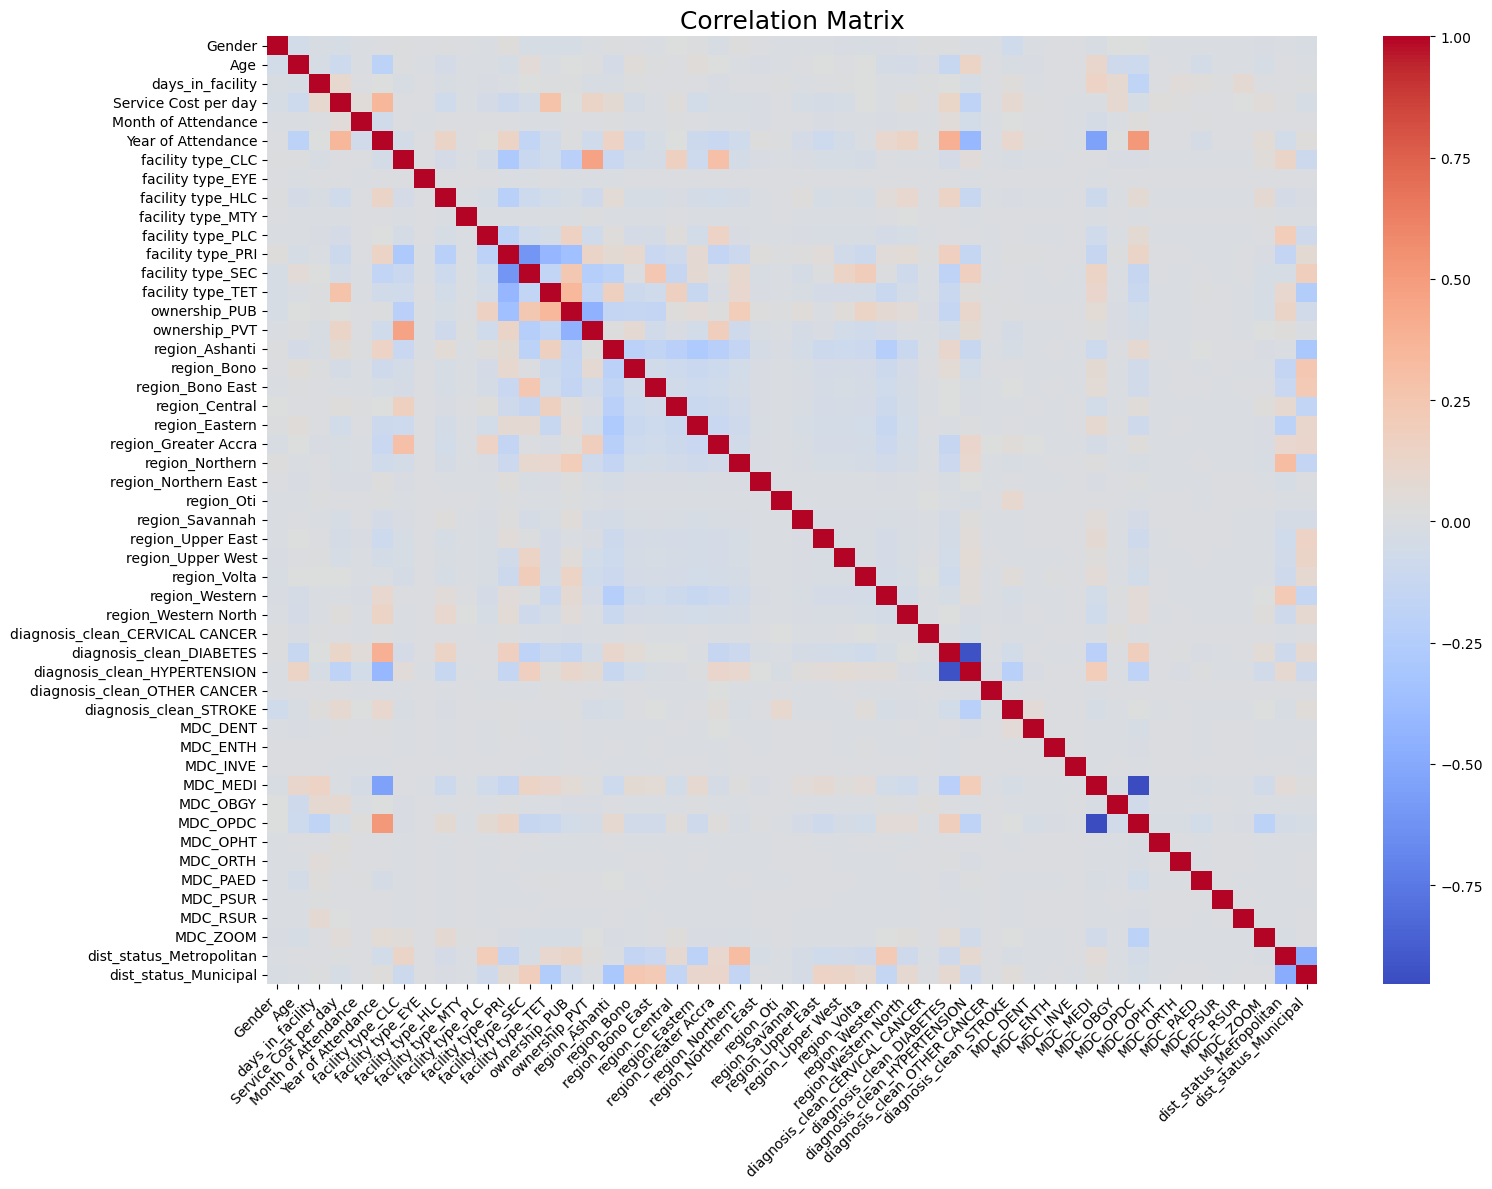

In [5]:
plt.figure(figsize=(16, 12))  
sns.heatmap(corr, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Add a title
plt.title('Correlation Matrix', fontsize=18)

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
corr["Service Cost per day"].sort_values(key = abs, ascending=False)

Service Cost per day               1.000000e+00
Year of Attendance                 3.581879e-01
facility type_TET                  2.805365e-01
diagnosis_clean_HYPERTENSION      -1.792169e-01
ownership_PVT                      1.355623e-01
diagnosis_clean_DIABETES           1.257472e-01
days_in_facility                   9.845498e-02
facility type_PRI                 -9.541802e-02
Age                               -8.680737e-02
MDC_OBGY                           8.518526e-02
diagnosis_clean_STROKE             8.392757e-02
region_Ashanti                     7.394395e-02
facility type_HLC                 -7.040061e-02
region_Eastern                    -5.470687e-02
facility type_SEC                 -4.863670e-02
MDC_ZOOM                           4.838273e-02
Month of Attendance                4.693411e-02
facility type_PLC                 -4.417792e-02
region_Bono                       -3.799362e-02
region_Western North               3.671519e-02
region_Upper East                 -3.569

We only keep the features with a correlation higher than 0.001 (in absolute value) with our target

In [7]:
threshold = 0.001
cols_to_keep = corr.loc["Service Cost per day", corr.loc["Service Cost per day"].abs() >= threshold].index.to_list()

In [8]:
df = df[cols_to_keep]

In [9]:
df.columns

Index(['Gender', 'Age', 'days_in_facility', 'Service Cost per day',
       'Month of Attendance', 'Year of Attendance', 'facility type_CLC',
       'facility type_HLC', 'facility type_PLC', 'facility type_PRI',
       'facility type_SEC', 'facility type_TET', 'ownership_PUB',
       'ownership_PVT', 'region_Ashanti', 'region_Bono', 'region_Bono East',
       'region_Central', 'region_Eastern', 'region_Greater Accra',
       'region_Northern', 'region_Northern East', 'region_Oti',
       'region_Savannah', 'region_Upper East', 'region_Upper West',
       'region_Volta', 'region_Western', 'region_Western North',
       'diagnosis_clean_CERVICAL CANCER', 'diagnosis_clean_DIABETES',
       'diagnosis_clean_HYPERTENSION', 'diagnosis_clean_STROKE', 'MDC_DENT',
       'MDC_ENTH', 'MDC_MEDI', 'MDC_OBGY', 'MDC_OPDC', 'MDC_OPHT', 'MDC_ORTH',
       'MDC_PAED', 'MDC_PSUR', 'MDC_RSUR', 'MDC_ZOOM',
       'dist_status_Metropolitan', 'dist_status_Municipal'],
      dtype='object')

We know there are some outliers in the costs. We will set their value to the 98th percentile's value so we mitigate their value

In [10]:
percentile_98 = df['Service Cost per day'].quantile(0.98)
print(f"98th percentile of Service Cost per day: {percentile_98}")

98th percentile of Service Cost per day: 86.37


In [11]:
100*df[df['Service Cost per day'] >= percentile_98].shape[0]/len(df)

2.1778147137491133

In [12]:
df['Service Cost per day'].loc[df['Service Cost per day'] >= percentile_98] = percentile_98

C:\Users\USER\AppData\Local\Temp\ipykernel_34376\2832591112.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Service Cost per day'].loc[df['Service Cost per day'] >= percentile_98] = percentile_98


In [13]:
df['Service Cost per day'].max()

np.float64(86.37)

## Modeling

We split the data

In [14]:
x = df.drop(columns=["Service Cost per day"])
y = df["Service Cost per day"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, shuffle=True)

We scale the data

In [15]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Linear Regression

In [159]:
linear_reg = LinearRegression()

linear_reg, linear_reg_results = train_evaluate_model(linear_reg, x_train_scaled, y_train, x_test_scaled, y_test)
linear_reg_results.to_pickle('models/linear_reg_results.pkl')
linear_reg_results

,Train,Test
MSE,147.512930,147.455892
MAE,7.799386,7.798434
RMSE,12.145490,12.143142
R2,0.442338,0.442928


### Lasso

In [116]:
# Default

lasso_default = Lasso()

lasso_default, lasso_default_results = train_evaluate_model(lasso_default, x_train_scaled, y_train, x_test_scaled, y_test, retrain = True)

lasso_default_results

,Train,Test
MSE,164.830997,164.927242
MAE,7.592917,7.596845
RMSE,12.838652,12.842400
R2,0.376868,0.376924


In [164]:
# Hyper parameter tuning

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 50, 1000, 10000]
}

lasso = Lasso()

lasso, lasso_best_params, lasso_best_mse = manual_hyperparameter_tuning(lasso, param_grid,x_train_scaled, y_train, x_test_scaled, y_test)

lasso, lasso_results = train_evaluate_model(lasso, x_train_scaled, y_train, x_test_scaled, y_test, retrain = False)

lasso_results.to_pickle('models/lasso_results.pkl')

lasso_results


Tuning Parameters:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\USER\.conda\envs\ML_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.003e+06, tolerance: 8.342e+04
  model = cd_fast.enet_coordinate_descent(
Tuning Parameters:  12%|█▎        | 1/8 [04:29<31:24, 269.20s/it]

Tried parameters: {'alpha': 0.001}, MSE: 147.5494


Tuning Parameters:  25%|██▌       | 2/8 [04:55<12:37, 126.28s/it]

Tried parameters: {'alpha': 0.01}, MSE: 148.0961


Tuning Parameters:  38%|███▊      | 3/8 [05:02<06:00, 72.05s/it] 

Tried parameters: {'alpha': 0.1}, MSE: 151.4253


Tuning Parameters:  50%|█████     | 4/8 [05:07<03:02, 45.53s/it]

Tried parameters: {'alpha': 1}, MSE: 188.0230


Tuning Parameters:  62%|██████▎   | 5/8 [05:12<01:32, 30.69s/it]

Tried parameters: {'alpha': 10}, MSE: 232.5762


Tuning Parameters:  75%|███████▌  | 6/8 [05:16<00:43, 21.68s/it]

Tried parameters: {'alpha': 50}, MSE: 264.3056


Tuning Parameters:  88%|████████▊ | 7/8 [05:20<00:15, 15.94s/it]

Tried parameters: {'alpha': 1000}, MSE: 264.3056


Tuning Parameters: 100%|██████████| 8/8 [05:24<00:00, 40.59s/it]


Tried parameters: {'alpha': 10000}, MSE: 264.3056

Best Parameters Found: {'alpha': 0.001}
Best MSE Score: 147.54937677566258


,Train,Test
MSE,147.587883,147.549377
MAE,7.800725,7.797419
RMSE,12.148575,12.146990
R2,0.442506,0.441747


### Ridge

In [119]:
# Default

ridge_default = Ridge()

ridge_default, ridge_default_results = train_evaluate_model(ridge_default, x_train_scaled, y_train, x_test_scaled, y_test, retrain = True)

ridge_default_results

,Train,Test
MSE,147.470872,147.411103
MAE,7.798017,7.796902
RMSE,12.143759,12.141297
R2,0.442497,0.443098


In [120]:
# Hyper parameter tuning

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1, 10, 50, 1000, 10000]
}

ridge = Ridge()

ridge, ridge_best_params, ridge_best_mse = manual_hyperparameter_tuning(ridge, param_grid, x_train_scaled, y_train, x_test_scaled, y_test)

ridge, ridge_results = train_evaluate_model(ridge, x_train_scaled, y_train, x_test_scaled, y_test, retrain = False)

ridge_results.to_pickle('models/ridge_results.pkl')

ridge_results


Tuning Parameters:  12%|█▎        | 1/8 [00:02<00:19,  2.74s/it]

Tried parameters: {'alpha': 0.001}, MSE: 147.4111


Tuning Parameters:  25%|██▌       | 2/8 [00:05<00:16,  2.68s/it]

Tried parameters: {'alpha': 0.01}, MSE: 147.4111


Tuning Parameters:  38%|███▊      | 3/8 [00:07<00:13,  2.64s/it]

Tried parameters: {'alpha': 0.1}, MSE: 147.4111


Tuning Parameters:  50%|█████     | 4/8 [00:10<00:10,  2.62s/it]

Tried parameters: {'alpha': 1}, MSE: 147.4111


Tuning Parameters:  62%|██████▎   | 5/8 [00:13<00:07,  2.64s/it]

Tried parameters: {'alpha': 10}, MSE: 147.4111


Tuning Parameters:  75%|███████▌  | 6/8 [00:16<00:05,  2.70s/it]

Tried parameters: {'alpha': 50}, MSE: 147.4112


Tuning Parameters:  88%|████████▊ | 7/8 [00:18<00:02,  2.63s/it]

Tried parameters: {'alpha': 1000}, MSE: 147.4171


Tuning Parameters: 100%|██████████| 8/8 [00:21<00:00,  2.64s/it]

Tried parameters: {'alpha': 10000}, MSE: 147.5412

Best Parameters Found: {'alpha': 0.001}
Best MSE Score: 147.41110058947172


,Train,Test
MSE,147.470872,147.411101
MAE,7.798018,7.796903
RMSE,12.143759,12.141297
R2,0.442497,0.443098


### Decision Trees

In [166]:
import multiprocessing

max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs available: {max_n_jobs}")


Maximum n_jobs available: 12


In [121]:
# Default

decision_tree_default = DecisionTreeRegressor()

decision_tree_default, decision_tree_default_results = train_evaluate_model(decision_tree_default, x_train_scaled, y_train, x_test_scaled, y_test, retrain = True)

decision_tree_default_results

,Train,Test
MSE,7.317089,29.433580
MAE,0.695952,1.390280
RMSE,2.705012,5.425272
R2,0.972338,0.888803


In [167]:
# Hyper parameter tuning

param_grid_dt = {
    "max_depth": [5, 10, 15, 20, 30],
    "min_samples_split": [50, 100, 200],
    "min_samples_leaf": [10, 20, 50],
}

decision_tree = DecisionTreeRegressor(random_state=42)

decision_tree, dt_best_params, dt_best_mse = manual_hyperparameter_tuning(
    decision_tree, param_grid_dt, x_train_scaled, y_train, x_test_scaled, y_test
)

decision_tree, dt_results = train_evaluate_model(
    decision_tree, x_train_scaled, y_train, x_test_scaled, y_test, retrain=False
)

dt_results.to_pickle('models/decision_tree_results.pkl')

dt_results

Tuning Parameters:   2%|▏         | 1/45 [00:08<06:34,  8.96s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 65.5263


Tuning Parameters:   4%|▍         | 2/45 [00:17<06:19,  8.84s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 65.5263


Tuning Parameters:   7%|▋         | 3/45 [00:26<06:09,  8.80s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 65.5263


Tuning Parameters:   9%|▉         | 4/45 [00:35<06:02,  8.84s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 65.5263


Tuning Parameters:  11%|█         | 5/45 [00:44<05:53,  8.85s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 65.5263


Tuning Parameters:  13%|█▎        | 6/45 [00:53<05:45,  8.85s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 65.5263


Tuning Parameters:  16%|█▌        | 7/45 [01:01<05:35,  8.83s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 65.5263


Tuning Parameters:  18%|█▊        | 8/45 [01:10<05:27,  8.85s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 65.5263


Tuning Parameters:  20%|██        | 9/45 [01:19<05:18,  8.83s/it]

Tried parameters: {'max_depth': 5, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 65.5263


Tuning Parameters:  22%|██▏       | 10/45 [01:34<06:17, 10.78s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 26.6440


Tuning Parameters:  24%|██▍       | 11/45 [01:49<06:50, 12.09s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 26.6750


Tuning Parameters:  27%|██▋       | 12/45 [02:05<07:11, 13.08s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 26.7897


Tuning Parameters:  29%|██▉       | 13/45 [02:20<07:18, 13.72s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 26.6869


Tuning Parameters:  31%|███       | 14/45 [02:35<07:17, 14.13s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 26.7122


Tuning Parameters:  33%|███▎      | 15/45 [02:50<07:12, 14.42s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 26.7897


Tuning Parameters:  36%|███▌      | 16/45 [03:05<07:03, 14.60s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 26.7938


Tuning Parameters:  38%|███▊      | 17/45 [03:20<06:52, 14.72s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 26.8145


Tuning Parameters:  40%|████      | 18/45 [03:35<06:39, 14.81s/it]

Tried parameters: {'max_depth': 10, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 26.8619


Tuning Parameters:  42%|████▏     | 19/45 [03:54<07:01, 16.19s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 20.7800


Tuning Parameters:  44%|████▍     | 20/45 [04:14<07:13, 17.32s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 20.9281


Tuning Parameters:  47%|████▋     | 21/45 [04:34<07:10, 17.94s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 21.3624


Tuning Parameters:  49%|████▉     | 22/45 [04:53<07:03, 18.41s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 20.8316


Tuning Parameters:  51%|█████     | 23/45 [05:13<06:52, 18.73s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 20.9827


Tuning Parameters:  53%|█████▎    | 24/45 [05:32<06:36, 18.90s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 21.3625


Tuning Parameters:  56%|█████▌    | 25/45 [05:51<06:20, 19.05s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 21.1262


Tuning Parameters:  58%|█████▊    | 26/45 [06:11<06:02, 19.10s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 21.2606


Tuning Parameters:  60%|██████    | 27/45 [06:30<05:44, 19.12s/it]

Tried parameters: {'max_depth': 15, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 21.5147


Tuning Parameters:  62%|██████▏   | 28/45 [06:52<05:40, 20.03s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 20.9330


Tuning Parameters:  64%|██████▍   | 29/45 [07:14<05:29, 20.62s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 20.9944


Tuning Parameters:  67%|██████▋   | 30/45 [07:36<05:15, 21.00s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 21.2601


Tuning Parameters:  69%|██████▉   | 31/45 [07:58<04:58, 21.35s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 20.7420


Tuning Parameters:  71%|███████   | 32/45 [08:20<04:40, 21.55s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 20.8814


Tuning Parameters:  73%|███████▎  | 33/45 [08:42<04:19, 21.63s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 21.2601


Tuning Parameters:  76%|███████▌  | 34/45 [09:04<03:59, 21.75s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 20.9419


Tuning Parameters:  78%|███████▊  | 35/45 [09:26<03:37, 21.74s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 21.0871


Tuning Parameters:  80%|████████  | 36/45 [09:47<03:15, 21.74s/it]

Tried parameters: {'max_depth': 20, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 21.3696


Tuning Parameters:  82%|████████▏ | 37/45 [10:12<02:59, 22.49s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 21.1661


Tuning Parameters:  84%|████████▍ | 38/45 [10:36<02:40, 22.93s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 21.1330


Tuning Parameters:  87%|████████▋ | 39/45 [10:59<02:18, 23.13s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 21.2889


Tuning Parameters:  89%|████████▉ | 40/45 [11:23<01:57, 23.43s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 20.8240


Tuning Parameters:  91%|█████████ | 41/45 [11:49<01:36, 24.16s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 20.9489


Tuning Parameters:  93%|█████████▎| 42/45 [12:13<01:12, 24.13s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 21.2889


Tuning Parameters:  96%|█████████▌| 43/45 [12:39<00:49, 24.78s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 20.9613


Tuning Parameters:  98%|█████████▊| 44/45 [13:05<00:24, 24.87s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 21.1015


Tuning Parameters: 100%|██████████| 45/45 [13:32<00:00, 18.05s/it]

Tried parameters: {'max_depth': 30, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 21.3851

Best Parameters Found: {'max_depth': 20, 'min_samples_split': 100, 'min_samples_leaf': 10}
Best MSE Score: 20.742007137722517


,Train,Test
MSE,18.895854,20.742007
MAE,1.311697,1.366395
RMSE,4.346936,4.554339
R2,0.928623,0.921523


In [168]:
# Hyper parameter tuning

param_grid_dt = {
    "max_depth": [40, 50],
    "min_samples_split": [50, 100, 200],
    "min_samples_leaf": [10, 20, 50],
}

decision_tree = DecisionTreeRegressor(random_state=42)

decision_tree, dt_best_params, dt_best_mse = manual_hyperparameter_tuning(
    decision_tree, param_grid_dt, x_train_scaled, y_train, x_test_scaled, y_test
)

decision_tree, dt_results = train_evaluate_model(
    decision_tree, x_train_scaled, y_train, x_test_scaled, y_test, retrain=False
)

dt_results

Tuning Parameters:   6%|▌         | 1/18 [00:25<07:14, 25.54s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 21.1674


Tuning Parameters:  11%|█         | 2/18 [00:50<06:46, 25.41s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 21.1335


Tuning Parameters:  17%|█▋        | 3/18 [01:15<06:14, 24.99s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 21.2892


Tuning Parameters:  22%|██▏       | 4/18 [01:39<05:45, 24.64s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 20.8243


Tuning Parameters:  28%|██▊       | 5/18 [02:03<05:17, 24.41s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 20.9491


Tuning Parameters:  33%|███▎      | 6/18 [02:27<04:51, 24.28s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 21.2890


Tuning Parameters:  39%|███▉      | 7/18 [02:51<04:25, 24.11s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 20.9615


Tuning Parameters:  44%|████▍     | 8/18 [03:14<03:59, 23.93s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 21.1016


Tuning Parameters:  50%|█████     | 9/18 [03:38<03:33, 23.78s/it]

Tried parameters: {'max_depth': 40, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 21.3851


Tuning Parameters:  56%|█████▌    | 10/18 [04:03<03:12, 24.10s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 50, 'min_samples_leaf': 10}, MSE: 21.1674


Tuning Parameters:  61%|██████    | 11/18 [04:27<02:48, 24.11s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 50, 'min_samples_leaf': 20}, MSE: 21.1341


Tuning Parameters:  67%|██████▋   | 12/18 [04:50<02:24, 24.02s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 50, 'min_samples_leaf': 50}, MSE: 21.2892


Tuning Parameters:  72%|███████▏  | 13/18 [05:16<02:01, 24.38s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 100, 'min_samples_leaf': 10}, MSE: 20.8244


Tuning Parameters:  78%|███████▊  | 14/18 [05:41<01:38, 24.62s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 100, 'min_samples_leaf': 20}, MSE: 20.9491


Tuning Parameters:  83%|████████▎ | 15/18 [06:05<01:13, 24.38s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 100, 'min_samples_leaf': 50}, MSE: 21.2890


Tuning Parameters:  89%|████████▉ | 16/18 [06:29<00:48, 24.31s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 200, 'min_samples_leaf': 10}, MSE: 20.9615


Tuning Parameters:  94%|█████████▍| 17/18 [06:53<00:24, 24.18s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 200, 'min_samples_leaf': 20}, MSE: 21.1016


Tuning Parameters: 100%|██████████| 18/18 [07:16<00:00, 24.26s/it]

Tried parameters: {'max_depth': 50, 'min_samples_split': 200, 'min_samples_leaf': 50}, MSE: 21.3852

Best Parameters Found: {'max_depth': 40, 'min_samples_split': 100, 'min_samples_leaf': 10}
Best MSE Score: 20.824302685614285


,Train,Test
MSE,18.704061,20.824303
MAE,1.296514,1.363531
RMSE,4.324819,4.563365
R2,0.929348,0.921211


### Random Forest

In [125]:
# Default

random_forest_default = RandomForestRegressor(n_jobs = -2, random_state=42)
2
random_forest_default, random_forest_default_results = train_evaluate_model(random_forest_default, x_train_scaled, y_train, x_test_scaled, y_test, retrain = True)

random_forest_default_results

,Train,Test
MSE,8.899540,20.792353
MAE,0.890910,1.312284
RMSE,2.983210,4.559863
R2,0.966356,0.921449


In [ ]:
# Hyper parameter tuning

param_grid_rf = {
    "n_estimators": [10, 50, 100, 200],
    "max_depth": [15, 20, 30, 40, 50],
    "min_samples_split": [50, 100, 200],
    "min_samples_leaf": [10, 20, 50],
}

random_forest = RandomForestRegressor(random_state=42, n_jobs=max_n_jobs)

random_forest, rf_best_params, rf_best_mse = manual_hyperparameter_tuning(
    random_forest, param_grid_rf, x_train_scaled, y_train, x_test_scaled, y_test
)

random_forest, rf_results = train_evaluate_model(
    random_forest,x_train_scaled, y_train, x_test_scaled, y_test retrain=False
)

rf_results.to_pickle('models/random_forest_results.pkl')

rf_results


From the multiple tests above, we see that the best hyper parameters are {'n_estimators': 50, 'max_depth': 40, 'min_samples_split': 50, 'min_samples_leaf': 10}, with MSE: 19.16

In [36]:
best_params_rf = {'n_estimators': 50, 'max_depth': 40, 'min_samples_split': 50, 'min_samples_leaf': 10}

random_forest = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params_rf)

random_forest, rf_results = train_evaluate_model(random_forest, x_train_scaled, y_train, x_test_scaled, y_test, retrain=True)

rf_results.to_pickle('models/random_forest_results.pkl')

rf_results


,Train,Test
MSE,17.331838,19.165313
MAE,1.256672,1.319442
RMSE,4.163152,4.377821
R2,0.934478,0.927596


### XGBOOST

In [141]:
# Default

xgboost_default = XGBRegressor()

xgboost_default, xgboost_default_results = train_evaluate_model(xgboost_default, x_train_scaled, y_train, x_test_scaled, y_test, retrain = True)

xgboost_default_results


,Train,Test
MSE,22.386549,22.434011
MAE,1.915964,1.919359
RMSE,4.731443,4.736456
R2,0.915369,0.915247


In [19]:
# Hyper parameter tuning

grid_param_gb = {
    "n_estimators": [50, 100],
    "max_depth": [15, 20, 30, 40, 50],
    'learning_rate': [0.7, 0.5, 0.3, 0.1, 0.01],
    "reg_alpha": [0.001, 0.01, 0.1, 1, 10],
    "reg_lambda": [0.001, 0.01, 0.1, 1, 10],
}
gb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', device = "cuda")
gb, gb_best_params, gb_best_mse = manual_hyperparameter_tuning(
    gb, grid_param_gb, x_train_scaled, y_train, x_test_scaled, y_test
)

gb, gb_results = train_evaluate_model(
    gb, x_train_scaled, y_train, x_test_scaled, y_test, retrain=False
)

gb_results.to_pickle('models/gb_results.pkl')


gb_results


Tuning Parameters:   0%|          | 1/1250 [00:11<4:06:55, 11.86s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 29.1280


Tuning Parameters:   0%|          | 2/1250 [00:24<4:13:59, 12.21s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 29.2548


Tuning Parameters:   0%|          | 3/1250 [00:36<4:10:24, 12.05s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 28.5593


Tuning Parameters:   0%|          | 4/1250 [00:47<4:01:13, 11.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.9782


Tuning Parameters:   0%|          | 5/1250 [00:56<3:41:08, 10.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.6652


Tuning Parameters:   0%|          | 6/1250 [01:08<3:52:43, 11.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 29.1858


Tuning Parameters:   1%|          | 7/1250 [01:20<3:57:14, 11.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 29.1634


Tuning Parameters:   1%|          | 8/1250 [01:32<4:01:50, 11.68s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 28.6236


Tuning Parameters:   1%|          | 9/1250 [01:44<4:01:12, 11.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.9874


Tuning Parameters:   1%|          | 10/1250 [01:53<3:44:39, 10.87s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 22.7953


Tuning Parameters:   1%|          | 11/1250 [02:05<3:52:29, 11.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 29.1553


Tuning Parameters:   1%|          | 12/1250 [02:16<3:53:22, 11.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 28.9409


Tuning Parameters:   1%|          | 13/1250 [02:28<3:55:58, 11.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 28.3772


Tuning Parameters:   1%|          | 14/1250 [02:39<3:52:18, 11.28s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.9595


Tuning Parameters:   1%|          | 15/1250 [02:48<3:38:30, 10.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 22.6607


Tuning Parameters:   1%|▏         | 16/1250 [03:00<3:44:31, 10.92s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.7510


Tuning Parameters:   1%|▏         | 17/1250 [03:11<3:47:31, 11.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.4624


Tuning Parameters:   1%|▏         | 18/1250 [03:23<3:50:03, 11.20s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.1704


Tuning Parameters:   2%|▏         | 19/1250 [03:34<3:51:05, 11.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.7789


Tuning Parameters:   2%|▏         | 20/1250 [03:43<3:38:12, 10.64s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.8445


Tuning Parameters:   2%|▏         | 21/1250 [03:53<3:32:55, 10.39s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.6697


Tuning Parameters:   2%|▏         | 22/1250 [04:03<3:31:23, 10.33s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.7826


Tuning Parameters:   2%|▏         | 23/1250 [04:14<3:31:46, 10.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.6064


Tuning Parameters:   2%|▏         | 24/1250 [04:23<3:26:17, 10.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.4677


Tuning Parameters:   2%|▏         | 25/1250 [04:32<3:18:38,  9.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.6758


Tuning Parameters:   2%|▏         | 26/1250 [04:43<3:29:10, 10.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 26.1956


Tuning Parameters:   2%|▏         | 27/1250 [04:55<3:37:15, 10.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 26.2413


Tuning Parameters:   2%|▏         | 28/1250 [05:06<3:40:24, 10.82s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 25.7532


Tuning Parameters:   2%|▏         | 29/1250 [05:16<3:35:47, 10.60s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 23.8777


Tuning Parameters:   2%|▏         | 30/1250 [05:25<3:23:03,  9.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 21.3216


Tuning Parameters:   2%|▏         | 31/1250 [05:37<3:33:29, 10.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 26.1985


Tuning Parameters:   3%|▎         | 32/1250 [05:48<3:38:45, 10.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 26.0314


Tuning Parameters:   3%|▎         | 33/1250 [05:59<3:41:12, 10.91s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 25.6625


Tuning Parameters:   3%|▎         | 34/1250 [06:09<3:36:39, 10.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 23.8276


Tuning Parameters:   3%|▎         | 35/1250 [06:18<3:23:10, 10.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 21.3773


Tuning Parameters:   3%|▎         | 36/1250 [06:29<3:29:16, 10.34s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 25.9934


Tuning Parameters:   3%|▎         | 37/1250 [06:40<3:35:58, 10.68s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 26.0087


Tuning Parameters:   3%|▎         | 38/1250 [06:52<3:38:12, 10.80s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 25.6534


Tuning Parameters:   3%|▎         | 39/1250 [07:02<3:36:04, 10.71s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 23.8012


Tuning Parameters:   3%|▎         | 40/1250 [07:11<3:25:55, 10.21s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 21.5157


Tuning Parameters:   3%|▎         | 41/1250 [07:22<3:30:16, 10.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 25.6887


Tuning Parameters:   3%|▎         | 42/1250 [07:33<3:35:59, 10.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 25.7691


Tuning Parameters:   3%|▎         | 43/1250 [07:44<3:35:39, 10.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 25.4170


Tuning Parameters:   4%|▎         | 44/1250 [07:54<3:30:03, 10.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 23.7312


Tuning Parameters:   4%|▎         | 45/1250 [08:03<3:18:25,  9.88s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 21.4165


Tuning Parameters:   4%|▎         | 46/1250 [08:12<3:18:28,  9.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.9021


Tuning Parameters:   4%|▍         | 47/1250 [08:22<3:18:24,  9.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.8141


Tuning Parameters:   4%|▍         | 48/1250 [08:32<3:17:59,  9.88s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.7132


Tuning Parameters:   4%|▍         | 49/1250 [08:42<3:15:37,  9.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 22.9933


Tuning Parameters:   4%|▍         | 50/1250 [08:51<3:11:21,  9.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 21.5181


Tuning Parameters:   4%|▍         | 51/1250 [09:02<3:21:57, 10.11s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 23.6286


Tuning Parameters:   4%|▍         | 52/1250 [09:14<3:29:20, 10.48s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 23.5894


Tuning Parameters:   4%|▍         | 53/1250 [09:25<3:32:56, 10.67s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 23.2724


Tuning Parameters:   4%|▍         | 54/1250 [09:35<3:30:34, 10.56s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 22.0433


Tuning Parameters:   4%|▍         | 55/1250 [09:44<3:20:22, 10.06s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 20.6097


Tuning Parameters:   4%|▍         | 56/1250 [09:55<3:27:19, 10.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 23.7415


Tuning Parameters:   5%|▍         | 57/1250 [10:07<3:34:06, 10.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 23.6879


Tuning Parameters:   5%|▍         | 58/1250 [10:18<3:36:10, 10.88s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 23.2812


Tuning Parameters:   5%|▍         | 59/1250 [10:28<3:32:53, 10.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 22.0374


Tuning Parameters:   5%|▍         | 60/1250 [10:37<3:19:40, 10.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 20.4674


Tuning Parameters:   5%|▍         | 61/1250 [10:48<3:25:52, 10.39s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 23.6557


Tuning Parameters:   5%|▍         | 62/1250 [10:59<3:32:13, 10.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 23.6182


Tuning Parameters:   5%|▌         | 63/1250 [11:11<3:36:41, 10.95s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 23.2687


Tuning Parameters:   5%|▌         | 64/1250 [11:21<3:32:25, 10.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 22.1621


Tuning Parameters:   5%|▌         | 65/1250 [11:30<3:19:27, 10.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 20.3281


Tuning Parameters:   5%|▌         | 66/1250 [11:41<3:24:15, 10.35s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 23.5232


Tuning Parameters:   5%|▌         | 67/1250 [11:51<3:24:42, 10.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 23.3028


Tuning Parameters:   5%|▌         | 68/1250 [12:02<3:27:14, 10.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 23.0919


Tuning Parameters:   6%|▌         | 69/1250 [12:12<3:23:29, 10.34s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 21.9689


Tuning Parameters:   6%|▌         | 70/1250 [12:20<3:12:12,  9.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 20.3477


Tuning Parameters:   6%|▌         | 71/1250 [12:30<3:11:52,  9.76s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 22.0979


Tuning Parameters:   6%|▌         | 72/1250 [12:40<3:10:55,  9.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 22.1400


Tuning Parameters:   6%|▌         | 73/1250 [12:49<3:07:49,  9.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 21.8920


Tuning Parameters:   6%|▌         | 74/1250 [12:58<3:05:13,  9.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 21.5116


Tuning Parameters:   6%|▌         | 75/1250 [13:07<3:00:12,  9.20s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.4065


Tuning Parameters:   6%|▌         | 76/1250 [13:22<3:37:09, 11.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 21.7753


Tuning Parameters:   6%|▌         | 77/1250 [13:38<4:03:00, 12.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 21.7796


Tuning Parameters:   6%|▌         | 78/1250 [13:53<4:18:55, 13.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 21.5296


Tuning Parameters:   6%|▋         | 79/1250 [14:07<4:21:05, 13.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 20.8123


Tuning Parameters:   6%|▋         | 80/1250 [14:18<4:08:42, 12.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 19.9490


Tuning Parameters:   6%|▋         | 81/1250 [14:33<4:23:07, 13.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 21.7465


Tuning Parameters:   7%|▋         | 82/1250 [14:48<4:33:03, 14.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 21.7847


Tuning Parameters:   7%|▋         | 83/1250 [15:04<4:41:29, 14.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 21.5140


Tuning Parameters:   7%|▋         | 84/1250 [15:17<4:36:13, 14.21s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 20.7989


Tuning Parameters:   7%|▋         | 85/1250 [15:29<4:18:35, 13.32s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 19.9628


Tuning Parameters:   7%|▋         | 86/1250 [15:43<4:26:38, 13.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 21.7494


Tuning Parameters:   7%|▋         | 87/1250 [15:58<4:32:43, 14.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 21.7424


Tuning Parameters:   7%|▋         | 88/1250 [16:14<4:39:54, 14.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 21.5291


Tuning Parameters:   7%|▋         | 89/1250 [16:27<4:34:45, 14.20s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 20.7876


Tuning Parameters:   7%|▋         | 90/1250 [16:39<4:18:37, 13.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 19.9424


Tuning Parameters:   7%|▋         | 91/1250 [16:53<4:20:52, 13.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 21.5272


Tuning Parameters:   7%|▋         | 92/1250 [17:06<4:21:48, 13.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 21.5450


Tuning Parameters:   7%|▋         | 93/1250 [17:20<4:23:11, 13.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 21.4167


Tuning Parameters:   8%|▊         | 94/1250 [17:33<4:20:13, 13.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 20.7722


Tuning Parameters:   8%|▊         | 95/1250 [17:44<4:07:01, 12.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 19.9433


Tuning Parameters:   8%|▊         | 96/1250 [17:56<4:01:31, 12.56s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 20.8357


Tuning Parameters:   8%|▊         | 97/1250 [18:09<3:59:03, 12.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 20.7854


Tuning Parameters:   8%|▊         | 98/1250 [18:21<3:57:13, 12.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 20.7472


Tuning Parameters:   8%|▊         | 99/1250 [18:33<3:54:39, 12.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 20.4632


Tuning Parameters:   8%|▊         | 100/1250 [18:43<3:45:31, 11.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 19.9106


Tuning Parameters:   8%|▊         | 101/1250 [18:59<4:06:48, 12.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 109.8355


Tuning Parameters:   8%|▊         | 102/1250 [19:14<4:21:55, 13.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 109.8508


Tuning Parameters:   8%|▊         | 103/1250 [19:29<4:26:09, 13.92s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 109.9624


Tuning Parameters:   8%|▊         | 104/1250 [19:42<4:18:38, 13.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 110.3512


Tuning Parameters:   8%|▊         | 105/1250 [19:52<3:59:19, 12.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 111.8461


Tuning Parameters:   8%|▊         | 106/1250 [20:07<4:16:02, 13.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 109.8353


Tuning Parameters:   9%|▊         | 107/1250 [20:23<4:27:03, 14.02s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 109.8514


Tuning Parameters:   9%|▊         | 108/1250 [20:37<4:29:04, 14.14s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 109.9627


Tuning Parameters:   9%|▊         | 109/1250 [20:50<4:20:15, 13.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 110.3512


Tuning Parameters:   9%|▉         | 110/1250 [21:00<4:00:55, 12.68s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 111.8465


Tuning Parameters:   9%|▉         | 111/1250 [21:16<4:19:20, 13.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 109.8402


Tuning Parameters:   9%|▉         | 112/1250 [21:31<4:27:22, 14.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 109.8555


Tuning Parameters:   9%|▉         | 113/1250 [21:45<4:28:14, 14.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 109.9667


Tuning Parameters:   9%|▉         | 114/1250 [21:58<4:19:32, 13.71s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 110.3520


Tuning Parameters:   9%|▉         | 115/1250 [22:09<4:02:45, 12.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 111.8471


Tuning Parameters:   9%|▉         | 116/1250 [22:23<4:12:42, 13.37s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 109.8732


Tuning Parameters:   9%|▉         | 117/1250 [22:37<4:14:42, 13.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 109.8868


Tuning Parameters:   9%|▉         | 118/1250 [22:50<4:13:05, 13.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 109.9874


Tuning Parameters:  10%|▉         | 119/1250 [23:03<4:06:21, 13.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 110.3582


Tuning Parameters:  10%|▉         | 120/1250 [23:13<3:49:49, 12.20s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 111.8504


Tuning Parameters:  10%|▉         | 121/1250 [23:24<3:45:38, 11.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 110.0725


Tuning Parameters:  10%|▉         | 122/1250 [23:36<3:42:18, 11.82s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 110.0780


Tuning Parameters:  10%|▉         | 123/1250 [23:47<3:39:45, 11.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 110.1140


Tuning Parameters:  10%|▉         | 124/1250 [23:58<3:35:35, 11.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 110.4148


Tuning Parameters:  10%|█         | 125/1250 [24:08<3:26:10, 11.00s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 111.9086


Tuning Parameters:  10%|█         | 126/1250 [24:53<6:36:41, 21.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 30.7872


Tuning Parameters:  10%|█         | 127/1250 [25:37<8:44:03, 28.00s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 30.6701


Tuning Parameters:  10%|█         | 128/1250 [26:20<10:10:43, 32.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.0794


Tuning Parameters:  10%|█         | 129/1250 [26:58<10:35:47, 34.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.6976


Tuning Parameters:  10%|█         | 130/1250 [27:26<10:05:46, 32.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.7332


Tuning Parameters:  10%|█         | 131/1250 [28:07<10:48:40, 34.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 30.7668


Tuning Parameters:  11%|█         | 132/1250 [28:48<11:22:32, 36.63s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 30.6908


Tuning Parameters:  11%|█         | 133/1250 [29:27<11:38:21, 37.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.0255


Tuning Parameters:  11%|█         | 134/1250 [30:05<11:40:09, 37.64s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.7207


Tuning Parameters:  11%|█         | 135/1250 [30:33<10:47:39, 34.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.7265


Tuning Parameters:  11%|█         | 136/1250 [31:09<10:53:19, 35.19s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 30.6529


Tuning Parameters:  11%|█         | 137/1250 [31:44<10:50:51, 35.09s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 30.4997


Tuning Parameters:  11%|█         | 138/1250 [32:21<10:58:27, 35.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.9398


Tuning Parameters:  11%|█         | 139/1250 [32:56<10:53:29, 35.29s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.6867


Tuning Parameters:  11%|█         | 140/1250 [33:25<10:22:31, 33.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.6670


Tuning Parameters:  11%|█▏        | 141/1250 [33:56<10:02:36, 32.60s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.9048


Tuning Parameters:  11%|█▏        | 142/1250 [34:32<10:23:44, 33.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.8335


Tuning Parameters:  11%|█▏        | 143/1250 [35:03<10:06:51, 32.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.3684


Tuning Parameters:  12%|█▏        | 144/1250 [35:36<10:05:52, 32.87s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.2952


Tuning Parameters:  12%|█▏        | 145/1250 [36:03<9:34:30, 31.20s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.4952


Tuning Parameters:  12%|█▏        | 146/1250 [36:23<8:33:30, 27.91s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 26.7908


Tuning Parameters:  12%|█▏        | 147/1250 [36:44<7:53:37, 25.76s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 26.7188


Tuning Parameters:  12%|█▏        | 148/1250 [37:04<7:22:22, 24.09s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.6153


Tuning Parameters:  12%|█▏        | 149/1250 [37:25<7:02:10, 23.01s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.6157


Tuning Parameters:  12%|█▏        | 150/1250 [37:44<6:41:33, 21.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.8696


Tuning Parameters:  12%|█▏        | 151/1250 [38:30<8:53:46, 29.14s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 29.3650


Tuning Parameters:  12%|█▏        | 152/1250 [39:12<10:01:14, 32.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 29.2099


Tuning Parameters:  12%|█▏        | 153/1250 [39:54<10:51:53, 35.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 28.5024


Tuning Parameters:  12%|█▏        | 154/1250 [40:29<10:48:15, 35.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.4020


Tuning Parameters:  12%|█▏        | 155/1250 [40:52<9:38:17, 31.69s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.9983


Tuning Parameters:  12%|█▏        | 156/1250 [41:33<10:31:57, 34.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 29.3699


Tuning Parameters:  13%|█▎        | 157/1250 [42:16<11:14:33, 37.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 29.2238


Tuning Parameters:  13%|█▎        | 158/1250 [42:54<11:21:42, 37.46s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 28.5227


Tuning Parameters:  13%|█▎        | 159/1250 [43:32<11:20:31, 37.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.4230


Tuning Parameters:  13%|█▎        | 160/1250 [43:57<10:16:09, 33.92s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 23.0958


Tuning Parameters:  13%|█▎        | 161/1250 [44:38<10:50:19, 35.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 29.1950


Tuning Parameters:  13%|█▎        | 162/1250 [45:18<11:13:11, 37.12s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 29.0433


Tuning Parameters:  13%|█▎        | 163/1250 [45:57<11:22:38, 37.68s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 28.4091


Tuning Parameters:  13%|█▎        | 164/1250 [46:36<11:30:11, 38.13s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.4131


Tuning Parameters:  13%|█▎        | 165/1250 [47:07<10:49:13, 35.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 23.0463


Tuning Parameters:  13%|█▎        | 166/1250 [47:43<10:50:14, 35.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.2928


Tuning Parameters:  13%|█▎        | 167/1250 [48:20<10:54:55, 36.28s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.2282


Tuning Parameters:  13%|█▎        | 168/1250 [48:52<10:33:02, 35.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.7488


Tuning Parameters:  14%|█▎        | 169/1250 [49:24<10:16:12, 34.20s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.0045


Tuning Parameters:  14%|█▎        | 170/1250 [49:49<9:23:21, 31.30s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.9519


Tuning Parameters:  14%|█▎        | 171/1250 [50:11<8:33:28, 28.55s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.3218


Tuning Parameters:  14%|█▍        | 172/1250 [50:36<8:13:54, 27.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.2796


Tuning Parameters:  14%|█▍        | 173/1250 [51:00<7:54:08, 26.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.1342


Tuning Parameters:  14%|█▍        | 174/1250 [51:22<7:30:02, 25.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.3128


Tuning Parameters:  14%|█▍        | 175/1250 [51:45<7:17:52, 24.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.7411


Tuning Parameters:  14%|█▍        | 176/1250 [52:34<9:28:24, 31.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 28.3221


Tuning Parameters:  14%|█▍        | 177/1250 [53:23<11:01:21, 36.98s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 28.2866


Tuning Parameters:  14%|█▍        | 178/1250 [54:03<11:17:07, 37.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 27.5490


Tuning Parameters:  14%|█▍        | 179/1250 [54:36<10:52:24, 36.55s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.0114


Tuning Parameters:  14%|█▍        | 180/1250 [54:52<9:02:59, 30.45s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 21.3956


Tuning Parameters:  14%|█▍        | 181/1250 [55:35<10:08:41, 34.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 28.3923


Tuning Parameters:  15%|█▍        | 182/1250 [56:18<10:54:19, 36.76s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 28.2125


Tuning Parameters:  15%|█▍        | 183/1250 [57:10<12:15:50, 41.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 27.5589


Tuning Parameters:  15%|█▍        | 184/1250 [57:45<11:41:41, 39.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 24.9938


Tuning Parameters:  15%|█▍        | 185/1250 [58:06<10:02:43, 33.96s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 21.4314


Tuning Parameters:  15%|█▍        | 186/1250 [58:51<10:58:08, 37.11s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 28.2449


Tuning Parameters:  15%|█▍        | 187/1250 [59:28<10:59:48, 37.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 28.0116


Tuning Parameters:  15%|█▌        | 188/1250 [1:00:14<11:43:34, 39.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 27.4615


Tuning Parameters:  15%|█▌        | 189/1250 [1:00:49<11:17:07, 38.29s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.0396


Tuning Parameters:  15%|█▌        | 190/1250 [1:01:06<9:21:53, 31.80s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 21.5786


Tuning Parameters:  15%|█▌        | 191/1250 [1:01:33<8:57:15, 30.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 27.0410


Tuning Parameters:  15%|█▌        | 192/1250 [1:02:02<8:50:34, 30.09s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 27.0900


Tuning Parameters:  15%|█▌        | 193/1250 [1:02:32<8:47:25, 29.94s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 26.6737


Tuning Parameters:  16%|█▌        | 194/1250 [1:03:03<8:55:25, 30.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 24.6779


Tuning Parameters:  16%|█▌        | 195/1250 [1:03:27<8:17:59, 28.32s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 21.3716


Tuning Parameters:  16%|█▌        | 196/1250 [1:03:51<7:55:40, 27.08s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.0732


Tuning Parameters:  16%|█▌        | 197/1250 [1:04:13<7:31:06, 25.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.0275


Tuning Parameters:  16%|█▌        | 198/1250 [1:04:34<7:01:52, 24.06s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.9205


Tuning Parameters:  16%|█▌        | 199/1250 [1:04:54<6:42:16, 22.97s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.1394


Tuning Parameters:  16%|█▌        | 200/1250 [1:05:11<6:11:46, 21.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 21.3869


Tuning Parameters:  16%|█▌        | 201/1250 [1:05:56<8:16:31, 28.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 26.6702


Tuning Parameters:  16%|█▌        | 202/1250 [1:06:41<9:40:21, 33.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 26.5902


Tuning Parameters:  16%|█▌        | 203/1250 [1:07:22<10:19:36, 35.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 25.8378


Tuning Parameters:  16%|█▋        | 204/1250 [1:07:54<10:01:37, 34.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 23.1488


Tuning Parameters:  16%|█▋        | 205/1250 [1:08:16<8:54:59, 30.72s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 20.3855


Tuning Parameters:  16%|█▋        | 206/1250 [1:09:02<10:15:38, 35.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 26.6870


Tuning Parameters:  17%|█▋        | 207/1250 [1:09:48<11:09:35, 38.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 26.5654


Tuning Parameters:  17%|█▋        | 208/1250 [1:10:29<11:21:48, 39.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 25.8245


Tuning Parameters:  17%|█▋        | 209/1250 [1:11:09<11:26:24, 39.56s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 23.1497


Tuning Parameters:  17%|█▋        | 210/1250 [1:11:33<10:03:21, 34.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 20.4059


Tuning Parameters:  17%|█▋        | 211/1250 [1:12:14<10:35:52, 36.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 26.4405


Tuning Parameters:  17%|█▋        | 212/1250 [1:12:52<10:41:42, 37.09s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 26.3378


Tuning Parameters:  17%|█▋        | 213/1250 [1:13:38<11:26:13, 39.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 25.7472


Tuning Parameters:  17%|█▋        | 214/1250 [1:14:19<11:36:20, 40.33s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 23.1418


Tuning Parameters:  17%|█▋        | 215/1250 [1:14:47<10:29:59, 36.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 20.4145


Tuning Parameters:  17%|█▋        | 216/1250 [1:15:20<10:08:59, 35.34s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 25.5446


Tuning Parameters:  17%|█▋        | 217/1250 [1:15:55<10:08:22, 35.34s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 25.4768


Tuning Parameters:  17%|█▋        | 218/1250 [1:16:24<9:37:13, 33.56s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 25.0439


Tuning Parameters:  18%|█▊        | 219/1250 [1:16:54<9:15:11, 32.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 22.9030


Tuning Parameters:  18%|█▊        | 220/1250 [1:17:15<8:15:11, 28.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 20.3732


Tuning Parameters:  18%|█▊        | 221/1250 [1:17:38<7:45:35, 27.15s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 22.5271


Tuning Parameters:  18%|█▊        | 222/1250 [1:17:59<7:14:33, 25.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 22.5161


Tuning Parameters:  18%|█▊        | 223/1250 [1:18:22<7:01:04, 24.60s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 22.3539


Tuning Parameters:  18%|█▊        | 224/1250 [1:18:46<6:57:47, 24.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 21.6735


Tuning Parameters:  18%|█▊        | 225/1250 [1:19:12<7:04:00, 24.82s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.2170


Tuning Parameters:  18%|█▊        | 226/1250 [1:20:03<9:22:26, 32.96s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 110.2150


Tuning Parameters:  18%|█▊        | 227/1250 [1:21:22<13:13:22, 46.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 110.2589


Tuning Parameters:  18%|█▊        | 228/1250 [1:22:04<12:52:36, 45.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 110.4938


Tuning Parameters:  18%|█▊        | 229/1250 [1:22:42<12:10:30, 42.93s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 110.6570


Tuning Parameters:  18%|█▊        | 230/1250 [1:23:04<10:24:46, 36.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 111.8284


Tuning Parameters:  18%|█▊        | 231/1250 [1:23:51<11:14:45, 39.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 110.2152


Tuning Parameters:  19%|█▊        | 232/1250 [1:24:33<11:25:25, 40.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 110.2597


Tuning Parameters:  19%|█▊        | 233/1250 [1:25:07<10:53:14, 38.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 110.4935


Tuning Parameters:  19%|█▊        | 234/1250 [1:25:34<9:56:21, 35.22s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 110.6565


Tuning Parameters:  19%|█▉        | 235/1250 [1:25:52<8:24:50, 29.84s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 111.8285


Tuning Parameters:  19%|█▉        | 236/1250 [1:26:32<9:16:02, 32.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 110.2269


Tuning Parameters:  19%|█▉        | 237/1250 [1:27:12<9:55:05, 35.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 110.2638


Tuning Parameters:  19%|█▉        | 238/1250 [1:27:52<10:17:35, 36.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 110.4910


Tuning Parameters:  19%|█▉        | 239/1250 [1:28:20<9:32:06, 33.95s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 110.6536


Tuning Parameters:  19%|█▉        | 240/1250 [1:28:35<7:57:15, 28.35s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 111.8289


Tuning Parameters:  19%|█▉        | 241/1250 [1:29:06<8:07:53, 29.01s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 110.2682


Tuning Parameters:  19%|█▉        | 242/1250 [1:29:40<8:34:51, 30.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 110.3041


Tuning Parameters:  19%|█▉        | 243/1250 [1:30:10<8:27:54, 30.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 110.4728


Tuning Parameters:  20%|█▉        | 244/1250 [1:30:35<8:01:55, 28.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 110.6267


Tuning Parameters:  20%|█▉        | 245/1250 [1:30:50<6:53:11, 24.67s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 111.8341


Tuning Parameters:  20%|█▉        | 246/1250 [1:31:07<6:16:26, 22.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 110.2475


Tuning Parameters:  20%|█▉        | 247/1250 [1:31:33<6:31:09, 23.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 110.2564


Tuning Parameters:  20%|█▉        | 248/1250 [1:31:55<6:23:51, 22.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 110.3007


Tuning Parameters:  20%|█▉        | 249/1250 [1:32:15<6:10:51, 22.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 110.4821


Tuning Parameters:  20%|██        | 250/1250 [1:32:32<5:40:57, 20.46s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 111.8828


Tuning Parameters:  20%|██        | 251/1250 [1:33:02<6:31:50, 23.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.5876


Tuning Parameters:  20%|██        | 252/1250 [1:33:30<6:50:07, 24.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.5849


Tuning Parameters:  20%|██        | 253/1250 [1:34:00<7:19:29, 26.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.3906


Tuning Parameters:  20%|██        | 254/1250 [1:34:51<9:19:43, 33.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.6874


Tuning Parameters:  20%|██        | 255/1250 [1:36:18<13:43:13, 49.64s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.5679


Tuning Parameters:  20%|██        | 256/1250 [1:36:49<12:09:52, 44.06s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.4029


Tuning Parameters:  21%|██        | 257/1250 [1:37:21<11:10:59, 40.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.4910


Tuning Parameters:  21%|██        | 258/1250 [1:37:56<10:43:28, 38.92s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.3894


Tuning Parameters:  21%|██        | 259/1250 [1:38:51<12:01:50, 43.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.7070


Tuning Parameters:  21%|██        | 260/1250 [1:40:25<16:07:50, 58.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.5728


Tuning Parameters:  21%|██        | 261/1250 [1:41:20<15:48:14, 57.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.5250


Tuning Parameters:  21%|██        | 262/1250 [1:42:15<15:38:29, 56.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9294


Tuning Parameters:  21%|██        | 263/1250 [1:43:11<15:28:57, 56.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 30.2841


Tuning Parameters:  21%|██        | 264/1250 [1:44:17<16:18:05, 59.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.6386


Tuning Parameters:  21%|██        | 265/1250 [1:45:47<18:45:40, 68.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.5591


Tuning Parameters:  21%|██▏       | 266/1250 [1:46:33<16:52:56, 61.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 30.4513


Tuning Parameters:  21%|██▏       | 267/1250 [1:47:28<16:20:07, 59.82s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 30.3492


Tuning Parameters:  21%|██▏       | 268/1250 [1:48:20<15:39:53, 57.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.6067


Tuning Parameters:  22%|██▏       | 269/1250 [1:49:18<15:44:01, 57.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.4232


Tuning Parameters:  22%|██▏       | 270/1250 [1:50:25<16:24:56, 60.30s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 25.4250


Tuning Parameters:  22%|██▏       | 271/1250 [1:51:06<14:53:24, 54.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 27.1447


Tuning Parameters:  22%|██▏       | 272/1250 [1:51:45<13:32:30, 49.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 27.0161


Tuning Parameters:  22%|██▏       | 273/1250 [1:52:19<12:15:45, 45.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.8474


Tuning Parameters:  22%|██▏       | 274/1250 [1:52:55<11:27:36, 42.27s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.7762


Tuning Parameters:  22%|██▏       | 275/1250 [1:53:38<11:34:23, 42.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 24.3141


Tuning Parameters:  22%|██▏       | 276/1250 [1:54:20<11:29:56, 42.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.5354


Tuning Parameters:  22%|██▏       | 277/1250 [1:55:03<11:27:58, 42.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.7819


Tuning Parameters:  22%|██▏       | 278/1250 [1:55:49<11:46:21, 43.60s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8863


Tuning Parameters:  22%|██▏       | 279/1250 [1:57:14<15:07:23, 56.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.7296


Tuning Parameters:  22%|██▏       | 280/1250 [1:58:30<16:43:09, 62.05s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.5207


Tuning Parameters:  22%|██▏       | 281/1250 [1:59:16<15:24:31, 57.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.3240


Tuning Parameters:  23%|██▎       | 282/1250 [2:00:06<14:46:32, 54.95s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.6357


Tuning Parameters:  23%|██▎       | 283/1250 [2:00:51<13:59:15, 52.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8429


Tuning Parameters:  23%|██▎       | 284/1250 [2:02:01<15:23:28, 57.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.7419


Tuning Parameters:  23%|██▎       | 285/1250 [2:03:18<16:58:06, 63.30s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.5561


Tuning Parameters:  23%|██▎       | 286/1250 [2:04:11<16:05:54, 60.12s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.3209


Tuning Parameters:  23%|██▎       | 287/1250 [2:05:03<15:26:05, 57.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8381


Tuning Parameters:  23%|██▎       | 288/1250 [2:05:55<14:59:45, 56.12s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6464


Tuning Parameters:  23%|██▎       | 289/1250 [2:07:02<15:49:58, 59.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.6710


Tuning Parameters:  23%|██▎       | 290/1250 [2:08:21<17:23:24, 65.21s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.6366


Tuning Parameters:  23%|██▎       | 291/1250 [2:09:13<16:18:54, 61.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.5276


Tuning Parameters:  23%|██▎       | 292/1250 [2:09:58<15:01:39, 56.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.4625


Tuning Parameters:  23%|██▎       | 293/1250 [2:10:46<14:21:31, 54.01s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.6077


Tuning Parameters:  24%|██▎       | 294/1250 [2:11:33<13:47:00, 51.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.4110


Tuning Parameters:  24%|██▎       | 295/1250 [2:12:27<13:54:34, 52.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.4325


Tuning Parameters:  24%|██▎       | 296/1250 [2:13:09<13:05:34, 49.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.7054


Tuning Parameters:  24%|██▍       | 297/1250 [2:13:48<12:11:05, 46.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.6027


Tuning Parameters:  24%|██▍       | 298/1250 [2:14:25<11:29:19, 43.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.5122


Tuning Parameters:  24%|██▍       | 299/1250 [2:15:02<10:55:52, 41.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.7271


Tuning Parameters:  24%|██▍       | 300/1250 [2:15:40<10:39:16, 40.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.4631


Tuning Parameters:  24%|██▍       | 301/1250 [2:16:36<11:53:24, 45.11s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.6327


Tuning Parameters:  24%|██▍       | 302/1250 [2:17:37<13:07:39, 49.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.9883


Tuning Parameters:  24%|██▍       | 303/1250 [2:18:45<14:36:02, 55.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8320


Tuning Parameters:  24%|██▍       | 304/1250 [2:20:24<17:59:23, 68.46s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.1237


Tuning Parameters:  24%|██▍       | 305/1250 [2:21:17<16:46:00, 63.87s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.9830


Tuning Parameters:  24%|██▍       | 306/1250 [2:22:22<16:47:04, 64.01s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.3753


Tuning Parameters:  25%|██▍       | 307/1250 [2:23:30<17:05:34, 65.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.8127


Tuning Parameters:  25%|██▍       | 308/1250 [2:24:41<17:31:33, 66.98s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.7861


Tuning Parameters:  25%|██▍       | 309/1250 [2:26:02<18:35:36, 71.13s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.1375


Tuning Parameters:  25%|██▍       | 310/1250 [2:26:52<16:56:46, 64.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 22.9653


Tuning Parameters:  25%|██▍       | 311/1250 [2:27:55<16:47:11, 64.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.2336


Tuning Parameters:  25%|██▍       | 312/1250 [2:28:58<16:39:46, 63.95s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8863


Tuning Parameters:  25%|██▌       | 313/1250 [2:30:04<16:47:39, 64.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5067


Tuning Parameters:  25%|██▌       | 314/1250 [2:31:17<17:26:59, 67.11s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.0571


Tuning Parameters:  25%|██▌       | 315/1250 [2:32:07<16:05:30, 61.96s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 22.9114


Tuning Parameters:  25%|██▌       | 316/1250 [2:32:54<14:55:05, 57.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.1629


Tuning Parameters:  25%|██▌       | 317/1250 [2:33:40<13:59:59, 54.02s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.9900


Tuning Parameters:  25%|██▌       | 318/1250 [2:34:26<13:21:56, 51.63s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.1517


Tuning Parameters:  26%|██▌       | 319/1250 [2:35:15<13:10:25, 50.94s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.6639


Tuning Parameters:  26%|██▌       | 320/1250 [2:35:58<12:32:06, 48.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.9641


Tuning Parameters:  26%|██▌       | 321/1250 [2:36:31<11:20:04, 43.92s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.6384


Tuning Parameters:  26%|██▌       | 322/1250 [2:37:05<10:29:26, 40.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.6725


Tuning Parameters:  26%|██▌       | 323/1250 [2:37:38<9:53:11, 38.39s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.4858


Tuning Parameters:  26%|██▌       | 324/1250 [2:38:10<9:27:02, 36.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.7926


Tuning Parameters:  26%|██▌       | 325/1250 [2:38:46<9:21:04, 36.39s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.4427


Tuning Parameters:  26%|██▌       | 326/1250 [2:40:04<12:31:26, 48.79s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.5448


Tuning Parameters:  26%|██▌       | 327/1250 [2:41:20<14:38:15, 57.09s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.9387


Tuning Parameters:  26%|██▌       | 328/1250 [2:42:38<16:13:55, 63.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8897


Tuning Parameters:  26%|██▋       | 329/1250 [2:43:42<16:14:17, 63.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.2358


Tuning Parameters:  26%|██▋       | 330/1250 [2:44:29<14:56:15, 58.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 21.1887


Tuning Parameters:  26%|██▋       | 331/1250 [2:45:40<15:53:17, 62.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.3194


Tuning Parameters:  27%|██▋       | 332/1250 [2:47:04<17:32:41, 68.80s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.7770


Tuning Parameters:  27%|██▋       | 333/1250 [2:48:32<18:58:50, 74.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8437


Tuning Parameters:  27%|██▋       | 334/1250 [2:49:37<18:16:53, 71.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.2441


Tuning Parameters:  27%|██▋       | 335/1250 [2:50:26<16:30:50, 64.97s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 21.1679


Tuning Parameters:  27%|██▋       | 336/1250 [2:51:29<16:17:53, 64.19s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.0682


Tuning Parameters:  27%|██▋       | 337/1250 [2:52:27<15:51:07, 62.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.7331


Tuning Parameters:  27%|██▋       | 338/1250 [2:53:24<15:24:37, 60.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.4631


Tuning Parameters:  27%|██▋       | 339/1250 [2:54:24<15:17:50, 60.45s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.1853


Tuning Parameters:  27%|██▋       | 340/1250 [2:55:12<14:21:05, 56.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 21.1619


Tuning Parameters:  27%|██▋       | 341/1250 [2:55:59<13:35:37, 53.84s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.5242


Tuning Parameters:  27%|██▋       | 342/1250 [2:56:47<13:10:42, 52.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.4340


Tuning Parameters:  27%|██▋       | 343/1250 [2:57:35<12:46:32, 50.71s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.5254


Tuning Parameters:  28%|██▊       | 344/1250 [2:58:21<12:28:14, 49.55s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 24.6551


Tuning Parameters:  28%|██▊       | 345/1250 [2:59:03<11:49:03, 47.01s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 21.0965


Tuning Parameters:  28%|██▊       | 346/1250 [2:59:35<10:41:36, 42.58s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.3272


Tuning Parameters:  28%|██▊       | 347/1250 [3:00:07<9:55:52, 39.59s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.3052


Tuning Parameters:  28%|██▊       | 348/1250 [3:00:37<9:11:31, 36.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.1562


Tuning Parameters:  28%|██▊       | 349/1250 [3:01:10<8:51:45, 35.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 22.3708


Tuning Parameters:  28%|██▊       | 350/1250 [3:01:45<8:49:54, 35.33s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.6703


Tuning Parameters:  28%|██▊       | 351/1250 [3:03:10<12:33:44, 50.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 111.2708


Tuning Parameters:  28%|██▊       | 352/1250 [3:04:23<14:15:47, 57.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 111.3372


Tuning Parameters:  28%|██▊       | 353/1250 [3:05:15<13:52:16, 55.67s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 111.5608


Tuning Parameters:  28%|██▊       | 354/1250 [3:05:52<12:25:38, 49.93s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 110.9442


Tuning Parameters:  28%|██▊       | 355/1250 [3:06:15<10:21:54, 41.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 111.8477


Tuning Parameters:  28%|██▊       | 356/1250 [3:07:34<13:09:16, 52.97s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 111.2691


Tuning Parameters:  29%|██▊       | 357/1250 [3:08:44<14:26:44, 58.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 111.3377


Tuning Parameters:  29%|██▊       | 358/1250 [3:09:42<14:24:36, 58.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 111.5591


Tuning Parameters:  29%|██▊       | 359/1250 [3:10:24<13:08:14, 53.08s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 110.9443


Tuning Parameters:  29%|██▉       | 360/1250 [3:10:43<10:36:20, 42.90s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 111.8478


Tuning Parameters:  29%|██▉       | 361/1250 [3:11:42<11:46:55, 47.71s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 111.2750


Tuning Parameters:  29%|██▉       | 362/1250 [3:12:38<12:23:33, 50.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 111.3428


Tuning Parameters:  29%|██▉       | 363/1250 [3:13:25<12:10:26, 49.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 111.5410


Tuning Parameters:  29%|██▉       | 364/1250 [3:14:05<11:25:20, 46.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 110.9403


Tuning Parameters:  29%|██▉       | 365/1250 [3:14:25<9:28:47, 38.56s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 111.8475


Tuning Parameters:  29%|██▉       | 366/1250 [3:15:08<9:49:08, 39.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 111.2131


Tuning Parameters:  29%|██▉       | 367/1250 [3:15:50<9:54:49, 40.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 111.2389


Tuning Parameters:  29%|██▉       | 368/1250 [3:16:33<10:05:23, 41.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 111.3405


Tuning Parameters:  30%|██▉       | 369/1250 [3:17:14<10:07:14, 41.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 110.8657


Tuning Parameters:  30%|██▉       | 370/1250 [3:17:37<8:43:02, 35.66s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 111.8487


Tuning Parameters:  30%|██▉       | 371/1250 [3:18:03<8:01:24, 32.86s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 110.4851


Tuning Parameters:  30%|██▉       | 372/1250 [3:18:28<7:28:03, 30.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 110.4862


Tuning Parameters:  30%|██▉       | 373/1250 [3:18:54<7:03:55, 29.00s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 110.4957


Tuning Parameters:  30%|██▉       | 374/1250 [3:19:19<6:46:51, 27.87s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 110.5546


Tuning Parameters:  30%|███       | 375/1250 [3:19:40<6:18:12, 25.93s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 111.8902


Tuning Parameters:  30%|███       | 376/1250 [3:20:06<6:15:57, 25.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0416


Tuning Parameters:  30%|███       | 377/1250 [3:20:33<6:20:07, 26.13s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.8153


Tuning Parameters:  30%|███       | 378/1250 [3:21:01<6:28:47, 26.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.4181


Tuning Parameters:  30%|███       | 379/1250 [3:21:51<8:08:35, 33.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.6894


Tuning Parameters:  30%|███       | 380/1250 [3:24:04<15:21:43, 63.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.6520


Tuning Parameters:  30%|███       | 381/1250 [3:24:32<12:46:52, 52.95s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7910


Tuning Parameters:  31%|███       | 382/1250 [3:25:05<11:16:56, 46.79s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.7043


Tuning Parameters:  31%|███       | 383/1250 [3:25:37<10:12:56, 42.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.4189


Tuning Parameters:  31%|███       | 384/1250 [3:26:28<10:51:10, 45.12s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.6906


Tuning Parameters:  31%|███       | 385/1250 [3:28:32<16:31:15, 68.76s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.6640


Tuning Parameters:  31%|███       | 386/1250 [3:29:29<15:39:21, 65.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.7331


Tuning Parameters:  31%|███       | 387/1250 [3:30:22<14:44:16, 61.48s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 32.0298


Tuning Parameters:  31%|███       | 388/1250 [3:31:17<14:16:22, 59.61s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 30.3244


Tuning Parameters:  31%|███       | 389/1250 [3:32:20<14:31:06, 60.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.6538


Tuning Parameters:  31%|███       | 390/1250 [3:34:05<17:40:16, 73.97s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.6053


Tuning Parameters:  31%|███▏      | 391/1250 [3:35:00<16:16:29, 68.21s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 30.4494


Tuning Parameters:  31%|███▏      | 392/1250 [3:35:54<15:13:04, 63.85s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 30.3395


Tuning Parameters:  31%|███▏      | 393/1250 [3:36:49<14:36:37, 61.37s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.5929


Tuning Parameters:  32%|███▏      | 394/1250 [3:37:41<13:55:37, 58.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.4139


Tuning Parameters:  32%|███▏      | 395/1250 [3:38:54<14:53:55, 62.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 25.4356


Tuning Parameters:  32%|███▏      | 396/1250 [3:39:35<13:19:08, 56.15s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 27.1343


Tuning Parameters:  32%|███▏      | 397/1250 [3:40:16<12:16:27, 51.80s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 27.0484


Tuning Parameters:  32%|███▏      | 398/1250 [3:40:59<11:35:46, 49.00s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.8932


Tuning Parameters:  32%|███▏      | 399/1250 [3:41:41<11:04:50, 46.87s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.7828


Tuning Parameters:  32%|███▏      | 400/1250 [3:42:26<10:59:21, 46.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 24.2612


Tuning Parameters:  32%|███▏      | 401/1250 [3:42:59<9:59:40, 42.38s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0446


Tuning Parameters:  32%|███▏      | 402/1250 [3:43:30<9:12:02, 39.06s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.0968


Tuning Parameters:  32%|███▏      | 403/1250 [3:44:05<8:53:26, 37.79s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8620


Tuning Parameters:  32%|███▏      | 404/1250 [3:45:05<10:25:27, 44.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.7543


Tuning Parameters:  32%|███▏      | 405/1250 [3:47:03<15:36:21, 66.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.8471


Tuning Parameters:  32%|███▏      | 406/1250 [3:47:38<13:22:20, 57.04s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7630


Tuning Parameters:  33%|███▎      | 407/1250 [3:48:14<11:52:21, 50.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.9015


Tuning Parameters:  33%|███▎      | 408/1250 [3:49:06<11:57:16, 51.11s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8559


Tuning Parameters:  33%|███▎      | 409/1250 [3:50:34<14:30:23, 62.10s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.7573


Tuning Parameters:  33%|███▎      | 410/1250 [3:53:08<20:56:51, 89.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.8517


Tuning Parameters:  33%|███▎      | 411/1250 [3:54:20<19:41:43, 84.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.5582


Tuning Parameters:  33%|███▎      | 412/1250 [3:55:38<19:13:29, 82.59s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9380


Tuning Parameters:  33%|███▎      | 413/1250 [3:57:00<19:06:29, 82.19s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6298


Tuning Parameters:  33%|███▎      | 414/1250 [3:58:34<19:54:12, 85.71s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.6866


Tuning Parameters:  33%|███▎      | 415/1250 [4:00:46<23:07:25, 99.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.8475


Tuning Parameters:  33%|███▎      | 416/1250 [4:01:50<20:35:08, 88.86s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.5059


Tuning Parameters:  33%|███▎      | 417/1250 [4:02:54<18:52:15, 81.56s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.4795


Tuning Parameters:  33%|███▎      | 418/1250 [4:03:59<17:42:18, 76.61s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.6022


Tuning Parameters:  34%|███▎      | 419/1250 [4:05:09<17:14:36, 74.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.4002


Tuning Parameters:  34%|███▎      | 420/1250 [4:06:46<18:44:44, 81.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.6596


Tuning Parameters:  34%|███▎      | 421/1250 [4:07:43<17:00:27, 73.86s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.7040


Tuning Parameters:  34%|███▍      | 422/1250 [4:08:29<15:07:28, 65.76s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.6282


Tuning Parameters:  34%|███▍      | 423/1250 [4:09:09<13:16:17, 57.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.5239


Tuning Parameters:  34%|███▍      | 424/1250 [4:09:49<12:02:09, 52.46s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.7450


Tuning Parameters:  34%|███▍      | 425/1250 [4:10:32<11:22:05, 49.61s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.5198


Tuning Parameters:  34%|███▍      | 426/1250 [4:11:20<11:15:06, 49.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0670


Tuning Parameters:  34%|███▍      | 427/1250 [4:12:09<11:16:48, 49.34s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.2300


Tuning Parameters:  34%|███▍      | 428/1250 [4:13:05<11:42:59, 51.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8711


Tuning Parameters:  34%|███▍      | 429/1250 [4:14:37<14:27:46, 63.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.1466


Tuning Parameters:  34%|███▍      | 430/1250 [4:16:21<17:12:53, 75.58s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 23.7790


Tuning Parameters:  34%|███▍      | 431/1250 [4:17:16<15:49:26, 69.56s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7740


Tuning Parameters:  35%|███▍      | 432/1250 [4:18:13<14:56:32, 65.76s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 33.0257


Tuning Parameters:  35%|███▍      | 433/1250 [4:19:15<14:37:07, 64.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8409


Tuning Parameters:  35%|███▍      | 434/1250 [4:20:40<16:03:24, 70.84s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.1355


Tuning Parameters:  35%|███▍      | 435/1250 [4:22:20<18:00:48, 79.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 23.7929


Tuning Parameters:  35%|███▍      | 436/1250 [4:23:18<16:30:18, 73.00s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.4428


Tuning Parameters:  35%|███▍      | 437/1250 [4:24:16<15:28:11, 68.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9953


Tuning Parameters:  35%|███▌      | 438/1250 [4:25:17<14:55:01, 66.13s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5488


Tuning Parameters:  35%|███▌      | 439/1250 [4:26:29<15:19:55, 68.06s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.1012


Tuning Parameters:  35%|███▌      | 440/1250 [4:27:58<16:41:11, 74.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 23.7678


Tuning Parameters:  35%|███▌      | 441/1250 [4:28:47<14:58:55, 66.67s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.1842


Tuning Parameters:  35%|███▌      | 442/1250 [4:29:37<13:50:36, 61.68s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.0546


Tuning Parameters:  35%|███▌      | 443/1250 [4:30:32<13:22:36, 59.67s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.1193


Tuning Parameters:  36%|███▌      | 444/1250 [4:31:29<13:09:37, 58.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.7314


Tuning Parameters:  36%|███▌      | 445/1250 [4:32:35<13:38:23, 61.00s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 23.6136


Tuning Parameters:  36%|███▌      | 446/1250 [4:33:15<12:12:03, 54.63s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.6967


Tuning Parameters:  36%|███▌      | 447/1250 [4:33:54<11:10:54, 50.13s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.7070


Tuning Parameters:  36%|███▌      | 448/1250 [4:34:35<10:32:26, 47.32s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.5070


Tuning Parameters:  36%|███▌      | 449/1250 [4:35:17<10:12:01, 45.84s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.8603


Tuning Parameters:  36%|███▌      | 450/1250 [4:36:02<10:08:25, 45.63s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.5743


Tuning Parameters:  36%|███▌      | 451/1250 [4:37:27<12:42:18, 57.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.9670


Tuning Parameters:  36%|███▌      | 452/1250 [4:38:48<14:18:14, 64.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.3019


Tuning Parameters:  36%|███▌      | 453/1250 [4:40:04<15:00:13, 67.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.9349


Tuning Parameters:  36%|███▋      | 454/1250 [4:41:28<16:04:05, 72.67s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.3884


Tuning Parameters:  36%|███▋      | 455/1250 [4:42:31<15:24:49, 69.80s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 21.3500


Tuning Parameters:  36%|███▋      | 456/1250 [4:43:44<15:37:19, 70.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.6882


Tuning Parameters:  37%|███▋      | 457/1250 [4:44:57<15:44:47, 71.48s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 33.0889


Tuning Parameters:  37%|███▋      | 458/1250 [4:46:09<15:46:47, 71.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.9041


Tuning Parameters:  37%|███▋      | 459/1250 [4:47:17<15:29:57, 70.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.3893


Tuning Parameters:  37%|███▋      | 460/1250 [4:48:16<14:42:47, 67.05s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 21.3454


Tuning Parameters:  37%|███▋      | 461/1250 [4:49:12<13:56:51, 63.64s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.2733


Tuning Parameters:  37%|███▋      | 462/1250 [4:50:07<13:24:13, 61.24s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8525


Tuning Parameters:  37%|███▋      | 463/1250 [4:51:05<13:07:23, 60.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5250


Tuning Parameters:  37%|███▋      | 464/1250 [4:52:11<13:32:40, 62.04s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.3010


Tuning Parameters:  37%|███▋      | 465/1250 [4:53:07<13:07:09, 60.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 21.3021


Tuning Parameters:  37%|███▋      | 466/1250 [4:53:50<12:00:26, 55.14s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.5373


Tuning Parameters:  37%|███▋      | 467/1250 [4:54:34<11:14:36, 51.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.4582


Tuning Parameters:  37%|███▋      | 468/1250 [4:55:19<10:45:18, 49.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.5789


Tuning Parameters:  38%|███▊      | 469/1250 [4:56:10<10:50:11, 49.95s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 24.7466


Tuning Parameters:  38%|███▊      | 470/1250 [4:57:01<10:57:05, 50.55s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 21.2404


Tuning Parameters:  38%|███▊      | 471/1250 [4:57:41<10:13:13, 47.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.3621


Tuning Parameters:  38%|███▊      | 472/1250 [4:58:20<9:40:30, 44.77s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.3486


Tuning Parameters:  38%|███▊      | 473/1250 [4:59:00<9:21:48, 43.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.2118


Tuning Parameters:  38%|███▊      | 474/1250 [4:59:43<9:17:06, 43.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 22.4689


Tuning Parameters:  38%|███▊      | 475/1250 [5:00:26<9:17:45, 43.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.7279


Tuning Parameters:  38%|███▊      | 476/1250 [5:01:45<11:35:13, 53.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 111.3278


Tuning Parameters:  38%|███▊      | 477/1250 [5:02:56<12:41:56, 59.14s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 111.3978


Tuning Parameters:  38%|███▊      | 478/1250 [5:04:02<13:08:05, 61.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 111.5911


Tuning Parameters:  38%|███▊      | 479/1250 [5:05:01<12:56:41, 60.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 110.9479


Tuning Parameters:  38%|███▊      | 480/1250 [5:05:27<10:43:10, 50.12s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 111.8477


Tuning Parameters:  38%|███▊      | 481/1250 [5:06:51<12:53:51, 60.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 111.3239


Tuning Parameters:  39%|███▊      | 482/1250 [5:08:08<13:57:08, 65.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 111.3981


Tuning Parameters:  39%|███▊      | 483/1250 [5:09:06<13:27:11, 63.14s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 111.5878


Tuning Parameters:  39%|███▊      | 484/1250 [5:10:02<12:56:40, 60.84s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 110.9516


Tuning Parameters:  39%|███▉      | 485/1250 [5:10:28<10:42:38, 50.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 111.8478


Tuning Parameters:  39%|███▉      | 486/1250 [5:11:43<12:15:11, 57.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 111.3297


Tuning Parameters:  39%|███▉      | 487/1250 [5:12:56<13:14:42, 62.49s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 111.3894


Tuning Parameters:  39%|███▉      | 488/1250 [5:13:55<12:59:41, 61.39s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 111.5676


Tuning Parameters:  39%|███▉      | 489/1250 [5:14:52<12:41:07, 60.01s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 110.9456


Tuning Parameters:  39%|███▉      | 490/1250 [5:15:19<10:35:26, 50.17s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 111.8475


Tuning Parameters:  39%|███▉      | 491/1250 [5:16:10<10:39:05, 50.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 111.2299


Tuning Parameters:  39%|███▉      | 492/1250 [5:16:59<10:30:16, 49.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 111.2478


Tuning Parameters:  39%|███▉      | 493/1250 [5:17:46<10:20:17, 49.17s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 111.3521


Tuning Parameters:  40%|███▉      | 494/1250 [5:18:42<10:44:50, 51.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 110.8710


Tuning Parameters:  40%|███▉      | 495/1250 [5:19:08<9:10:07, 43.72s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 111.8487


Tuning Parameters:  40%|███▉      | 496/1250 [5:19:38<8:16:53, 39.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 110.4843


Tuning Parameters:  40%|███▉      | 497/1250 [5:20:08<7:38:45, 36.55s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 110.4856


Tuning Parameters:  40%|███▉      | 498/1250 [5:20:38<7:14:55, 34.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 110.4961


Tuning Parameters:  40%|███▉      | 499/1250 [5:21:04<6:41:32, 32.08s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 110.5545


Tuning Parameters:  40%|████      | 500/1250 [5:21:25<5:59:48, 28.79s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 111.8902


Tuning Parameters:  40%|████      | 501/1250 [5:21:53<5:54:13, 28.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0447


Tuning Parameters:  40%|████      | 502/1250 [5:22:20<5:48:35, 27.96s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.8170


Tuning Parameters:  40%|████      | 503/1250 [5:22:50<5:56:17, 28.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.4175


Tuning Parameters:  40%|████      | 504/1250 [5:23:43<7:28:11, 36.05s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.6730


Tuning Parameters:  40%|████      | 505/1250 [5:26:13<14:32:17, 70.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.6271


Tuning Parameters:  40%|████      | 506/1250 [5:26:46<12:10:02, 58.87s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7940


Tuning Parameters:  41%|████      | 507/1250 [5:27:19<10:35:26, 51.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.7064


Tuning Parameters:  41%|████      | 508/1250 [5:27:55<9:37:36, 46.71s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.4186


Tuning Parameters:  41%|████      | 509/1250 [5:28:50<10:05:02, 48.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.7020


Tuning Parameters:  41%|████      | 510/1250 [5:31:07<15:30:13, 75.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.6553


Tuning Parameters:  41%|████      | 511/1250 [5:32:06<14:28:00, 70.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.7326


Tuning Parameters:  41%|████      | 512/1250 [5:32:57<13:17:05, 64.80s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 32.0323


Tuning Parameters:  41%|████      | 513/1250 [5:33:55<12:50:03, 62.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 30.3236


Tuning Parameters:  41%|████      | 514/1250 [5:34:53<12:32:31, 61.35s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.6335


Tuning Parameters:  41%|████      | 515/1250 [5:36:22<14:11:31, 69.51s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.5883


Tuning Parameters:  41%|████▏     | 516/1250 [5:37:04<12:32:05, 61.48s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 30.4499


Tuning Parameters:  41%|████▏     | 517/1250 [5:37:47<11:21:00, 55.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 30.3397


Tuning Parameters:  41%|████▏     | 518/1250 [5:38:31<10:37:36, 52.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.5926


Tuning Parameters:  42%|████▏     | 519/1250 [5:39:19<10:21:07, 50.98s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.4214


Tuning Parameters:  42%|████▏     | 520/1250 [5:40:22<11:02:40, 54.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 25.4316


Tuning Parameters:  42%|████▏     | 521/1250 [5:40:59<10:00:43, 49.44s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 27.1615


Tuning Parameters:  42%|████▏     | 522/1250 [5:41:37<9:17:07, 45.92s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 27.0405


Tuning Parameters:  42%|████▏     | 523/1250 [5:42:16<8:49:45, 43.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.8951


Tuning Parameters:  42%|████▏     | 524/1250 [5:42:52<8:23:53, 41.64s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.7657


Tuning Parameters:  42%|████▏     | 525/1250 [5:43:33<8:18:09, 41.23s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 24.2667


Tuning Parameters:  42%|████▏     | 526/1250 [5:44:02<7:34:17, 37.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0511


Tuning Parameters:  42%|████▏     | 527/1250 [5:44:33<7:08:49, 35.59s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.1011


Tuning Parameters:  42%|████▏     | 528/1250 [5:45:08<7:05:59, 35.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8695


Tuning Parameters:  42%|████▏     | 529/1250 [5:46:06<8:28:53, 42.35s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.7649


Tuning Parameters:  42%|████▏     | 530/1250 [5:48:05<13:02:09, 65.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.8735


Tuning Parameters:  42%|████▏     | 531/1250 [5:48:40<11:14:28, 56.28s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7654


Tuning Parameters:  43%|████▎     | 532/1250 [5:49:16<10:00:04, 50.15s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.9053


Tuning Parameters:  43%|████▎     | 533/1250 [5:49:55<9:17:32, 46.66s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8528


Tuning Parameters:  43%|████▎     | 534/1250 [5:50:55<10:05:23, 50.73s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.7436


Tuning Parameters:  43%|████▎     | 535/1250 [5:52:46<13:39:30, 68.77s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.8744


Tuning Parameters:  43%|████▎     | 536/1250 [5:53:38<12:38:40, 63.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.5575


Tuning Parameters:  43%|████▎     | 537/1250 [5:54:30<11:57:59, 60.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9428


Tuning Parameters:  43%|████▎     | 538/1250 [5:55:24<11:33:14, 58.42s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6285


Tuning Parameters:  43%|████▎     | 539/1250 [5:56:30<11:57:55, 60.58s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.6848


Tuning Parameters:  43%|████▎     | 540/1250 [5:58:02<13:48:05, 69.98s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.8594


Tuning Parameters:  43%|████▎     | 541/1250 [5:58:47<12:21:24, 62.74s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.5108


Tuning Parameters:  43%|████▎     | 542/1250 [5:59:33<11:19:56, 57.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.4795


Tuning Parameters:  43%|████▎     | 543/1250 [6:00:20<10:40:54, 54.39s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.6023


Tuning Parameters:  44%|████▎     | 544/1250 [6:01:11<10:28:25, 53.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.4184


Tuning Parameters:  44%|████▎     | 545/1250 [6:02:19<11:19:16, 57.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.6664


Tuning Parameters:  44%|████▎     | 546/1250 [6:03:00<10:17:46, 52.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.7131


Tuning Parameters:  44%|████▍     | 547/1250 [6:03:40<9:33:54, 48.98s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.6208


Tuning Parameters:  44%|████▍     | 548/1250 [6:04:21<9:03:12, 46.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.5263


Tuning Parameters:  44%|████▍     | 549/1250 [6:05:03<8:46:32, 45.07s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.7530


Tuning Parameters:  44%|████▍     | 550/1250 [6:05:47<8:43:20, 44.86s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.5125


Tuning Parameters:  44%|████▍     | 551/1250 [6:06:35<8:54:50, 45.91s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0669


Tuning Parameters:  44%|████▍     | 552/1250 [6:07:25<9:06:58, 47.02s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.2314


Tuning Parameters:  44%|████▍     | 553/1250 [6:08:20<9:35:04, 49.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8720


Tuning Parameters:  44%|████▍     | 554/1250 [6:09:51<11:59:07, 61.99s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.1339


Tuning Parameters:  44%|████▍     | 555/1250 [6:11:42<14:46:53, 76.57s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 23.8238


Tuning Parameters:  44%|████▍     | 556/1250 [6:12:41<13:46:11, 71.43s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7741


Tuning Parameters:  45%|████▍     | 557/1250 [6:13:38<12:53:03, 66.93s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 33.0255


Tuning Parameters:  45%|████▍     | 558/1250 [6:14:39<12:32:40, 65.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8401


Tuning Parameters:  45%|████▍     | 559/1250 [6:16:07<13:50:40, 72.13s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.1419


Tuning Parameters:  45%|████▍     | 560/1250 [6:17:52<15:41:08, 81.84s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 23.8134


Tuning Parameters:  45%|████▍     | 561/1250 [6:18:51<14:21:27, 75.02s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.4413


Tuning Parameters:  45%|████▍     | 562/1250 [6:19:50<13:26:14, 70.31s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9949


Tuning Parameters:  45%|████▌     | 563/1250 [6:20:51<12:53:14, 67.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5498


Tuning Parameters:  45%|████▌     | 564/1250 [6:22:06<13:16:52, 69.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.1212


Tuning Parameters:  45%|████▌     | 565/1250 [6:23:36<14:25:26, 75.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 23.7844


Tuning Parameters:  45%|████▌     | 566/1250 [6:24:26<12:55:29, 68.03s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.1838


Tuning Parameters:  45%|████▌     | 567/1250 [6:25:16<11:51:48, 62.53s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.0530


Tuning Parameters:  45%|████▌     | 568/1250 [6:26:06<11:08:25, 58.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.1167


Tuning Parameters:  46%|████▌     | 569/1250 [6:27:02<11:00:01, 58.15s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.7208


Tuning Parameters:  46%|████▌     | 570/1250 [6:28:11<11:35:13, 61.34s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 23.6284


Tuning Parameters:  46%|████▌     | 571/1250 [6:28:54<10:30:26, 55.71s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.6898


Tuning Parameters:  46%|████▌     | 572/1250 [6:29:35<9:39:27, 51.28s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.7033


Tuning Parameters:  46%|████▌     | 573/1250 [6:30:18<9:10:25, 48.78s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.5054


Tuning Parameters:  46%|████▌     | 574/1250 [6:31:02<8:56:06, 47.58s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.8728


Tuning Parameters:  46%|████▌     | 575/1250 [6:31:50<8:56:05, 47.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.5756


Tuning Parameters:  46%|████▌     | 576/1250 [6:33:09<10:41:13, 57.08s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.9687


Tuning Parameters:  46%|████▌     | 577/1250 [6:34:28<11:54:26, 63.69s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.3016


Tuning Parameters:  46%|████▌     | 578/1250 [6:35:44<12:32:24, 67.18s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.9342


Tuning Parameters:  46%|████▋     | 579/1250 [6:36:53<12:36:52, 67.68s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.3972


Tuning Parameters:  46%|████▋     | 580/1250 [6:37:52<12:06:32, 65.06s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 21.3465


Tuning Parameters:  46%|████▋     | 581/1250 [6:39:02<12:23:16, 66.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.6879


Tuning Parameters:  47%|████▋     | 582/1250 [6:40:12<12:31:59, 67.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 33.0886


Tuning Parameters:  47%|████▋     | 583/1250 [6:41:20<12:34:40, 67.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.9001


Tuning Parameters:  47%|████▋     | 584/1250 [6:42:28<12:31:58, 67.75s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.3961


Tuning Parameters:  47%|████▋     | 585/1250 [6:43:26<11:58:30, 64.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 21.3390


Tuning Parameters:  47%|████▋     | 586/1250 [6:44:23<11:31:11, 62.46s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.2731


Tuning Parameters:  47%|████▋     | 587/1250 [6:45:19<11:10:57, 60.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8513


Tuning Parameters:  47%|████▋     | 588/1250 [6:46:17<10:58:51, 59.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5304


Tuning Parameters:  47%|████▋     | 589/1250 [6:47:19<11:07:56, 60.63s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.3020


Tuning Parameters:  47%|████▋     | 590/1250 [6:48:17<10:56:16, 59.66s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 21.3258


Tuning Parameters:  47%|████▋     | 591/1250 [6:49:00<10:01:01, 54.72s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.5412


Tuning Parameters:  47%|████▋     | 592/1250 [6:49:44<9:24:33, 51.48s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.4575


Tuning Parameters:  47%|████▋     | 593/1250 [6:50:28<9:00:02, 49.32s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.5769


Tuning Parameters:  48%|████▊     | 594/1250 [6:51:20<9:05:57, 49.94s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 24.7561


Tuning Parameters:  48%|████▊     | 595/1250 [6:52:12<9:13:30, 50.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 21.2445


Tuning Parameters:  48%|████▊     | 596/1250 [6:52:51<8:34:37, 47.21s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.3650


Tuning Parameters:  48%|████▊     | 597/1250 [6:53:32<8:12:56, 45.29s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.3490


Tuning Parameters:  48%|████▊     | 598/1250 [6:54:14<8:02:34, 44.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.2120


Tuning Parameters:  48%|████▊     | 599/1250 [6:55:03<8:15:47, 45.70s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 22.4645


Tuning Parameters:  48%|████▊     | 600/1250 [6:55:52<8:27:09, 46.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.7312


Tuning Parameters:  48%|████▊     | 601/1250 [6:57:11<10:10:49, 56.47s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 111.3289


Tuning Parameters:  48%|████▊     | 602/1250 [6:58:21<10:50:49, 60.26s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 111.3982


Tuning Parameters:  48%|████▊     | 603/1250 [6:59:13<10:23:36, 57.83s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 111.5909


Tuning Parameters:  48%|████▊     | 604/1250 [7:00:02<9:54:33, 55.22s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 110.9479


Tuning Parameters:  48%|████▊     | 605/1250 [7:00:25<8:10:27, 45.62s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 111.8477


Tuning Parameters:  48%|████▊     | 606/1250 [7:01:38<9:38:25, 53.89s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 111.3250


Tuning Parameters:  49%|████▊     | 607/1250 [7:02:47<10:25:52, 58.40s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 111.3986


Tuning Parameters:  49%|████▊     | 608/1250 [7:03:39<10:03:04, 56.36s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 111.5875


Tuning Parameters:  49%|████▊     | 609/1250 [7:04:29<9:41:44, 54.45s/it] 

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 110.9516


Tuning Parameters:  49%|████▉     | 610/1250 [7:04:52<8:01:44, 45.16s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 111.8478


Tuning Parameters:  49%|████▉     | 611/1250 [7:05:53<8:50:31, 49.81s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 111.3300


Tuning Parameters:  49%|████▉     | 612/1250 [7:06:51<9:15:34, 52.25s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 111.3897


Tuning Parameters:  49%|████▉     | 613/1250 [7:07:40<9:03:25, 51.19s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 111.5673


Tuning Parameters:  49%|████▉     | 614/1250 [7:08:30<8:59:43, 50.92s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 110.9456


Tuning Parameters:  49%|████▉     | 615/1250 [7:08:53<7:30:12, 42.54s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 111.8475


Tuning Parameters:  49%|████▉     | 616/1250 [7:09:36<7:32:07, 42.79s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 111.2297


Tuning Parameters:  49%|████▉     | 617/1250 [7:10:18<7:27:09, 42.38s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 111.2475


Tuning Parameters:  49%|████▉     | 618/1250 [7:10:57<7:17:41, 41.55s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 111.3519


Tuning Parameters:  50%|████▉     | 619/1250 [7:11:45<7:37:25, 43.50s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 110.8710


Tuning Parameters:  50%|████▉     | 620/1250 [7:12:08<6:30:37, 37.20s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 111.8487


Tuning Parameters:  50%|████▉     | 621/1250 [7:12:32<5:50:13, 33.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 110.4843


Tuning Parameters:  50%|████▉     | 622/1250 [7:12:58<5:25:23, 31.09s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 110.4856


Tuning Parameters:  50%|████▉     | 623/1250 [7:13:24<5:07:21, 29.41s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 110.4961


Tuning Parameters:  50%|████▉     | 624/1250 [7:13:47<4:48:27, 27.65s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 110.5545


Tuning Parameters:  50%|█████     | 625/1250 [7:14:04<4:15:27, 24.52s/it]

Tried parameters: {'n_estimators': 50, 'max_depth': 50, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 111.8902


Tuning Parameters:  50%|█████     | 626/1250 [7:14:30<4:19:00, 24.90s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 30.1946


Tuning Parameters:  50%|█████     | 627/1250 [7:14:56<4:22:09, 25.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 30.2031


Tuning Parameters:  50%|█████     | 628/1250 [7:15:21<4:21:52, 25.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.6261


Tuning Parameters:  50%|█████     | 629/1250 [7:15:46<4:18:55, 25.02s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.2969


Tuning Parameters:  50%|█████     | 630/1250 [7:16:05<4:01:37, 23.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.0847


Tuning Parameters:  50%|█████     | 631/1250 [7:16:31<4:07:47, 24.02s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 30.1935


Tuning Parameters:  51%|█████     | 632/1250 [7:16:57<4:13:08, 24.58s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 30.2076


Tuning Parameters:  51%|█████     | 633/1250 [7:17:23<4:16:02, 24.90s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.6295


Tuning Parameters:  51%|█████     | 634/1250 [7:17:46<4:10:18, 24.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.2524


Tuning Parameters:  51%|█████     | 635/1250 [7:18:06<3:56:07, 23.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.0697


Tuning Parameters:  51%|█████     | 636/1250 [7:18:31<4:02:12, 23.67s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 30.0816


Tuning Parameters:  51%|█████     | 637/1250 [7:18:55<4:05:04, 23.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 29.9997


Tuning Parameters:  51%|█████     | 638/1250 [7:19:20<4:07:26, 24.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.4927


Tuning Parameters:  51%|█████     | 639/1250 [7:19:44<4:04:28, 24.01s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.3528


Tuning Parameters:  51%|█████     | 640/1250 [7:20:04<3:51:49, 22.80s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.0676


Tuning Parameters:  51%|█████▏    | 641/1250 [7:20:28<3:54:47, 23.13s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.5757


Tuning Parameters:  51%|█████▏    | 642/1250 [7:20:51<3:56:30, 23.34s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.4425


Tuning Parameters:  51%|█████▏    | 643/1250 [7:21:15<3:57:49, 23.51s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.0402


Tuning Parameters:  52%|█████▏    | 644/1250 [7:21:38<3:56:04, 23.37s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.9406


Tuning Parameters:  52%|█████▏    | 645/1250 [7:21:59<3:46:17, 22.44s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.1811


Tuning Parameters:  52%|█████▏    | 646/1250 [7:22:20<3:41:12, 21.97s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 26.3789


Tuning Parameters:  52%|█████▏    | 647/1250 [7:22:41<3:37:46, 21.67s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 26.4159


Tuning Parameters:  52%|█████▏    | 648/1250 [7:23:01<3:34:29, 21.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.2730


Tuning Parameters:  52%|█████▏    | 649/1250 [7:23:22<3:31:13, 21.09s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.4078


Tuning Parameters:  52%|█████▏    | 650/1250 [7:23:44<3:33:08, 21.31s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.9366


Tuning Parameters:  52%|█████▏    | 651/1250 [7:24:08<3:40:58, 22.14s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 27.4475


Tuning Parameters:  52%|█████▏    | 652/1250 [7:24:32<3:48:26, 22.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 27.4081


Tuning Parameters:  52%|█████▏    | 653/1250 [7:24:56<3:51:27, 23.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 27.0099


Tuning Parameters:  52%|█████▏    | 654/1250 [7:25:18<3:46:07, 22.76s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.1616


Tuning Parameters:  52%|█████▏    | 655/1250 [7:25:36<3:31:19, 21.31s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.5759


Tuning Parameters:  52%|█████▏    | 656/1250 [7:26:00<3:38:18, 22.05s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 27.4083


Tuning Parameters:  53%|█████▎    | 657/1250 [7:26:24<3:43:18, 22.59s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 27.3059


Tuning Parameters:  53%|█████▎    | 658/1250 [7:26:47<3:46:31, 22.96s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 26.9211


Tuning Parameters:  53%|█████▎    | 659/1250 [7:27:10<3:44:09, 22.76s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.2293


Tuning Parameters:  53%|█████▎    | 660/1250 [7:27:28<3:31:09, 21.47s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 22.6508


Tuning Parameters:  53%|█████▎    | 661/1250 [7:27:51<3:35:13, 21.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 27.2879


Tuning Parameters:  53%|█████▎    | 662/1250 [7:28:14<3:38:26, 22.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 27.3215


Tuning Parameters:  53%|█████▎    | 663/1250 [7:28:37<3:40:28, 22.54s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 26.8781


Tuning Parameters:  53%|█████▎    | 664/1250 [7:28:59<3:37:25, 22.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.0874


Tuning Parameters:  53%|█████▎    | 665/1250 [7:29:17<3:25:59, 21.13s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 22.7146


Tuning Parameters:  53%|█████▎    | 666/1250 [7:29:40<3:29:15, 21.50s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 26.9169


Tuning Parameters:  53%|█████▎    | 667/1250 [7:30:03<3:34:31, 22.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 26.9462


Tuning Parameters:  53%|█████▎    | 668/1250 [7:30:26<3:36:14, 22.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 26.6246


Tuning Parameters:  54%|█████▎    | 669/1250 [7:30:47<3:33:25, 22.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.0792


Tuning Parameters:  54%|█████▎    | 670/1250 [7:31:06<3:21:42, 20.87s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.5991


Tuning Parameters:  54%|█████▎    | 671/1250 [7:31:26<3:19:30, 20.67s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.7820


Tuning Parameters:  54%|█████▍    | 672/1250 [7:31:46<3:18:12, 20.57s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.7022


Tuning Parameters:  54%|█████▍    | 673/1250 [7:32:07<3:17:39, 20.55s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.5717


Tuning Parameters:  54%|█████▍    | 674/1250 [7:32:26<3:14:33, 20.27s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.9295


Tuning Parameters:  54%|█████▍    | 675/1250 [7:32:45<3:10:28, 19.88s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.5711


Tuning Parameters:  54%|█████▍    | 676/1250 [7:33:08<3:18:19, 20.73s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 24.9030


Tuning Parameters:  54%|█████▍    | 677/1250 [7:33:31<3:24:41, 21.43s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 24.8588


Tuning Parameters:  54%|█████▍    | 678/1250 [7:33:53<3:25:58, 21.61s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 24.4979


Tuning Parameters:  54%|█████▍    | 679/1250 [7:34:13<3:22:08, 21.24s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 23.1453


Tuning Parameters:  54%|█████▍    | 680/1250 [7:34:29<3:06:45, 19.66s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 20.9968


Tuning Parameters:  54%|█████▍    | 681/1250 [7:34:52<3:14:55, 20.55s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 24.8963


Tuning Parameters:  55%|█████▍    | 682/1250 [7:35:15<3:20:24, 21.17s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 24.8750


Tuning Parameters:  55%|█████▍    | 683/1250 [7:35:37<3:22:55, 21.47s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 24.5254


Tuning Parameters:  55%|█████▍    | 684/1250 [7:35:57<3:19:58, 21.20s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 23.1155


Tuning Parameters:  55%|█████▍    | 685/1250 [7:36:13<3:04:48, 19.63s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 20.9677


Tuning Parameters:  55%|█████▍    | 686/1250 [7:36:35<3:10:10, 20.23s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 24.8288


Tuning Parameters:  55%|█████▍    | 687/1250 [7:36:57<3:14:01, 20.68s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 24.7040


Tuning Parameters:  55%|█████▌    | 688/1250 [7:37:19<3:17:21, 21.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 24.5398


Tuning Parameters:  55%|█████▌    | 689/1250 [7:37:40<3:17:32, 21.13s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 23.2163


Tuning Parameters:  55%|█████▌    | 690/1250 [7:37:56<3:03:42, 19.68s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 21.0591


Tuning Parameters:  55%|█████▌    | 691/1250 [7:38:18<3:08:17, 20.21s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 24.5924


Tuning Parameters:  55%|█████▌    | 692/1250 [7:38:38<3:09:34, 20.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 24.5251


Tuning Parameters:  55%|█████▌    | 693/1250 [7:39:00<3:12:44, 20.76s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 24.2644


Tuning Parameters:  56%|█████▌    | 694/1250 [7:39:20<3:09:08, 20.41s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 23.0462


Tuning Parameters:  56%|█████▌    | 695/1250 [7:39:36<2:57:49, 19.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 21.1375


Tuning Parameters:  56%|█████▌    | 696/1250 [7:39:56<2:58:50, 19.37s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.0463


Tuning Parameters:  56%|█████▌    | 697/1250 [7:40:16<2:59:24, 19.47s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.0995


Tuning Parameters:  56%|█████▌    | 698/1250 [7:40:35<2:57:46, 19.32s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 22.8911


Tuning Parameters:  56%|█████▌    | 699/1250 [7:40:53<2:55:33, 19.12s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 22.3856


Tuning Parameters:  56%|█████▌    | 700/1250 [7:41:10<2:49:01, 18.44s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.9986


Tuning Parameters:  56%|█████▌    | 701/1250 [7:41:36<3:08:53, 20.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 22.3532


Tuning Parameters:  56%|█████▌    | 702/1250 [7:42:01<3:21:50, 22.10s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 22.3124


Tuning Parameters:  56%|█████▌    | 703/1250 [7:42:27<3:29:51, 23.02s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 22.0176


Tuning Parameters:  56%|█████▋    | 704/1250 [7:42:49<3:28:14, 22.88s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 21.1451


Tuning Parameters:  56%|█████▋    | 705/1250 [7:43:08<3:16:08, 21.59s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 19.9504


Tuning Parameters:  56%|█████▋    | 706/1250 [7:43:33<3:25:26, 22.66s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 22.3393


Tuning Parameters:  57%|█████▋    | 707/1250 [7:43:58<3:32:27, 23.48s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 22.3900


Tuning Parameters:  57%|█████▋    | 708/1250 [7:44:23<3:36:07, 23.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 22.0804


Tuning Parameters:  57%|█████▋    | 709/1250 [7:44:45<3:31:06, 23.41s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 21.0677


Tuning Parameters:  57%|█████▋    | 710/1250 [7:45:04<3:17:59, 22.00s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 19.9404


Tuning Parameters:  57%|█████▋    | 711/1250 [7:45:29<3:25:13, 22.84s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 22.3518


Tuning Parameters:  57%|█████▋    | 712/1250 [7:45:53<3:29:27, 23.36s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 22.3201


Tuning Parameters:  57%|█████▋    | 713/1250 [7:46:18<3:31:20, 23.61s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 22.0485


Tuning Parameters:  57%|█████▋    | 714/1250 [7:46:40<3:27:39, 23.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 21.1289


Tuning Parameters:  57%|█████▋    | 715/1250 [7:46:58<3:14:16, 21.79s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 19.9446


Tuning Parameters:  57%|█████▋    | 716/1250 [7:47:22<3:17:50, 22.23s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 22.0427


Tuning Parameters:  57%|█████▋    | 717/1250 [7:47:44<3:18:40, 22.36s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 21.9990


Tuning Parameters:  57%|█████▋    | 718/1250 [7:48:07<3:20:04, 22.57s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 21.8659


Tuning Parameters:  58%|█████▊    | 719/1250 [7:48:29<3:17:24, 22.31s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 21.0158


Tuning Parameters:  58%|█████▊    | 720/1250 [7:48:48<3:06:38, 21.13s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 19.9409


Tuning Parameters:  58%|█████▊    | 721/1250 [7:49:08<3:04:55, 20.97s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 21.1158


Tuning Parameters:  58%|█████▊    | 722/1250 [7:49:29<3:03:21, 20.84s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 21.0582


Tuning Parameters:  58%|█████▊    | 723/1250 [7:49:49<3:02:17, 20.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 20.9815


Tuning Parameters:  58%|█████▊    | 724/1250 [7:50:09<3:00:16, 20.56s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 20.6490


Tuning Parameters:  58%|█████▊    | 725/1250 [7:50:27<2:53:05, 19.78s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 19.9022


Tuning Parameters:  58%|█████▊    | 726/1250 [7:50:58<3:21:06, 23.03s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 53.4205


Tuning Parameters:  58%|█████▊    | 727/1250 [7:51:29<3:41:05, 25.36s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 53.4320


Tuning Parameters:  58%|█████▊    | 728/1250 [7:51:57<3:49:19, 26.36s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 53.4873


Tuning Parameters:  58%|█████▊    | 729/1250 [7:52:23<3:47:27, 26.20s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 53.6994


Tuning Parameters:  58%|█████▊    | 730/1250 [7:52:45<3:35:44, 24.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 54.8613


Tuning Parameters:  58%|█████▊    | 731/1250 [7:53:15<3:49:36, 26.54s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 53.4201


Tuning Parameters:  59%|█████▊    | 732/1250 [7:53:46<3:58:19, 27.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 53.4310


Tuning Parameters:  59%|█████▊    | 733/1250 [7:54:14<4:00:15, 27.88s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 53.4863


Tuning Parameters:  59%|█████▊    | 734/1250 [7:54:40<3:54:40, 27.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 53.7008


Tuning Parameters:  59%|█████▉    | 735/1250 [7:55:03<3:42:11, 25.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 54.8617


Tuning Parameters:  59%|█████▉    | 736/1250 [7:55:32<3:50:24, 26.90s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 53.4220


Tuning Parameters:  59%|█████▉    | 737/1250 [7:56:01<3:56:19, 27.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 53.4334


Tuning Parameters:  59%|█████▉    | 738/1250 [7:56:29<3:57:13, 27.80s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 53.4857


Tuning Parameters:  59%|█████▉    | 739/1250 [7:56:55<3:51:59, 27.24s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 53.7026


Tuning Parameters:  59%|█████▉    | 740/1250 [7:57:17<3:38:32, 25.71s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 54.8607


Tuning Parameters:  59%|█████▉    | 741/1250 [7:57:44<3:41:13, 26.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 53.4286


Tuning Parameters:  59%|█████▉    | 742/1250 [7:58:11<3:42:31, 26.28s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 53.4410


Tuning Parameters:  59%|█████▉    | 743/1250 [7:58:38<3:42:19, 26.31s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 53.4775


Tuning Parameters:  60%|█████▉    | 744/1250 [7:59:02<3:38:30, 25.91s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 53.7020


Tuning Parameters:  60%|█████▉    | 745/1250 [7:59:24<3:27:22, 24.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 54.8668


Tuning Parameters:  60%|█████▉    | 746/1250 [7:59:48<3:23:45, 24.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 53.4929


Tuning Parameters:  60%|█████▉    | 747/1250 [8:00:11<3:20:54, 23.96s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 53.4941


Tuning Parameters:  60%|█████▉    | 748/1250 [8:00:35<3:19:52, 23.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 53.5053


Tuning Parameters:  60%|█████▉    | 749/1250 [8:00:57<3:16:20, 23.51s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 53.7107


Tuning Parameters:  60%|██████    | 750/1250 [8:01:18<3:09:32, 22.74s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 54.9279


Tuning Parameters:  60%|██████    | 751/1250 [8:02:08<4:17:03, 30.91s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 30.7881


Tuning Parameters:  60%|██████    | 752/1250 [8:03:01<5:11:30, 37.53s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 30.6723


Tuning Parameters:  60%|██████    | 753/1250 [8:03:57<5:57:12, 43.12s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.0845


Tuning Parameters:  60%|██████    | 754/1250 [8:05:10<7:10:24, 52.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.7839


Tuning Parameters:  60%|██████    | 755/1250 [8:06:17<7:45:03, 56.37s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.8917


Tuning Parameters:  60%|██████    | 756/1250 [8:07:16<7:52:01, 57.33s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 30.7714


Tuning Parameters:  61%|██████    | 757/1250 [8:08:13<7:50:49, 57.30s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 30.6940


Tuning Parameters:  61%|██████    | 758/1250 [8:09:15<8:00:23, 58.58s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.0339


Tuning Parameters:  61%|██████    | 759/1250 [8:10:26<8:29:56, 62.31s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.7896


Tuning Parameters:  61%|██████    | 760/1250 [8:11:30<8:32:40, 62.78s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.8923


Tuning Parameters:  61%|██████    | 761/1250 [8:12:29<8:22:28, 61.65s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 30.6657


Tuning Parameters:  61%|██████    | 762/1250 [8:13:28<8:15:02, 60.87s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 30.5129


Tuning Parameters:  61%|██████    | 763/1250 [8:14:27<8:10:09, 60.39s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.9542


Tuning Parameters:  61%|██████    | 764/1250 [8:15:30<8:14:48, 61.09s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.7722


Tuning Parameters:  61%|██████    | 765/1250 [8:16:33<8:19:28, 61.79s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.9155


Tuning Parameters:  61%|██████▏   | 766/1250 [8:17:23<7:48:28, 58.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.9645


Tuning Parameters:  61%|██████▏   | 767/1250 [8:18:11<7:23:04, 55.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.8872


Tuning Parameters:  61%|██████▏   | 768/1250 [8:19:01<7:10:27, 53.58s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.4362


Tuning Parameters:  62%|██████▏   | 769/1250 [8:19:53<7:06:13, 53.17s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.4138


Tuning Parameters:  62%|██████▏   | 770/1250 [8:20:49<7:11:33, 53.95s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 25.6226


Tuning Parameters:  62%|██████▏   | 771/1250 [8:21:24<6:25:25, 48.28s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 26.9925


Tuning Parameters:  62%|██████▏   | 772/1250 [8:22:00<5:55:05, 44.57s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 26.9653


Tuning Parameters:  62%|██████▏   | 773/1250 [8:22:35<5:32:23, 41.81s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.8446


Tuning Parameters:  62%|██████▏   | 774/1250 [8:23:10<5:15:43, 39.80s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.8828


Tuning Parameters:  62%|██████▏   | 775/1250 [8:23:47<5:08:42, 38.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 24.5509


Tuning Parameters:  62%|██████▏   | 776/1250 [8:24:54<6:12:42, 47.18s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 29.3889


Tuning Parameters:  62%|██████▏   | 777/1250 [8:26:02<7:01:02, 53.41s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 29.2357


Tuning Parameters:  62%|██████▏   | 778/1250 [8:27:10<7:34:51, 57.82s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 28.5619


Tuning Parameters:  62%|██████▏   | 779/1250 [8:28:22<8:08:49, 62.27s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.6991


Tuning Parameters:  62%|██████▏   | 780/1250 [8:29:19<7:53:36, 60.46s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.6764


Tuning Parameters:  62%|██████▏   | 781/1250 [8:30:27<8:11:38, 62.90s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 29.3988


Tuning Parameters:  63%|██████▎   | 782/1250 [8:31:35<8:22:56, 64.48s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 29.2565


Tuning Parameters:  63%|██████▎   | 783/1250 [8:32:43<8:28:06, 65.28s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 28.5824


Tuning Parameters:  63%|██████▎   | 784/1250 [8:33:53<8:38:20, 66.74s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.6714


Tuning Parameters:  63%|██████▎   | 785/1250 [8:34:46<8:07:10, 62.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.6091


Tuning Parameters:  63%|██████▎   | 786/1250 [8:35:47<8:00:05, 62.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 29.2448


Tuning Parameters:  63%|██████▎   | 787/1250 [8:36:47<7:55:37, 61.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 29.1037


Tuning Parameters:  63%|██████▎   | 788/1250 [8:37:48<7:51:31, 61.24s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 28.4674


Tuning Parameters:  63%|██████▎   | 789/1250 [8:38:50<7:53:36, 61.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.6434


Tuning Parameters:  63%|██████▎   | 790/1250 [8:39:45<7:36:13, 59.51s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.6609


Tuning Parameters:  63%|██████▎   | 791/1250 [8:40:34<7:11:04, 56.35s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.4099


Tuning Parameters:  63%|██████▎   | 792/1250 [8:41:23<6:53:48, 54.21s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.3269


Tuning Parameters:  63%|██████▎   | 793/1250 [8:42:12<6:41:32, 52.72s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.8871


Tuning Parameters:  64%|██████▎   | 794/1250 [8:43:03<6:35:38, 52.06s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.3056


Tuning Parameters:  64%|██████▎   | 795/1250 [8:43:55<6:34:47, 52.06s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.6452


Tuning Parameters:  64%|██████▎   | 796/1250 [8:44:30<5:55:25, 46.97s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.6188


Tuning Parameters:  64%|██████▍   | 797/1250 [8:45:04<5:26:22, 43.23s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.5901


Tuning Parameters:  64%|██████▍   | 798/1250 [8:45:39<5:06:37, 40.70s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.4649


Tuning Parameters:  64%|██████▍   | 799/1250 [8:46:13<4:51:26, 38.77s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.7448


Tuning Parameters:  64%|██████▍   | 800/1250 [8:46:50<4:46:39, 38.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.6954


Tuning Parameters:  64%|██████▍   | 801/1250 [8:48:01<5:58:11, 47.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 28.5813


Tuning Parameters:  64%|██████▍   | 802/1250 [8:49:12<6:48:44, 54.74s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 28.4975


Tuning Parameters:  64%|██████▍   | 803/1250 [8:50:26<7:31:17, 60.58s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 27.8274


Tuning Parameters:  64%|██████▍   | 804/1250 [8:51:35<7:49:49, 63.21s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.8541


Tuning Parameters:  64%|██████▍   | 805/1250 [8:52:16<6:59:32, 56.57s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.7130


Tuning Parameters:  64%|██████▍   | 806/1250 [8:53:25<7:25:50, 60.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 28.6211


Tuning Parameters:  65%|██████▍   | 807/1250 [8:54:33<7:41:12, 62.47s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 28.4696


Tuning Parameters:  65%|██████▍   | 808/1250 [8:55:41<7:53:51, 64.32s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 27.8304


Tuning Parameters:  65%|██████▍   | 809/1250 [8:56:51<8:04:43, 65.95s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.8703


Tuning Parameters:  65%|██████▍   | 810/1250 [8:57:25<6:52:13, 56.21s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 22.3240


Tuning Parameters:  65%|██████▍   | 811/1250 [8:58:27<7:04:55, 58.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 28.4521


Tuning Parameters:  65%|██████▍   | 812/1250 [8:59:27<7:08:18, 58.67s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 28.2826


Tuning Parameters:  65%|██████▌   | 813/1250 [9:00:28<7:13:00, 59.45s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 27.7387


Tuning Parameters:  65%|██████▌   | 814/1250 [9:01:30<7:16:20, 60.05s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.7992


Tuning Parameters:  65%|██████▌   | 815/1250 [9:02:14<6:41:29, 55.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 23.0444


Tuning Parameters:  65%|██████▌   | 816/1250 [9:03:03<6:26:40, 53.46s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 27.4351


Tuning Parameters:  65%|██████▌   | 817/1250 [9:03:52<6:15:06, 51.98s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 27.4599


Tuning Parameters:  65%|██████▌   | 818/1250 [9:04:43<6:13:40, 51.90s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.0628


Tuning Parameters:  66%|██████▌   | 819/1250 [9:05:31<6:04:30, 50.74s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.2995


Tuning Parameters:  66%|██████▌   | 820/1250 [9:06:08<5:32:46, 46.43s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.7171


Tuning Parameters:  66%|██████▌   | 821/1250 [9:06:43<5:07:20, 42.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.5176


Tuning Parameters:  66%|██████▌   | 822/1250 [9:07:17<4:47:58, 40.37s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.5110


Tuning Parameters:  66%|██████▌   | 823/1250 [9:07:52<4:36:08, 38.80s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.4098


Tuning Parameters:  66%|██████▌   | 824/1250 [9:08:27<4:26:04, 37.47s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.8246


Tuning Parameters:  66%|██████▌   | 825/1250 [9:08:59<4:14:54, 35.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 22.3476


Tuning Parameters:  66%|██████▌   | 826/1250 [9:10:18<5:45:44, 48.93s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 27.6975


Tuning Parameters:  66%|██████▌   | 827/1250 [9:11:37<6:47:31, 57.81s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 27.5703


Tuning Parameters:  66%|██████▌   | 828/1250 [9:12:50<7:20:03, 62.57s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 26.8351


Tuning Parameters:  66%|██████▋   | 829/1250 [9:13:47<7:06:02, 60.72s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 24.1355


Tuning Parameters:  66%|██████▋   | 830/1250 [9:14:23<6:13:04, 53.30s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 20.7809


Tuning Parameters:  66%|██████▋   | 831/1250 [9:15:36<6:54:42, 59.39s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 27.6680


Tuning Parameters:  67%|██████▋   | 832/1250 [9:16:51<7:24:52, 63.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 27.5499


Tuning Parameters:  67%|██████▋   | 833/1250 [9:18:04<7:43:29, 66.69s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 26.8388


Tuning Parameters:  67%|██████▋   | 834/1250 [9:19:02<7:24:03, 64.05s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 24.1357


Tuning Parameters:  67%|██████▋   | 835/1250 [9:19:38<6:24:47, 55.63s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 20.8168


Tuning Parameters:  67%|██████▋   | 836/1250 [9:20:46<6:48:55, 59.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 27.4063


Tuning Parameters:  67%|██████▋   | 837/1250 [9:21:53<7:04:00, 61.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 27.2972


Tuning Parameters:  67%|██████▋   | 838/1250 [9:23:00<7:14:36, 63.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 26.7475


Tuning Parameters:  67%|██████▋   | 839/1250 [9:23:58<7:02:41, 61.71s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 24.1447


Tuning Parameters:  67%|██████▋   | 840/1250 [9:24:33<6:08:08, 53.87s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 20.8101


Tuning Parameters:  67%|██████▋   | 841/1250 [9:25:27<6:06:37, 53.78s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 26.4490


Tuning Parameters:  67%|██████▋   | 842/1250 [9:26:22<6:07:33, 54.05s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 26.3482


Tuning Parameters:  67%|██████▋   | 843/1250 [9:27:16<6:06:24, 54.02s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 25.9720


Tuning Parameters:  68%|██████▊   | 844/1250 [9:28:07<5:59:53, 53.19s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 23.8842


Tuning Parameters:  68%|██████▊   | 845/1250 [9:28:41<5:21:16, 47.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 20.7621


Tuning Parameters:  68%|██████▊   | 846/1250 [9:29:18<4:57:11, 44.14s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.2108


Tuning Parameters:  68%|██████▊   | 847/1250 [9:29:54<4:41:32, 41.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.1541


Tuning Parameters:  68%|██████▊   | 848/1250 [9:30:30<4:27:30, 39.93s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 22.9842


Tuning Parameters:  68%|██████▊   | 849/1250 [9:31:04<4:15:30, 38.23s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 22.2706


Tuning Parameters:  68%|██████▊   | 850/1250 [9:31:34<3:59:07, 35.87s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 20.5896


Tuning Parameters:  68%|██████▊   | 851/1250 [9:32:50<5:18:49, 47.94s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 54.9953


Tuning Parameters:  68%|██████▊   | 852/1250 [9:34:04<6:09:20, 55.68s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 54.9910


Tuning Parameters:  68%|██████▊   | 853/1250 [9:35:11<6:29:59, 58.94s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 54.9540


Tuning Parameters:  68%|██████▊   | 854/1250 [9:35:59<6:07:55, 55.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 54.4387


Tuning Parameters:  68%|██████▊   | 855/1250 [9:36:30<5:17:52, 48.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 54.8904


Tuning Parameters:  68%|██████▊   | 856/1250 [9:37:43<6:06:17, 55.78s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 54.9952


Tuning Parameters:  69%|██████▊   | 857/1250 [9:38:57<6:41:50, 61.35s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 54.9903


Tuning Parameters:  69%|██████▊   | 858/1250 [9:40:03<6:49:58, 62.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 54.9410


Tuning Parameters:  69%|██████▊   | 859/1250 [9:40:51<6:19:23, 58.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 54.4399


Tuning Parameters:  69%|██████▉   | 860/1250 [9:41:22<5:24:28, 49.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 54.8905


Tuning Parameters:  69%|██████▉   | 861/1250 [9:42:30<5:59:03, 55.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 54.9728


Tuning Parameters:  69%|██████▉   | 862/1250 [9:43:37<6:20:32, 58.85s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 54.9618


Tuning Parameters:  69%|██████▉   | 863/1250 [9:44:39<6:27:11, 60.03s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 54.9312


Tuning Parameters:  69%|██████▉   | 864/1250 [9:45:27<6:01:47, 56.24s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 54.4334


Tuning Parameters:  69%|██████▉   | 865/1250 [9:45:57<5:11:02, 48.47s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 54.8883


Tuning Parameters:  69%|██████▉   | 866/1250 [9:46:48<5:14:37, 49.16s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 54.7979


Tuning Parameters:  69%|██████▉   | 867/1250 [9:47:39<5:17:29, 49.74s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 54.8052


Tuning Parameters:  69%|██████▉   | 868/1250 [9:48:29<5:17:16, 49.83s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 54.7709


Tuning Parameters:  70%|██████▉   | 869/1250 [9:49:12<5:02:43, 47.67s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 54.3621


Tuning Parameters:  70%|██████▉   | 870/1250 [9:49:41<4:27:47, 42.28s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 54.8932


Tuning Parameters:  70%|██████▉   | 871/1250 [9:50:15<4:10:06, 39.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 54.0142


Tuning Parameters:  70%|██████▉   | 872/1250 [9:50:48<3:57:54, 37.76s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 54.0162


Tuning Parameters:  70%|██████▉   | 873/1250 [9:51:22<3:49:44, 36.56s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 54.0165


Tuning Parameters:  70%|██████▉   | 874/1250 [9:51:54<3:40:52, 35.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 53.9576


Tuning Parameters:  70%|███████   | 875/1250 [9:52:21<3:24:57, 32.79s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 54.9200


Tuning Parameters:  70%|███████   | 876/1250 [9:52:45<3:07:26, 30.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.5876


Tuning Parameters:  70%|███████   | 877/1250 [9:53:10<2:57:48, 28.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.5849


Tuning Parameters:  70%|███████   | 878/1250 [9:53:38<2:56:55, 28.54s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.3906


Tuning Parameters:  70%|███████   | 879/1250 [9:54:27<3:34:19, 34.66s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.6874


Tuning Parameters:  70%|███████   | 880/1250 [9:57:22<7:52:04, 76.55s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.7831


Tuning Parameters:  70%|███████   | 881/1250 [9:57:52<6:24:40, 62.55s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.4029


Tuning Parameters:  71%|███████   | 882/1250 [9:58:22<5:23:52, 52.81s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.4910


Tuning Parameters:  71%|███████   | 883/1250 [9:58:55<4:47:49, 47.06s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.3894


Tuning Parameters:  71%|███████   | 884/1250 [9:59:47<4:55:09, 48.39s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.7070


Tuning Parameters:  71%|███████   | 885/1250 [10:02:31<8:25:13, 83.05s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.7867


Tuning Parameters:  71%|███████   | 886/1250 [10:03:40<7:58:36, 78.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.5268


Tuning Parameters:  71%|███████   | 887/1250 [10:04:48<7:37:18, 75.59s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9313


Tuning Parameters:  71%|███████   | 888/1250 [10:05:59<7:27:11, 74.12s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 30.2860


Tuning Parameters:  71%|███████   | 889/1250 [10:07:21<7:41:35, 76.72s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.6421


Tuning Parameters:  71%|███████   | 890/1250 [10:09:34<9:21:42, 93.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.7780


Tuning Parameters:  71%|███████▏  | 891/1250 [10:10:39<8:28:03, 84.91s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 30.4686


Tuning Parameters:  71%|███████▏  | 892/1250 [10:11:43<7:49:40, 78.72s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 30.3681


Tuning Parameters:  71%|███████▏  | 893/1250 [10:12:49<7:25:09, 74.82s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.6250


Tuning Parameters:  72%|███████▏  | 894/1250 [10:13:58<7:14:04, 73.16s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.4510


Tuning Parameters:  72%|███████▏  | 895/1250 [10:15:31<7:48:17, 79.15s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 25.6380


Tuning Parameters:  72%|███████▏  | 896/1250 [10:16:23<6:58:03, 70.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 27.2544


Tuning Parameters:  72%|███████▏  | 897/1250 [10:17:15<6:23:51, 65.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 27.1230


Tuning Parameters:  72%|███████▏  | 898/1250 [10:18:07<5:59:30, 61.28s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.9581


Tuning Parameters:  72%|███████▏  | 899/1250 [10:19:01<5:45:27, 59.05s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.9129


Tuning Parameters:  72%|███████▏  | 900/1250 [10:19:59<5:42:23, 58.70s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 24.6031


Tuning Parameters:  72%|███████▏  | 901/1250 [10:20:32<4:57:46, 51.19s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.5354


Tuning Parameters:  72%|███████▏  | 902/1250 [10:21:07<4:28:18, 46.26s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.7819


Tuning Parameters:  72%|███████▏  | 903/1250 [10:21:47<4:16:07, 44.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8863


Tuning Parameters:  72%|███████▏  | 904/1250 [10:22:53<4:53:57, 50.97s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.7296


Tuning Parameters:  72%|███████▏  | 905/1250 [10:25:49<8:27:52, 88.33s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.1517


Tuning Parameters:  72%|███████▏  | 906/1250 [10:26:29<7:02:42, 73.73s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.3240


Tuning Parameters:  73%|███████▎  | 907/1250 [10:27:09<6:04:15, 63.72s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.6357


Tuning Parameters:  73%|███████▎  | 908/1250 [10:27:53<5:29:57, 57.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8429


Tuning Parameters:  73%|███████▎  | 909/1250 [10:29:01<5:46:12, 60.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.7419


Tuning Parameters:  73%|███████▎  | 910/1250 [10:31:50<8:48:48, 93.32s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.1615


Tuning Parameters:  73%|███████▎  | 911/1250 [10:33:06<8:17:44, 88.10s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.3237


Tuning Parameters:  73%|███████▎  | 912/1250 [10:34:23<7:56:44, 84.63s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8412


Tuning Parameters:  73%|███████▎  | 913/1250 [10:35:41<7:45:14, 82.83s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6496


Tuning Parameters:  73%|███████▎  | 914/1250 [10:37:12<7:56:52, 85.16s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.6773


Tuning Parameters:  73%|███████▎  | 915/1250 [10:39:28<9:21:41, 100.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.1669


Tuning Parameters:  73%|███████▎  | 916/1250 [10:40:38<8:28:39, 91.37s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.5539


Tuning Parameters:  73%|███████▎  | 917/1250 [10:41:48<7:50:14, 84.73s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.4889


Tuning Parameters:  73%|███████▎  | 918/1250 [10:42:57<7:23:07, 80.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.6350


Tuning Parameters:  74%|███████▎  | 919/1250 [10:44:11<7:12:45, 78.44s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.4533


Tuning Parameters:  74%|███████▎  | 920/1250 [10:45:49<7:43:06, 84.20s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.9664


Tuning Parameters:  74%|███████▎  | 921/1250 [10:46:43<6:51:38, 75.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.8472


Tuning Parameters:  74%|███████▍  | 922/1250 [10:47:37<6:15:32, 68.70s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.7506


Tuning Parameters:  74%|███████▍  | 923/1250 [10:48:30<5:49:18, 64.09s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.6639


Tuning Parameters:  74%|███████▍  | 924/1250 [10:49:25<5:33:28, 61.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.9019


Tuning Parameters:  74%|███████▍  | 925/1250 [10:50:25<5:30:37, 61.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.9053


Tuning Parameters:  74%|███████▍  | 926/1250 [10:51:19<5:18:12, 58.93s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.6327


Tuning Parameters:  74%|███████▍  | 927/1250 [10:52:15<5:12:25, 58.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.9883


Tuning Parameters:  74%|███████▍  | 928/1250 [10:53:19<5:20:41, 59.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8320


Tuning Parameters:  74%|███████▍  | 929/1250 [10:55:06<6:36:17, 74.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.1339


Tuning Parameters:  74%|███████▍  | 930/1250 [10:57:34<8:32:44, 96.14s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.3221


Tuning Parameters:  74%|███████▍  | 931/1250 [10:58:36<7:36:06, 85.79s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.3754


Tuning Parameters:  75%|███████▍  | 932/1250 [10:59:37<6:56:24, 78.57s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.8129


Tuning Parameters:  75%|███████▍  | 933/1250 [11:00:46<6:38:27, 75.42s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.7862


Tuning Parameters:  75%|███████▍  | 934/1250 [11:02:33<7:27:35, 84.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.1492


Tuning Parameters:  75%|███████▍  | 935/1250 [11:04:45<8:39:46, 99.00s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.2105


Tuning Parameters:  75%|███████▍  | 936/1250 [11:06:13<8:22:19, 95.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.2399


Tuning Parameters:  75%|███████▍  | 937/1250 [11:07:42<8:09:48, 93.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8927


Tuning Parameters:  75%|███████▌  | 938/1250 [11:09:13<8:03:44, 93.03s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5144


Tuning Parameters:  75%|███████▌  | 939/1250 [11:10:59<8:22:21, 96.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.0854


Tuning Parameters:  75%|███████▌  | 940/1250 [11:13:04<9:03:02, 105.10s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.2731


Tuning Parameters:  75%|███████▌  | 941/1250 [11:14:20<8:16:48, 96.47s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.2104


Tuning Parameters:  75%|███████▌  | 942/1250 [11:15:36<7:43:22, 90.27s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.0360


Tuning Parameters:  75%|███████▌  | 943/1250 [11:16:52<7:20:56, 86.18s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.2025


Tuning Parameters:  76%|███████▌  | 944/1250 [11:18:17<7:17:32, 85.79s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.7473


Tuning Parameters:  76%|███████▌  | 945/1250 [11:19:55<7:34:03, 89.32s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.1868


Tuning Parameters:  76%|███████▌  | 946/1250 [11:20:55<6:48:38, 80.65s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.8651


Tuning Parameters:  76%|███████▌  | 947/1250 [11:21:53<6:12:34, 73.78s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.8928


Tuning Parameters:  76%|███████▌  | 948/1250 [11:22:51<5:47:28, 69.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.7182


Tuning Parameters:  76%|███████▌  | 949/1250 [11:23:50<5:31:52, 66.16s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.0974


Tuning Parameters:  76%|███████▌  | 950/1250 [11:24:55<5:27:43, 65.54s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.1476


Tuning Parameters:  76%|███████▌  | 951/1250 [11:27:15<7:17:53, 87.87s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 33.6862


Tuning Parameters:  76%|███████▌  | 952/1250 [11:29:38<8:38:53, 104.48s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.0735


Tuning Parameters:  76%|███████▌  | 953/1250 [11:32:11<9:48:59, 118.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.0293


Tuning Parameters:  76%|███████▋  | 954/1250 [11:34:41<10:33:27, 128.40s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.8207


Tuning Parameters:  76%|███████▋  | 955/1250 [11:36:16<9:42:24, 118.46s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.2238


Tuning Parameters:  76%|███████▋  | 956/1250 [11:38:26<9:57:25, 121.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.4343


Tuning Parameters:  77%|███████▋  | 957/1250 [11:40:37<10:07:41, 124.44s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.8930


Tuning Parameters:  77%|███████▋  | 958/1250 [11:42:56<10:27:27, 128.93s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.9811


Tuning Parameters:  77%|███████▋  | 959/1250 [11:45:17<10:42:14, 132.42s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.8279


Tuning Parameters:  77%|███████▋  | 960/1250 [11:46:51<9:45:06, 121.06s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 22.2054


Tuning Parameters:  77%|███████▋  | 961/1250 [11:48:43<9:30:04, 118.36s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.2143


Tuning Parameters:  77%|███████▋  | 962/1250 [11:50:35<9:19:18, 116.52s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.8823


Tuning Parameters:  77%|███████▋  | 963/1250 [11:52:32<9:17:16, 116.50s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6369


Tuning Parameters:  77%|███████▋  | 964/1250 [11:54:36<9:26:03, 118.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.7746


Tuning Parameters:  77%|███████▋  | 965/1250 [11:56:07<8:44:32, 110.43s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 22.1875


Tuning Parameters:  77%|███████▋  | 966/1250 [11:57:39<8:16:21, 104.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.8767


Tuning Parameters:  77%|███████▋  | 967/1250 [11:59:07<7:50:59, 99.86s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.7835


Tuning Parameters:  77%|███████▋  | 968/1250 [12:00:36<7:34:15, 96.65s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.9085


Tuning Parameters:  78%|███████▊  | 969/1250 [12:02:11<7:30:34, 96.21s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.3067


Tuning Parameters:  78%|███████▊  | 970/1250 [12:03:33<7:08:46, 91.88s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.0925


Tuning Parameters:  78%|███████▊  | 971/1250 [12:04:33<6:22:52, 82.34s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 23.9655


Tuning Parameters:  78%|███████▊  | 972/1250 [12:05:33<5:50:21, 75.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.9442


Tuning Parameters:  78%|███████▊  | 973/1250 [12:06:33<5:27:35, 70.96s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.8155


Tuning Parameters:  78%|███████▊  | 974/1250 [12:07:33<5:11:13, 67.66s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.1036


Tuning Parameters:  78%|███████▊  | 975/1250 [12:08:33<4:59:29, 65.34s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 21.4908


Tuning Parameters:  78%|███████▊  | 976/1250 [12:11:01<6:51:46, 90.17s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 57.9215


Tuning Parameters:  78%|███████▊  | 977/1250 [12:13:16<7:51:16, 103.58s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 57.8539


Tuning Parameters:  78%|███████▊  | 978/1250 [12:14:59<7:48:32, 103.35s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 57.1867


Tuning Parameters:  78%|███████▊  | 979/1250 [12:16:09<7:01:48, 93.39s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 55.1535


Tuning Parameters:  78%|███████▊  | 980/1250 [12:16:49<5:48:54, 77.54s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 54.9435


Tuning Parameters:  78%|███████▊  | 981/1250 [12:19:07<7:07:40, 95.39s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 57.9072


Tuning Parameters:  79%|███████▊  | 982/1250 [12:21:16<7:51:09, 105.48s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 57.8325


Tuning Parameters:  79%|███████▊  | 983/1250 [12:22:57<7:44:39, 104.42s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 57.1844


Tuning Parameters:  79%|███████▊  | 984/1250 [12:24:07<6:56:19, 93.91s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 55.1556


Tuning Parameters:  79%|███████▉  | 985/1250 [12:24:47<5:43:53, 77.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 54.9431


Tuning Parameters:  79%|███████▉  | 986/1250 [12:26:48<6:39:44, 90.85s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 57.7838


Tuning Parameters:  79%|███████▉  | 987/1250 [12:28:39<7:03:30, 96.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 57.7408


Tuning Parameters:  79%|███████▉  | 988/1250 [12:30:13<6:58:43, 95.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 57.1083


Tuning Parameters:  79%|███████▉  | 989/1250 [12:31:23<6:23:35, 88.18s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 55.1379


Tuning Parameters:  79%|███████▉  | 990/1250 [12:32:03<5:20:13, 73.90s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 54.9402


Tuning Parameters:  79%|███████▉  | 991/1250 [12:33:21<5:23:52, 75.03s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 56.9249


Tuning Parameters:  79%|███████▉  | 992/1250 [12:34:39<5:25:43, 75.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 56.8716


Tuning Parameters:  79%|███████▉  | 993/1250 [12:35:52<5:21:53, 75.15s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 56.4941


Tuning Parameters:  80%|███████▉  | 994/1250 [12:36:55<5:04:44, 71.42s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 54.9548


Tuning Parameters:  80%|███████▉  | 995/1250 [12:37:34<4:22:11, 61.69s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 54.9370


Tuning Parameters:  80%|███████▉  | 996/1250 [12:38:16<3:56:20, 55.83s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 54.4474


Tuning Parameters:  80%|███████▉  | 997/1250 [12:38:58<3:37:38, 51.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 54.4459


Tuning Parameters:  80%|███████▉  | 998/1250 [12:39:40<3:24:27, 48.68s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 54.3966


Tuning Parameters:  80%|███████▉  | 999/1250 [12:40:20<3:12:26, 46.00s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 54.1582


Tuning Parameters:  80%|████████  | 1000/1250 [12:40:53<2:56:27, 42.35s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.01, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 54.9455


Tuning Parameters:  80%|████████  | 1001/1250 [12:41:15<2:30:19, 36.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0416


Tuning Parameters:  80%|████████  | 1002/1250 [12:41:38<2:13:11, 32.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 32.8153


Tuning Parameters:  80%|████████  | 1003/1250 [12:42:04<2:04:17, 30.19s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.4181


Tuning Parameters:  80%|████████  | 1004/1250 [12:42:50<2:23:24, 34.98s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 27.6894


Tuning Parameters:  80%|████████  | 1005/1250 [12:45:51<5:22:25, 78.96s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.7703


Tuning Parameters:  80%|████████  | 1006/1250 [12:46:19<4:18:42, 63.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7910


Tuning Parameters:  81%|████████  | 1007/1250 [12:46:48<3:34:55, 53.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.7043


Tuning Parameters:  81%|████████  | 1008/1250 [12:47:18<3:06:02, 46.12s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.4189


Tuning Parameters:  81%|████████  | 1009/1250 [12:48:06<3:08:18, 46.88s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 27.6906


Tuning Parameters:  81%|████████  | 1010/1250 [12:51:00<5:40:08, 85.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.7827


Tuning Parameters:  81%|████████  | 1011/1250 [12:52:10<5:20:29, 80.46s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.7345


Tuning Parameters:  81%|████████  | 1012/1250 [12:53:19<5:05:23, 76.99s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 32.0313


Tuning Parameters:  81%|████████  | 1013/1250 [12:54:30<4:56:52, 75.16s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 30.3259


Tuning Parameters:  81%|████████  | 1014/1250 [12:55:54<5:06:33, 77.94s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 27.6562


Tuning Parameters:  81%|████████  | 1015/1250 [12:58:17<6:21:19, 97.36s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.7258


Tuning Parameters:  81%|████████▏ | 1016/1250 [12:59:24<5:44:34, 88.35s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 30.4639


Tuning Parameters:  81%|████████▏ | 1017/1250 [13:00:31<5:17:57, 81.88s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 30.3544


Tuning Parameters:  81%|████████▏ | 1018/1250 [13:01:39<5:00:18, 77.66s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 29.6080


Tuning Parameters:  82%|████████▏ | 1019/1250 [13:02:52<4:54:14, 76.43s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 27.4359


Tuning Parameters:  82%|████████▏ | 1020/1250 [13:04:32<5:19:56, 83.46s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 25.5944


Tuning Parameters:  82%|████████▏ | 1021/1250 [13:05:30<4:49:11, 75.77s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 27.2360


Tuning Parameters:  82%|████████▏ | 1022/1250 [13:06:27<4:26:17, 70.08s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 27.1495


Tuning Parameters:  82%|████████▏ | 1023/1250 [13:07:23<4:09:23, 65.92s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 26.9965


Tuning Parameters:  82%|████████▏ | 1024/1250 [13:08:20<3:58:03, 63.20s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 25.9070


Tuning Parameters:  82%|████████▏ | 1025/1250 [13:09:23<3:57:03, 63.21s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.7, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 24.5269


Tuning Parameters:  82%|████████▏ | 1026/1250 [13:09:54<3:19:09, 53.35s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0446


Tuning Parameters:  82%|████████▏ | 1027/1250 [13:10:26<2:54:33, 46.97s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.0968


Tuning Parameters:  82%|████████▏ | 1028/1250 [13:11:03<2:43:09, 44.10s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8620


Tuning Parameters:  82%|████████▏ | 1029/1250 [13:12:05<3:01:52, 49.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.7543


Tuning Parameters:  82%|████████▏ | 1030/1250 [13:15:35<5:58:28, 97.77s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 25.1493


Tuning Parameters:  82%|████████▏ | 1031/1250 [13:16:12<4:49:46, 79.39s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7630


Tuning Parameters:  83%|████████▎ | 1032/1250 [13:16:49<4:02:22, 66.71s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 32.9015


Tuning Parameters:  83%|████████▎ | 1033/1250 [13:17:30<3:33:18, 58.98s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8559


Tuning Parameters:  83%|████████▎ | 1034/1250 [13:18:33<3:36:27, 60.13s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.7573


Tuning Parameters:  83%|████████▎ | 1035/1250 [13:21:50<6:03:14, 101.37s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 25.1530


Tuning Parameters:  83%|████████▎ | 1036/1250 [13:23:07<5:34:58, 93.92s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.5605


Tuning Parameters:  83%|████████▎ | 1037/1250 [13:24:24<5:15:52, 88.98s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9405


Tuning Parameters:  83%|████████▎ | 1038/1250 [13:25:44<5:04:45, 86.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6322


Tuning Parameters:  83%|████████▎ | 1039/1250 [13:27:19<5:11:55, 88.70s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.6906


Tuning Parameters:  83%|████████▎ | 1040/1250 [13:29:56<6:22:18, 109.23s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 25.1481


Tuning Parameters:  83%|████████▎ | 1041/1250 [13:31:08<5:41:59, 98.18s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.5279


Tuning Parameters:  83%|████████▎ | 1042/1250 [13:32:21<5:13:26, 90.42s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.5005


Tuning Parameters:  83%|████████▎ | 1043/1250 [13:33:35<4:55:22, 85.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.6247


Tuning Parameters:  84%|████████▎ | 1044/1250 [13:34:54<4:47:09, 83.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 26.4309


Tuning Parameters:  84%|████████▎ | 1045/1250 [13:36:44<5:12:47, 91.55s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.9688


Tuning Parameters:  84%|████████▎ | 1046/1250 [13:37:44<4:39:19, 82.15s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 25.8418


Tuning Parameters:  84%|████████▍ | 1047/1250 [13:38:43<4:14:24, 75.19s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 25.7571


Tuning Parameters:  84%|████████▍ | 1048/1250 [13:39:44<3:58:50, 70.94s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 25.6607


Tuning Parameters:  84%|████████▍ | 1049/1250 [13:40:46<3:48:49, 68.31s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.8957


Tuning Parameters:  84%|████████▍ | 1050/1250 [13:41:55<3:47:56, 68.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.8815


Tuning Parameters:  84%|████████▍ | 1051/1250 [13:42:45<3:28:26, 62.85s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0670


Tuning Parameters:  84%|████████▍ | 1052/1250 [13:43:36<3:16:02, 59.40s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.2301


Tuning Parameters:  84%|████████▍ | 1053/1250 [13:44:34<3:12:58, 58.78s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 29.8711


Tuning Parameters:  84%|████████▍ | 1054/1250 [13:46:12<3:51:03, 70.73s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 26.1479


Tuning Parameters:  84%|████████▍ | 1055/1250 [13:49:55<6:18:03, 116.32s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 24.5195


Tuning Parameters:  84%|████████▍ | 1056/1250 [13:50:53<5:19:32, 98.83s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7740


Tuning Parameters:  85%|████████▍ | 1057/1250 [13:51:52<4:39:11, 86.80s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 33.0258


Tuning Parameters:  85%|████████▍ | 1058/1250 [13:52:55<4:15:05, 79.72s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 29.8411


Tuning Parameters:  85%|████████▍ | 1059/1250 [13:54:34<4:31:58, 85.44s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 26.1376


Tuning Parameters:  85%|████████▍ | 1060/1250 [13:58:06<6:30:53, 123.44s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 24.5396


Tuning Parameters:  85%|████████▍ | 1061/1250 [13:59:39<6:00:15, 114.37s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.4483


Tuning Parameters:  85%|████████▍ | 1062/1250 [14:01:12<5:38:02, 107.89s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 32.0007


Tuning Parameters:  85%|████████▌ | 1063/1250 [14:02:49<5:26:00, 104.60s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.5544


Tuning Parameters:  85%|████████▌ | 1064/1250 [14:04:44<5:33:59, 107.74s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 26.1129


Tuning Parameters:  85%|████████▌ | 1065/1250 [14:07:38<6:34:02, 127.80s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 24.5093


Tuning Parameters:  85%|████████▌ | 1066/1250 [14:09:07<5:55:37, 115.97s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 29.2246


Tuning Parameters:  85%|████████▌ | 1067/1250 [14:10:28<5:22:23, 105.70s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 29.0951


Tuning Parameters:  85%|████████▌ | 1068/1250 [14:11:51<4:59:54, 98.87s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 28.1611


Tuning Parameters:  86%|████████▌ | 1069/1250 [14:13:23<4:51:41, 96.69s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.7947


Tuning Parameters:  86%|████████▌ | 1070/1250 [14:15:24<5:11:59, 104.00s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 24.3267


Tuning Parameters:  86%|████████▌ | 1071/1250 [14:16:29<4:35:44, 92.42s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.9082


Tuning Parameters:  86%|████████▌ | 1072/1250 [14:17:35<4:09:57, 84.25s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 24.9207


Tuning Parameters:  86%|████████▌ | 1073/1250 [14:18:43<3:54:33, 79.51s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 24.7230


Tuning Parameters:  86%|████████▌ | 1074/1250 [14:19:50<3:42:12, 75.75s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 24.1132


Tuning Parameters:  86%|████████▌ | 1075/1250 [14:21:03<3:38:52, 75.04s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.3, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 23.1765


Tuning Parameters:  86%|████████▌ | 1076/1250 [14:23:12<4:24:34, 91.23s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 34.0925


Tuning Parameters:  86%|████████▌ | 1077/1250 [14:25:24<4:57:48, 103.29s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 33.4151


Tuning Parameters:  86%|████████▌ | 1078/1250 [14:27:51<5:33:39, 116.39s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 30.0377


Tuning Parameters:  86%|████████▋ | 1079/1250 [14:30:54<6:29:04, 136.52s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 25.9069


Tuning Parameters:  86%|████████▋ | 1080/1250 [14:33:33<6:45:47, 143.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 22.7709


Tuning Parameters:  86%|████████▋ | 1081/1250 [14:35:38<6:27:37, 137.62s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.001}, MSE: 33.7816


Tuning Parameters:  87%|████████▋ | 1082/1250 [14:37:43<6:14:47, 133.86s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.01}, MSE: 33.1827


Tuning Parameters:  87%|████████▋ | 1083/1250 [14:39:57<6:12:32, 133.85s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}, MSE: 30.0076


Tuning Parameters:  87%|████████▋ | 1084/1250 [14:43:06<6:56:11, 150.43s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 1}, MSE: 25.9134


Tuning Parameters:  87%|████████▋ | 1085/1250 [14:46:08<7:20:11, 160.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 10}, MSE: 22.7600


Tuning Parameters:  87%|████████▋ | 1086/1250 [14:48:22<6:55:45, 152.11s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.001}, MSE: 32.4032


Tuning Parameters:  87%|████████▋ | 1087/1250 [14:50:25<6:30:04, 143.59s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.01}, MSE: 31.9846


Tuning Parameters:  87%|████████▋ | 1088/1250 [14:52:31<6:12:47, 138.07s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 0.1}, MSE: 29.6742


Tuning Parameters:  87%|████████▋ | 1089/1250 [14:55:06<6:24:44, 143.38s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1}, MSE: 25.8354


Tuning Parameters:  87%|████████▋ | 1090/1250 [14:57:38<6:28:32, 145.71s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 10}, MSE: 22.7237


Tuning Parameters:  87%|████████▋ | 1091/1250 [14:59:26<5:56:22, 134.48s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.001}, MSE: 28.8780


Tuning Parameters:  87%|████████▋ | 1092/1250 [15:01:25<5:41:41, 129.76s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.01}, MSE: 28.7989


Tuning Parameters:  87%|████████▋ | 1093/1250 [15:03:00<5:12:54, 119.58s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 0.1}, MSE: 27.9418


Tuning Parameters:  88%|████████▊ | 1094/1250 [15:04:49<5:02:06, 116.20s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 1}, MSE: 25.3747


Tuning Parameters:  88%|████████▊ | 1095/1250 [15:06:49<5:03:04, 117.32s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 1, 'reg_lambda': 10}, MSE: 22.5873


Tuning Parameters:  88%|████████▊ | 1096/1250 [15:08:02<4:27:00, 104.03s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.001}, MSE: 24.0071


Tuning Parameters:  88%|████████▊ | 1097/1250 [15:09:13<4:00:24, 94.28s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.01}, MSE: 23.9941


Tuning Parameters:  88%|████████▊ | 1098/1250 [15:10:26<3:42:20, 87.77s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 0.1}, MSE: 23.8712


Tuning Parameters:  88%|████████▊ | 1099/1250 [15:11:43<3:33:01, 84.65s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 1}, MSE: 23.2271


Tuning Parameters:  88%|████████▊ | 1100/1250 [15:13:04<3:29:05, 83.64s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}, MSE: 21.7005


Tuning Parameters:  88%|████████▊ | 1101/1250 [15:15:40<4:21:06, 105.15s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.001}, MSE: 58.0824


Tuning Parameters:  88%|████████▊ | 1102/1250 [15:18:17<4:57:42, 120.70s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.01}, MSE: 58.0113


Tuning Parameters:  88%|████████▊ | 1103/1250 [15:20:11<4:51:08, 118.83s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 0.1}, MSE: 57.2550


Tuning Parameters:  88%|████████▊ | 1104/1250 [15:21:38<4:25:46, 109.22s/it]

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 1}, MSE: 55.1630


Tuning Parameters:  88%|████████▊ | 1105/1250 [15:22:35<3:45:43, 93.40s/it] 

Tried parameters: {'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.01, 'reg_alpha': 0.001, 'reg_lambda': 10}, MSE: 54.9438


Tuning Parameters:  88%|████████▊ | 1105/1250 [15:25:21<2:01:25, 50.25s/it]


KeyboardInterrupt: 

In [ ]:
gb_results.to_pickle('models/gb_results.pkl')

We can see that our best parameters are {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}

In [17]:
best_params_gb = {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.1, 'reg_alpha': 10, 'reg_lambda': 10}

gb = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', device = "cuda", **best_params_gb)

gb, gb_results = train_evaluate_model(gb, x_train_scaled, y_train, x_test_scaled, y_test, retrain=True)

gb_results.to_pickle('models/gb_results.pkl')

gb_results

c:\Users\USER\.conda\envs\ML_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,Train,Test
MSE,16.200513,18.472755
MAE,1.252028,1.317546
RMSE,4.024986,4.297994
R2,0.938755,0.930212


Let's look at all the errors

C:\Users\USER\AppData\Local\Temp\ipykernel_34376\3149442162.py:18: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)
C:\Users\USER\AppData\Local\Temp\ipykernel_34376\3149442162.py:18: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functio

Columns in all_data: Index(['MSE', 'MAE', 'RMSE', 'R2', 'Algorithm'], dtype='object')


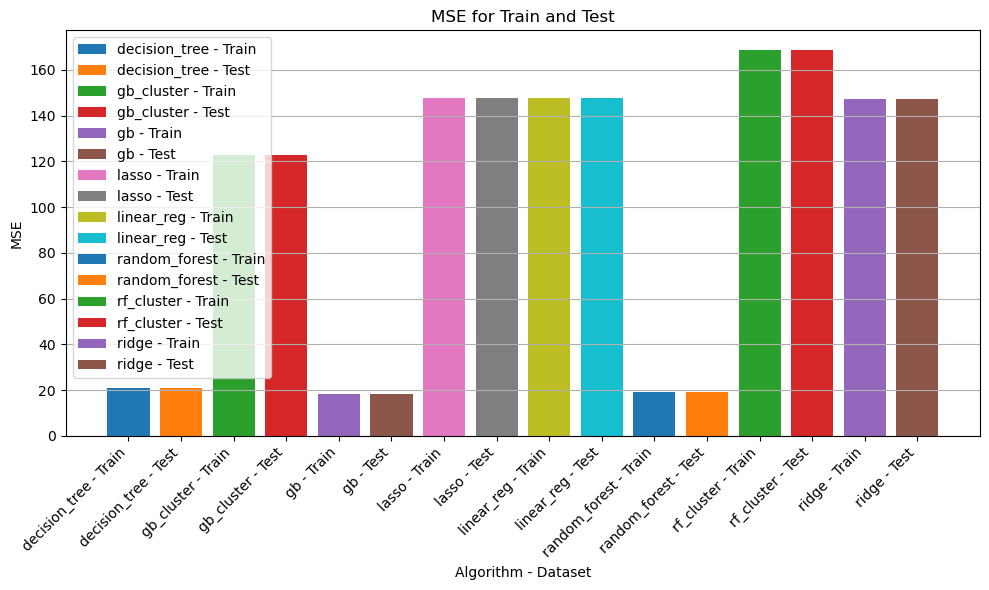

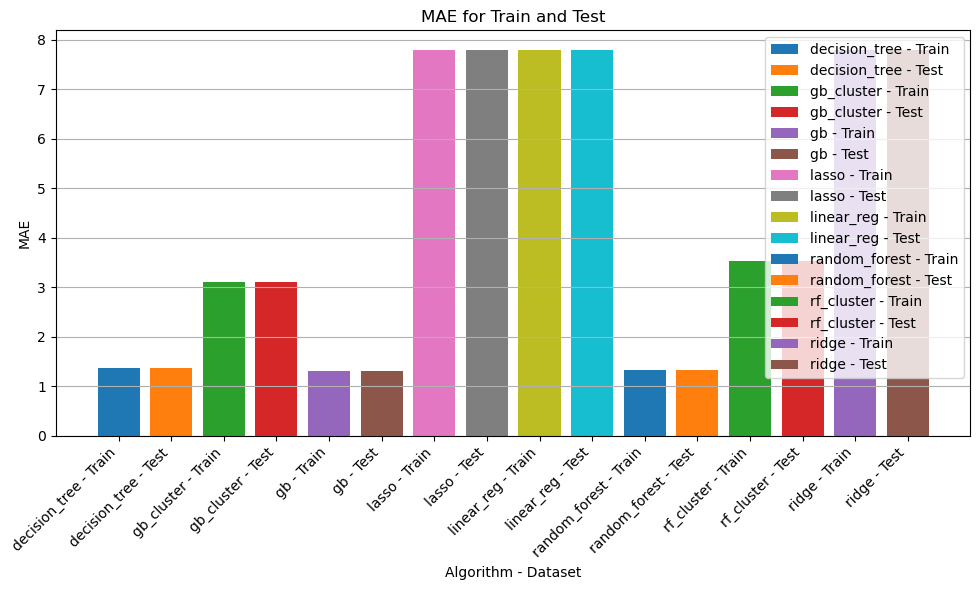

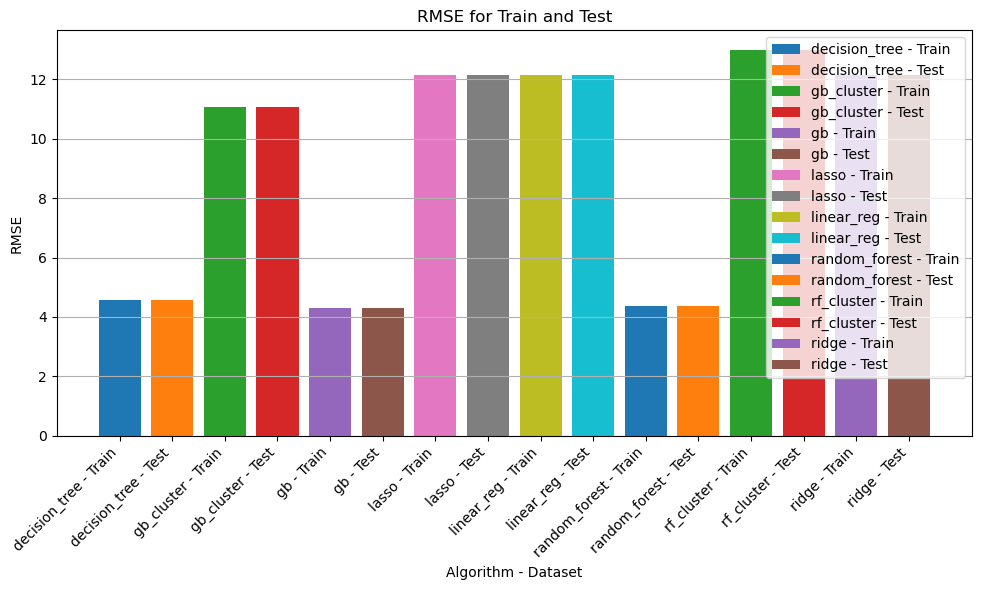

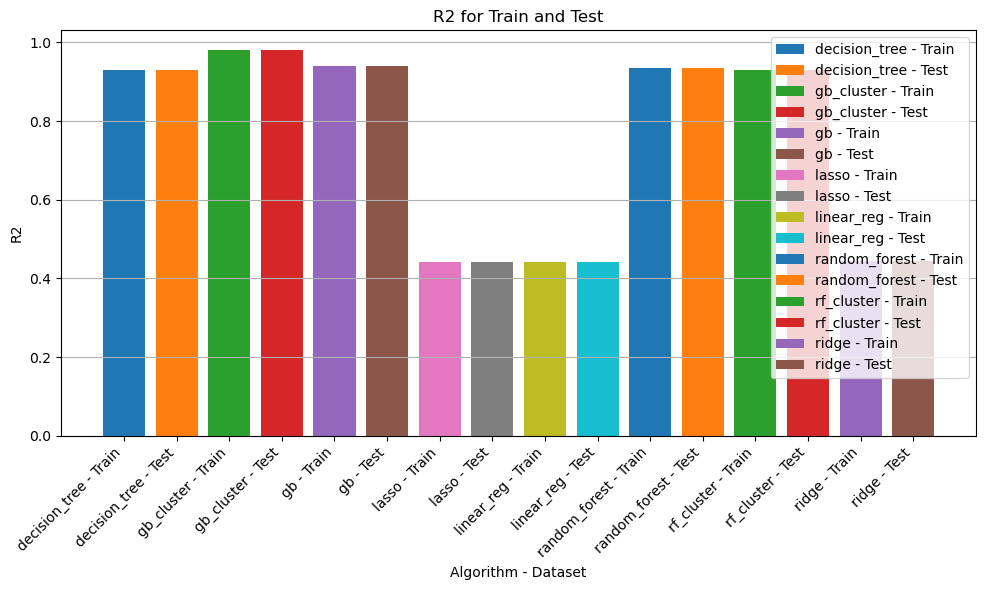

In [140]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

results_dir = 'models'

data = []

# Loop through each pickle file and load the data
for file in os.listdir(results_dir):
    if file.endswith('_results.pkl'):
        algo_name = file.replace('_results.pkl', '')
        file_path = os.path.join(results_dir, file)
        
        # Load the pickle file
        with open(file_path, 'rb') as f:
            df = pickle.load(f)
        
        # Transpose the DataFrame so the metrics are columns
        df = df.T
        
        # Add an 'Algorithm' column for the algorithm name
        df['Algorithm'] = algo_name
        data.append(df)

# Concatenate all the data into a single DataFrame and preserve the index
all_data = pd.concat(data, ignore_index=False)

# Print the column names to check the structure
print("Columns in all_data:", all_data.columns)

# Define the metrics to plot
metrics_to_plot = ['MSE', 'MAE', 'RMSE', 'R2']

# Plot each metric as a bar plot
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for algo in all_data['Algorithm'].unique():
        subset = all_data[all_data['Algorithm'] == algo]
        
        # Loop through Train and Test
        for dataset in ['Train', 'Test']:  
            # Check if the metric column exists before plotting
            if metric in subset.columns:
                plt.bar(f'{algo} - {dataset}', subset[metric], label=f'{algo} - {dataset}')
            else:
                print(f"Metric '{metric}' not found in the data for algorithm '{algo}'")
    
    plt.title(f'{metric} for Train and Test')
    plt.xlabel('Algorithm - Dataset')
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


### Feature importance

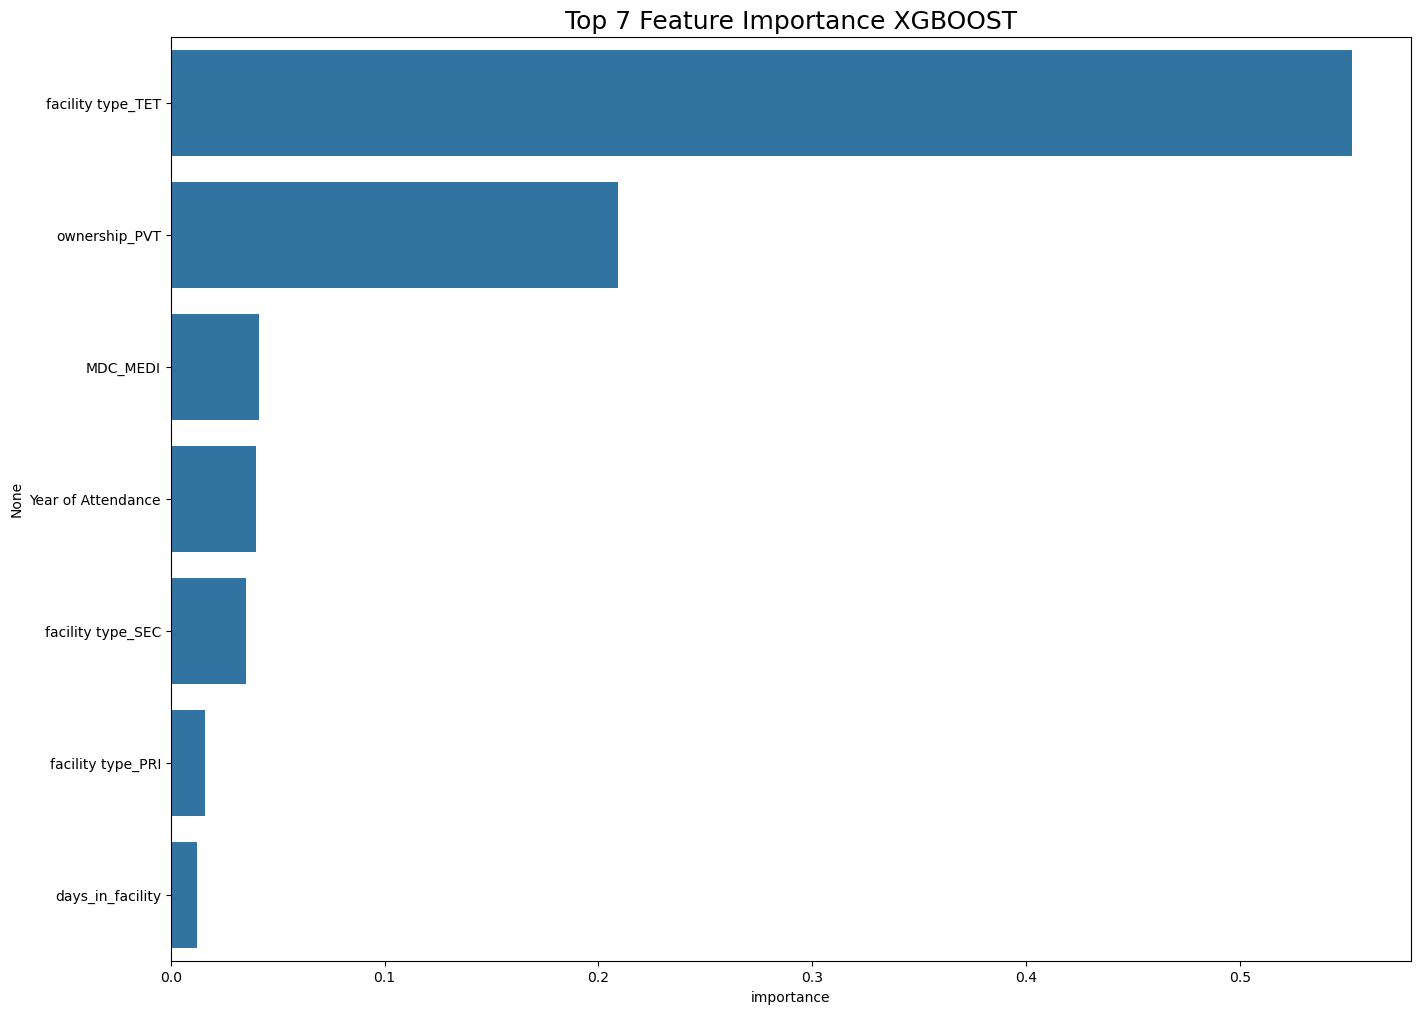

In [84]:
# Feature importance for XGBOOST

feature_importance_gb = pd.DataFrame(gb.feature_importances_, index=x.columns, columns=['importance']).sort_values('importance', ascending=False)
# Get the top 7 features
top_features_gb = feature_importance_gb.head(7)

# Plotting feature importance
plt.figure(figsize=(16, 12))
sns.barplot(x=top_features_gb['importance'], y=top_features_gb.index)
plt.title('Top 7 Feature Importance XGBOOST', fontsize=18)
plt.savefig('feature_importance_gb.png')
plt.show()


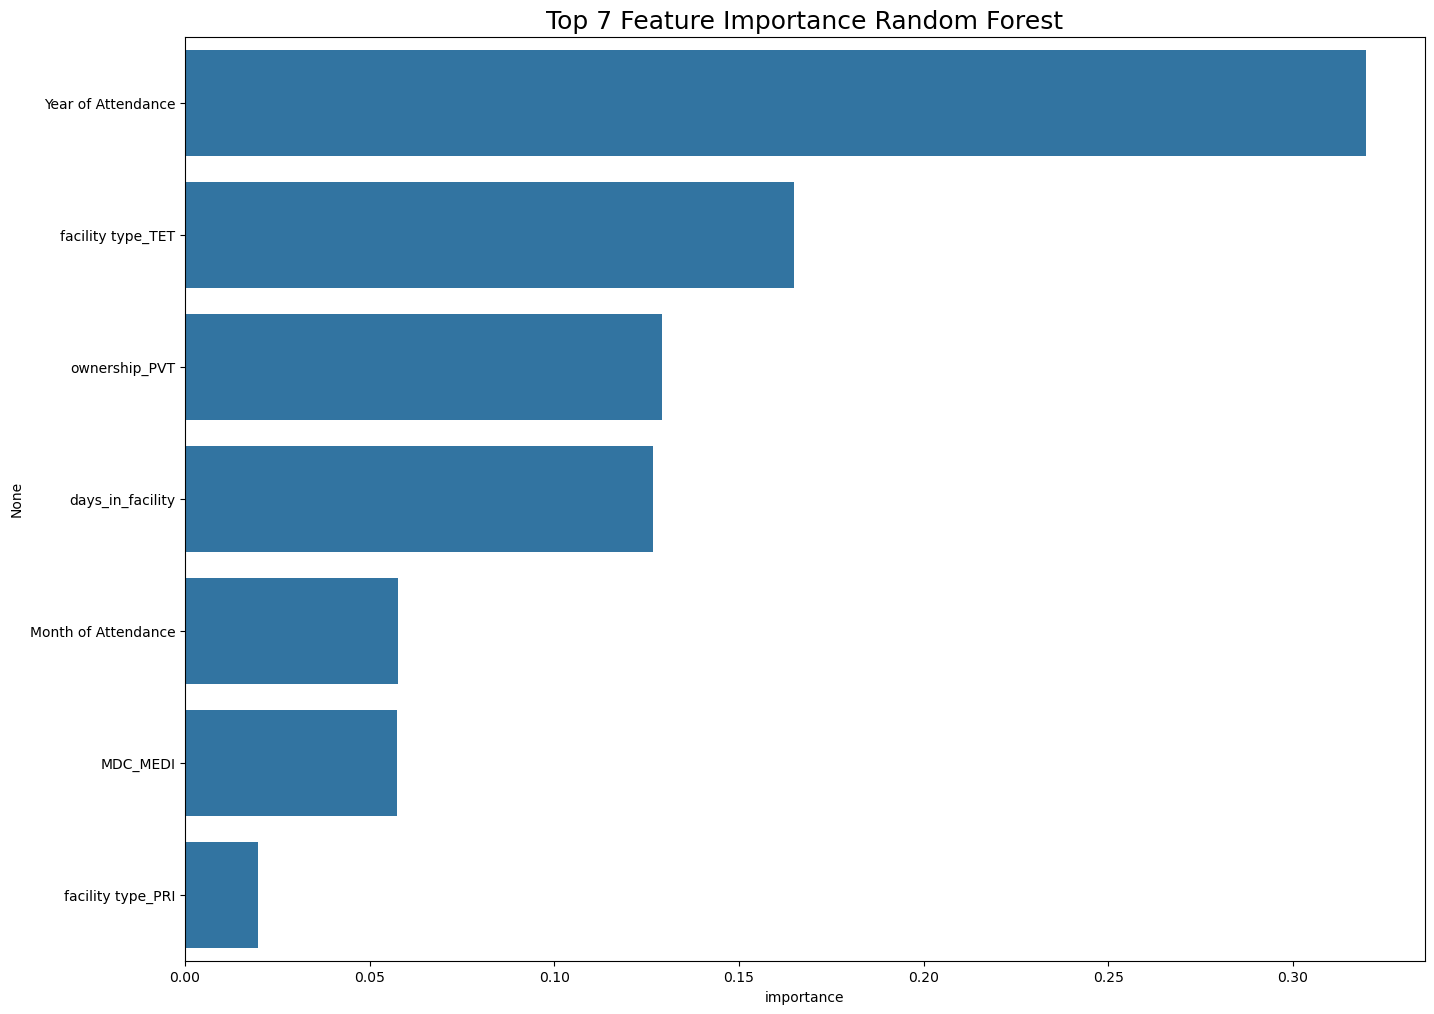

In [85]:
# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame(random_forest.feature_importances_, index=x.columns, columns=['importance']).sort_values('importance', ascending=False)
top_features_rf = feature_importance_rf.head(7)

# Plotting feature importance
plt.figure(figsize=(16, 12))
sns.barplot(x=top_features_rf['importance'], y=top_features_rf.index)
plt.title('Top 7 Feature Importance Random Forest', fontsize=18)
plt.savefig('feature_importance_rf.png')
plt.show()



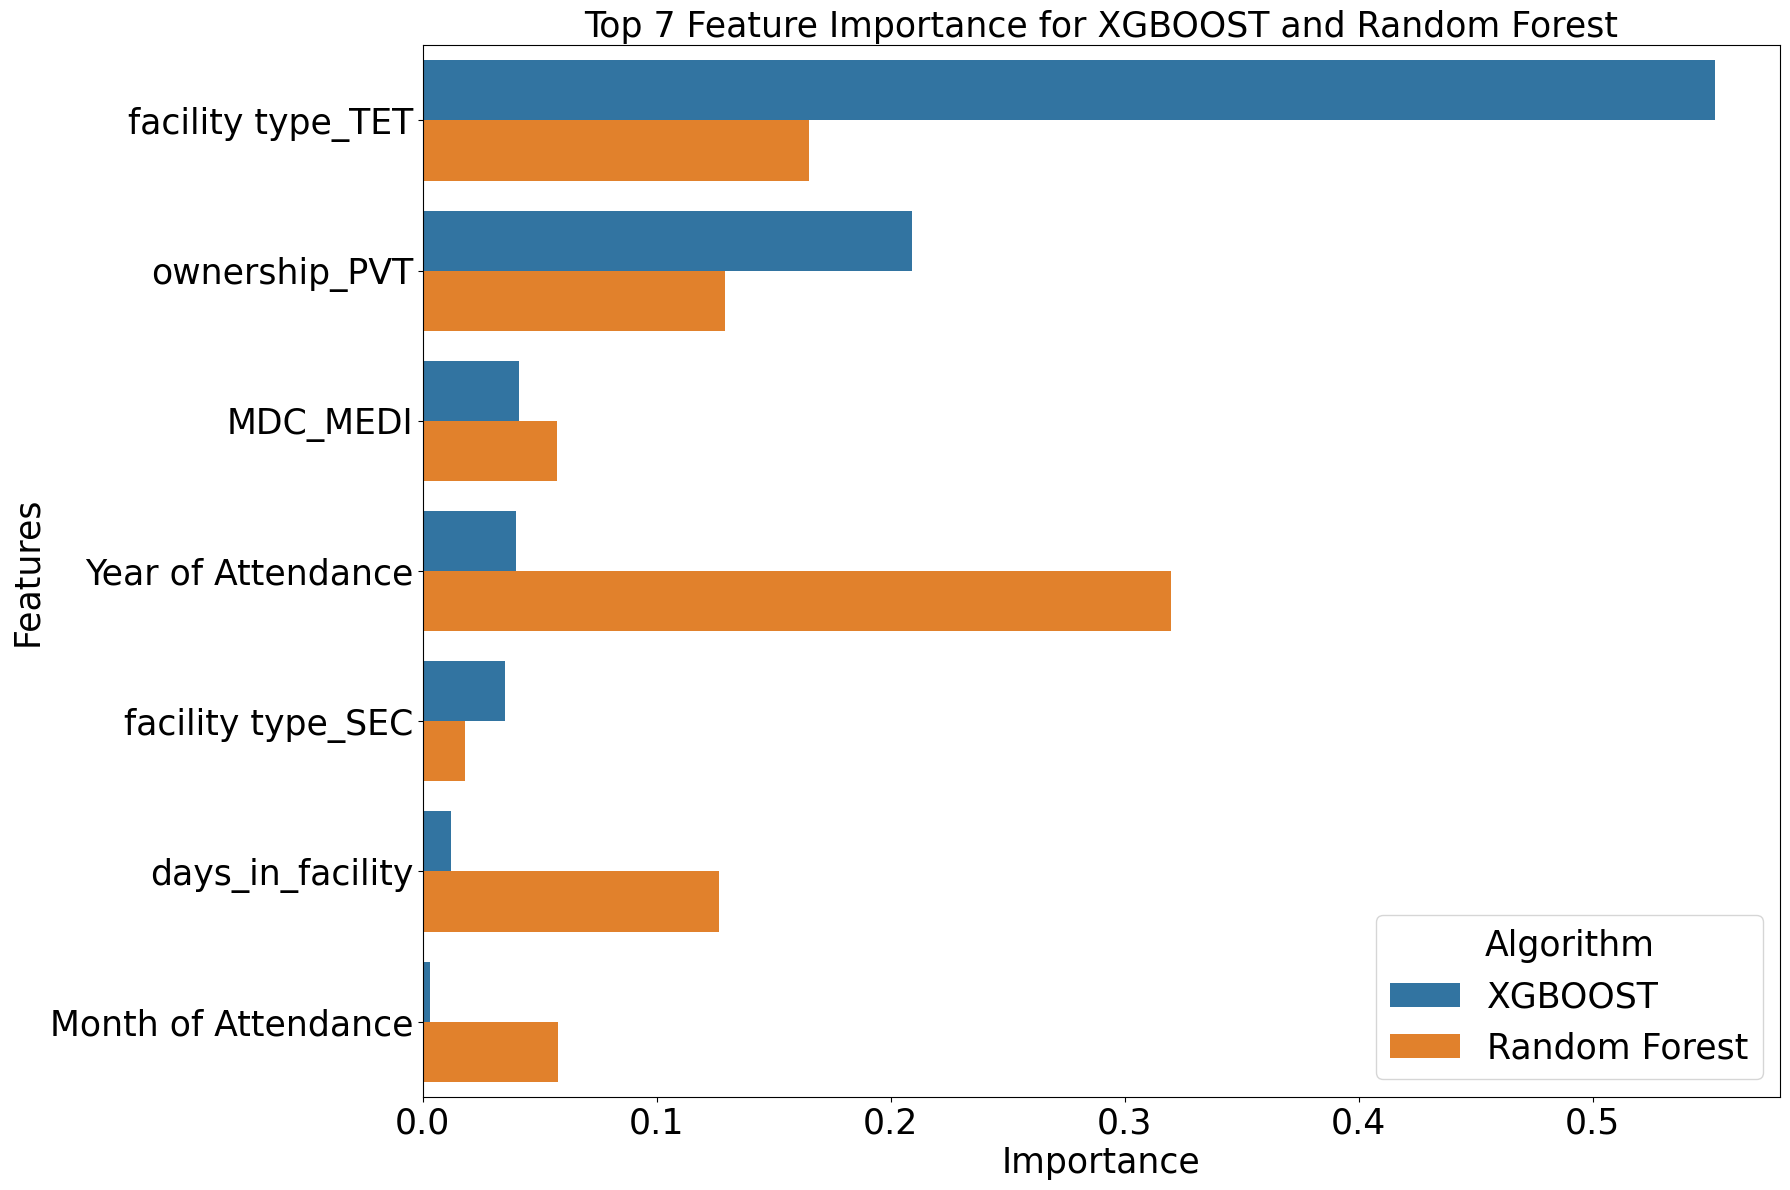

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance for XGBOOST
feature_importance_gb = pd.DataFrame(
    gb.feature_importances_, 
    index=x.columns, 
    columns=['importance']
).sort_values('importance', ascending=False)
feature_importance_gb['Algorithm'] = 'XGBOOST'
feature_importance_gb['Feature'] = feature_importance_gb.index

# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame(
    random_forest.feature_importances_, 
    index=x.columns, 
    columns=['importance']
).sort_values('importance', ascending=False)
feature_importance_rf['Algorithm'] = 'Random Forest'
feature_importance_rf['Feature'] = feature_importance_rf.index

# Combine and allow for overlap
combined_feature_importance = pd.concat([feature_importance_gb, feature_importance_rf])

# Select the top features across both algorithms
top_features = combined_feature_importance.groupby('Feature')['importance'].max().nlargest(7).index
top_combined_features = combined_feature_importance[combined_feature_importance['Feature'].isin(top_features)]

# Plotting
plt.figure(figsize=(18, 12))
sns.barplot(
    data=top_combined_features, 
    x='importance', 
    y='Feature', 
    hue='Algorithm', 
    dodge=True
)
plt.title('Top 7 Feature Importance for XGBOOST and Random Forest', fontsize=25)
plt.xlabel('Importance', fontsize=25)
plt.ylabel('Features', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(title='Algorithm', fontsize=25, title_fontsize=25)
plt.tight_layout()

# Save the combined plot
plt.savefig('combined_feature_importance_overlap.png')
plt.show()


What about feature importance for the outliers we detected?

In [99]:
clusters = pd.read_pickle('data/many_clusters.pkl')
#cluster list contains the clusters of outliers
cluster_list = [11,
 14,
 20,
 21,
 56,
 59,
 76,
 79,
 80,
 93,
 95,
 96,
 97,
 104,
 106,
 107,
 108,
 113,
 118,
 120,
 123,
 124,
 130,
 139,
 142,
 143,
 145,
 146,
 147,
 148,
 150,
 154,
 156,
 158,
 164,
 165,
 166,
 167,
 168,
 172,
 173,
 174,
 175,
 176,
 180,
 181,
 182,
 184,
 187,
 197,
 198,
 200,
 201,
 203,
 204,
 206,
 211,
 215,
 217,
 218,
 223,
 228,
 231,
 234,
 238,
 239,
 243,
 246,
 249,
 253,
 254,
 265,
 274,
 275,
 287,
 291,
 292,
 297,
 318,
 326,
 328,
 334,
 338,
 345,
 372,
 374,
 378,
 380,
 381,
 382,
 386,
 465,
 469,
 471,
 472,
 480,
 481,
 490]

In [101]:
df_clusters = pd.read_csv('data/eclaimit_clean.csv', low_memory=False)
df_clusters = df_clusters.drop(columns=['CLAIM ID', 'Member No', 'Month of Batch', 'Date of Discharge', 'GDRG', 'Type of Service', 'district', 'Medicine Cost', 'Total Cost of Claim', 'GDRG_clean', 'diagnosis', 'Service Cost',], inplace=False)
df_clusters = df_clusters.dropna()
df_clusters['Gender'] = df_clusters['Gender'].map({"M": 0, "m": 0, "F": 1, "f": 1}).fillna(df['Gender']).astype(int)
df_clusters["Date of Attendance"] = pd.to_datetime(df_clusters["Date of Attendance"])
df_clusters["Month of Attendance"] = df_clusters["Date of Attendance"].dt.month
df_clusters["Year of Attendance"] = df_clusters["Date of Attendance"].dt.year
df_clusters = df_clusters.drop(columns=["Date of Attendance"])
df_clusters = df_clusters.drop(columns=["GDRG_cleaner"])
one_hot_data_to_pickle(df_clusters, 'data/cluster_data.pkl')


In [102]:
df_clusters = pd.read_pickle('data/cluster_data.pkl')

In [103]:
df_clusters.shape

(7822676, 50)

In [104]:
clusters.shape

(7822676,)

In [105]:
df_clusters

,Gender,Age,days_in_facility,Service Cost per day,Month of Attendance,Year of Attendance,facility type_CLC,facility type_EYE,facility type_HLC,facility type_MTY,...,MDC_OBGY,MDC_OPDC,MDC_OPHT,MDC_ORTH,MDC_PAED,MDC_PSUR,MDC_RSUR,MDC_ZOOM,dist_status_Metropolitan,dist_status_Municipal
0,1,39.0,1,17.20,7,2019,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,1,31.0,1,12.84,7,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,1,75.0,1,12.84,8,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,1,76.0,1,12.84,8,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,1,38.0,1,12.84,11,2019,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7878558,1,78.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
7878559,1,57.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
7878560,1,89.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
7878561,1,74.0,1,17.67,1,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True


In [106]:
df_clusters["cluster"] = clusters
df_clusters = df_clusters[df_clusters["cluster"].isin(cluster_list)] #We only keep the outliers
df_clusters.drop(columns=["cluster"], inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_34376\3607024636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clusters.drop(columns=["cluster"], inplace=True)


In [107]:
df_clusters = df_clusters.reset_index(drop=True)

In [108]:
df_clusters

,Gender,Age,days_in_facility,Service Cost per day,Month of Attendance,Year of Attendance,facility type_CLC,facility type_EYE,facility type_HLC,facility type_MTY,...,MDC_OBGY,MDC_OPDC,MDC_OPHT,MDC_ORTH,MDC_PAED,MDC_PSUR,MDC_RSUR,MDC_ZOOM,dist_status_Metropolitan,dist_status_Municipal
0,1,31.0,1,27.71,5,2020,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,1,43.0,1,48.66,5,2022,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,1,59.0,1,42.84,1,2023,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,1,62.0,6,76.63,11,2021,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,1,32.0,1,17.20,3,2021,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50125,1,70.0,1,121.77,8,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
50126,1,49.0,1,121.77,8,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
50127,1,67.0,1,121.77,8,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
50128,1,67.0,1,121.77,8,2023,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


In [109]:
x_cluster = df_clusters.drop(columns=["Service Cost per day"])
y_cluster = df_clusters["Service Cost per day"]

x_train_cluster, x_test_cluster, y_train_cluster, y_test_cluster = train_test_split(x_cluster, y_cluster, test_size=0.2, random_state=42, shuffle=True)

scaler = StandardScaler()

x_train_cluster_scaled = scaler.fit_transform(x_train_cluster)
x_test_cluster_scaled = scaler.transform(x_test_cluster)


Now that we have our data without the outliers, let us use our best models (XGBOOST and Random Forest) and evaluate them again

In [110]:
gb_cluster = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', **best_params_gb)

gb_cluster, gb_cluster_results = train_evaluate_model(gb_cluster, x_train_cluster_scaled, y_train_cluster, x_test_cluster_scaled, y_test_cluster, retrain=True)

gb_cluster_results.to_pickle('models/gb_cluster_results.pkl')

gb_cluster_results

,Train,Test
MSE,39.917895,122.782200
MAE,1.829484,3.104674
RMSE,6.318061,11.080713
R2,0.981502,0.940900


In [111]:
rf_cluster = RandomForestRegressor(random_state=42, n_jobs=-1, **best_params_rf)

rf_cluster, rf_cluster_results = train_evaluate_model(rf_cluster, x_train_cluster_scaled, y_train_cluster, x_test_cluster_scaled, y_test_cluster, retrain=True)

rf_cluster_results.to_pickle('models/rf_cluster_results.pkl')

rf_cluster_results

,Train,Test
MSE,168.864516,144.086286
MAE,3.526451,3.516782
RMSE,12.994788,12.003595
R2,0.921747,0.930646


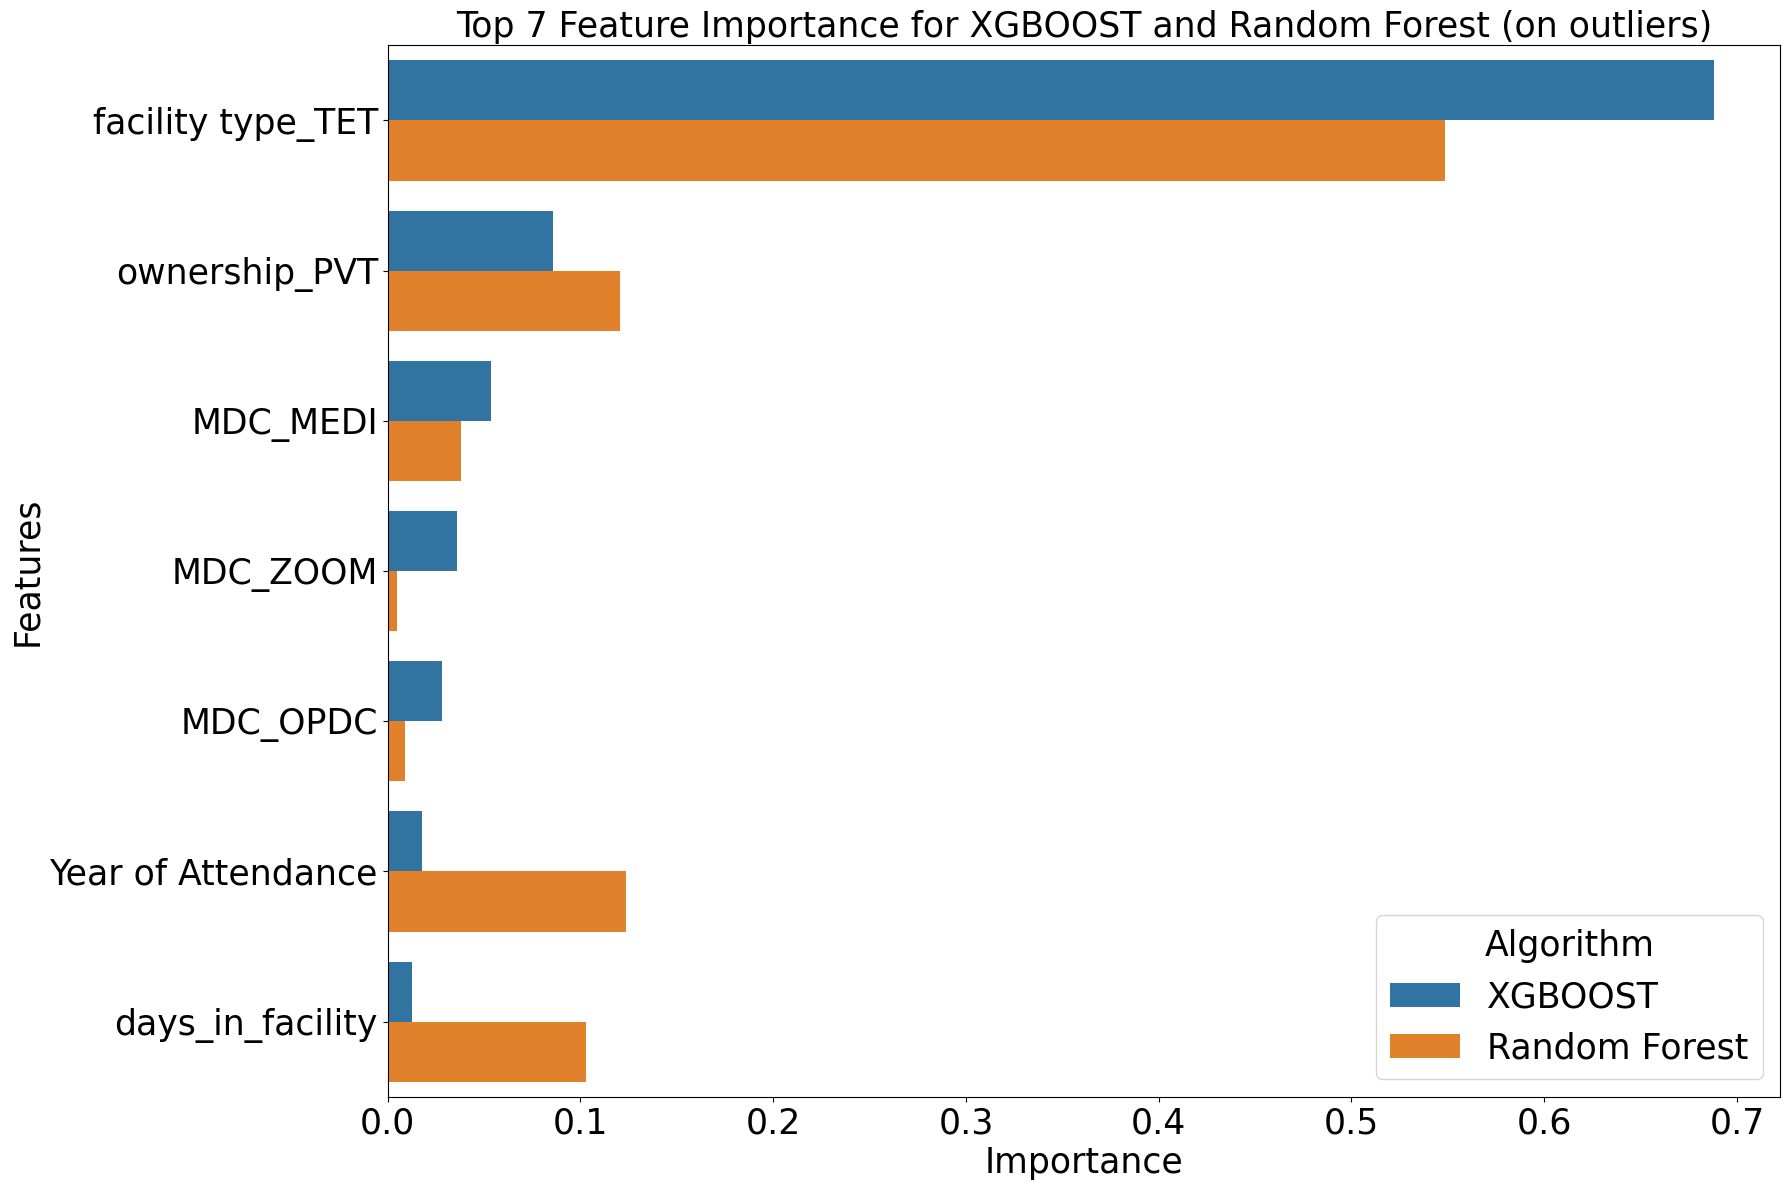

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance for XGBOOST
feature_importance_gb_cluster = pd.DataFrame(
    gb_cluster.feature_importances_, 
    index=x_cluster.columns, 
    columns=['importance']
).sort_values('importance', ascending=False)
feature_importance_gb_cluster['Algorithm'] = 'XGBOOST'
feature_importance_gb_cluster['Feature'] = feature_importance_gb_cluster.index

# Feature importance for Random Forest
feature_importance_rf_cluster = pd.DataFrame(
    rf_cluster.feature_importances_, 
    index=x_cluster.columns, 
    columns=['importance']
).sort_values('importance', ascending=False)
feature_importance_rf_cluster['Algorithm'] = 'Random Forest'
feature_importance_rf_cluster['Feature'] = feature_importance_rf_cluster.index

# Combine and allow for overlap
combined_feature_importance = pd.concat([feature_importance_gb_cluster, feature_importance_rf_cluster])

# Select the top features across both algorithms
top_features = combined_feature_importance.groupby('Feature')['importance'].max().nlargest(7).index
top_combined_features = combined_feature_importance[combined_feature_importance['Feature'].isin(top_features)]

# Plotting
plt.figure(figsize=(18, 12))
sns.barplot(
    data=top_combined_features, 
    x='importance', 
    y='Feature', 
    hue='Algorithm', 
    dodge=True
)
plt.title('Top 7 Feature Importance for XGBOOST and Random Forest (on outliers)', fontsize=25)
plt.xlabel('Importance', fontsize=25)
plt.ylabel('Features', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(title='Algorithm', fontsize=25, title_fontsize=25)
plt.tight_layout()

# Save the combined plot
plt.savefig('combined_feature_importance_overlap_cluster.png')
plt.show()
